# Communication Methods & Measures - R1

### Main changes:
* Creating scatterplots for each pair of classifiers
* Reporting Krippendorff's alpha (and confidence intervals) instead of correlations
* "readability_score" module used: https://github.com/wimmuskee/readability-score)
* For Krippendorff's Alpha calculations: used same predictions as in R0 (used for precision/recall) yet with KAlpha = ordinal



# Preparation

## Configure IPython

In [1]:
# activate plots
%matplotlib inline

## Load libraries

In [2]:
from scripts_r1 import analyze # some analysis helper functions for this paper
import pandas 
import datetime
import os
import numpy
import statsmodels.formula.api as sm
import seaborn

## prepare some visualization stuff

In [3]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
corplot = lambda cortable, title: seaborn.heatmap(cortable, linewidth=.1, annot=True, cmap="RdBu_r", vmin=-1, vmax=1).set_title(title)
tool_order = [ "recessie" , "boukes","LIWC","sentistrength","pattern","polyglot","DANEW"]
text_order = ["text_"+tool for tool in tool_order]
title_order = ["title_"+tool for tool in tool_order]

# Preprocessing

In [4]:
path_to_files = "./data"
coded_files   = "./results/data_with_sentiment.csv"
os.makedirs('results',exist_ok=True)

## Do or Load Sentiment analysis

In [5]:
# If sentiments have not yet been computed
if not os.path.exists(coded_files):
    print("Starting from scratch")
    raw_data = analyze.load_files(path_to_files)
    print("Recoding")
    rec_data = analyze.recode_annotations(raw_data) 
    print("Adding sentiment")
    sen_data = analyze.add_sentiments(analyze.add_sentiments(rec_data,'text'),'title')
    print("Adding linguistic features for error analysis")
    tex_data = analyze.add_text_properties(analyze.add_text_properties(sen_data,'text'),'title')
    print("Writing results to disk")
    tex_data.to_csv(coded_files)
    data = tex_data
# If sentiments have been computed
else:
    print("Using previously stored computations")
    data = pandas.read_csv(coded_files)

data.index = data.ID

# Add LIWC results if available
if "LIWC2015 Results (ID_Text.csv).csv" in os.listdir(path_to_files):
    text_liwc = pandas.read_csv(os.path.join(path_to_files,"LIWC2015 Results (ID_Text.csv).csv"))
    text_liwc = pandas.DataFrame({'ID':text_liwc.A, 'text_LIWC':text_liwc.Posemo - text_liwc.Negemo}).loc[2:,:]
    text_liwc.index = text_liwc.ID.astype("float64")
    data = data.join(text_liwc.drop('ID',1))
    
if "LIWC2015 Results (ID_Title.csv).csv" in os.listdir(path_to_files):
    title_liwc = pandas.read_csv(os.path.join(path_to_files,"LIWC2015 Results (ID_Title.csv).csv"))
    title_liwc = pandas.DataFrame({'ID':title_liwc.A, 'title_LIWC':title_liwc.Posemo - title_liwc.Negemo}).loc[2:,:]
    title_liwc.index = title_liwc.ID.astype("float64")
    data = data.join(title_liwc.drop('ID',1))
    
# Set time-based index
todate = lambda d: datetime.datetime.strptime(d.replace('T',' ').split('.')[0],'%Y-%m-%d %H:%M:%S')
data.index = data.date_y.map(todate) # saving as CSV breaks the timeindex, so we reconstruct it here
    

# Filter out timepoints after which data becomes too sparse
filtered = (data.index >= datetime.datetime(year=2015,month=7,day=7)).sum()
data = data[data.index < datetime.datetime(year=2015,month=7,day=7)] 
print("filtered out",filtered, "observations")

data = data[~data.index.dayofweek.isin([0,6])]

Using previously stored computations
filtered out 215 observations


In [6]:
data.isna().sum()

date_y                         0
Codeur                         0
Day_in_2015                    0
Economisch_Ja                  0
Hoofd_OW                     120
ID                             0
Posit_Nega                   121
Source                         0
Toon_Kop                     114
date_x                         0
headline                       0
outlet                         0
date_y.1                       0
type                           0
source                         0
title                          0
text                           0
online                         0
quality                        0
title_gold                  1166
text_gold                   4380
text_polyglot                  0
text_pattern                   0
text_DANEW                     0
text_boukes                    0
text_sentistrength             0
text_recessie                  0
title_polyglot                 0
title_pattern                  0
title_DANEW                    0
title_bouk

## order columns appropriately

In [35]:
data.index = range(len(data))
red = data.copy()
data = data.drop(text_order,axis=1)
data = data.drop(title_order,axis=1)
data = data.join(red[text_order])
data = data.join(red[title_order])
del(red)
data.index = data.index = data.date_y.map(todate) # saving as CSV breaks the timeindex, so we reconstruct it here

### Option to toggle non-relevant human annotations to '0'

In [36]:
#data.text_gold = data.text_gold.replace({numpy.nan:0})
#data.title_gold = data.title_gold.replace({numpy.nan:0})

## Resulting crosstabs for gold annotations

In [37]:
print("Fulltext crosstab")
pandas.DataFrame(
    {
        'online':data.text_gold[data.online].value_counts(),
        'online_%': round(data.text_gold[data.online].value_counts()/data.text_gold[data.online].value_counts().sum(),2),
        'offline':data.text_gold[~data.online].value_counts(),
        'offline_%': round(data.text_gold[~data.online].value_counts()/data.text_gold[~data.online].value_counts().sum(),2),
        'total': data.text_gold.value_counts()
    }
).sort_index()

Fulltext crosstab


,online,online_%,offline,offline_%,total
-2.0,61,0.24,265,0.23,326
-1.0,43,0.17,225,0.19,268
0.0,10,0.04,120,0.10,130
1.0,64,0.25,274,0.23,338
2.0,77,0.30,287,0.25,364


In [38]:
print("Headline crosstab")
pandas.DataFrame(
    {
        'online':data.title_gold[data.online].value_counts(),
        'online_%': round(data.title_gold[data.online].value_counts()/data.title_gold[data.online].value_counts().sum(),2),
        'offline':data.title_gold[~data.online].value_counts(),
        'offline_%': round(data.title_gold[~data.online].value_counts()/data.title_gold[~data.online].value_counts().sum(),2),
        'total': data.title_gold.value_counts()
    }
).sort_index()

Headline crosstab


,online,online_%,offline,offline_%,total
-1.0,244,0.31,1280,0.33,1524
0.0,368,0.47,1640,0.43,2008
1.0,173,0.22,935,0.24,1108


## Computing fleiss-scores

In [39]:
annotations = pandas.read_csv(os.path.join(path_to_files, "Inhoudsanalyse_AllesMerged_noICR_toneOnly.csv"),delimiter=";")
annotations = annotations.replace({" ":numpy.nan})
#annotations[["Toon_Kop","Posit_Nega"]] = annotations[["Toon_Kop","Posit_Nega"]].astype(float)


print("Headline Fleiss score, N: ", analyze.calculate_intercoder_reliability(annotations, "ID","Codeur","Toon_Kop"))
print("Fulltext Fleiss score, N: ", analyze.calculate_intercoder_reliability(annotations, "ID","Codeur","Posit_Nega"))

Headline Fleiss score, N:  (-0.054945054945054944, 8)
Fulltext Fleiss score, N:  (0.23809523809523808, 8)


## Add 'the best of the best' models

In [40]:
data = analyze.z_best(data, 'title', list(reversed(["LIWC","polyglot","sentistrength","DANEW"])))
data = analyze.z_best(data, 'text', list(reversed(["LIWC","polyglot","sentistrength","DANEW"])))

## Agregations 

In [41]:
article_data = data.copy()
daily_data   = data.copy().resample("1D").mean()
weekly_data  = data.copy().resample("1W").mean()

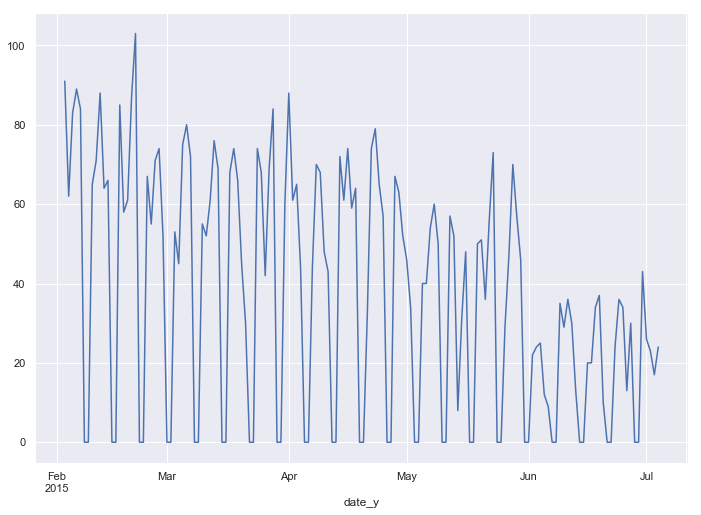

In [42]:
article_data.resample("1D").count().date_y.plot()

### Errors

In [43]:
# article level errors
article_text_errors  = analyze.calculate_errors(article_data,'text')
article_title_errors = analyze.calculate_errors(article_data,'title')
# daily level errors
daily_text_errors  = analyze.calculate_errors(daily_data, 'text')
daily_title_errors = analyze.calculate_errors(daily_data, 'title')
# weekly level errors
weekly_text_errors  = analyze.calculate_errors(weekly_data, 'text')
weekly_title_errors = analyze.calculate_errors(weekly_data, 'title')

# Analysis

## Error analysis

### Predictors of title absolute errors

In [44]:
analyze.analyze_errors(article_title_errors,'title')

,top2,top3,DANEW,recessie,sentistrength,top1,LIWC,boukes,top4,polyglot,pattern
Flesch_title,0.04 **,0.06 ***,0.04 **,0.01,0.05 **,-0.01,-0.04 **,0.02,0.07 ***,0.07 ***,0.03 *
Intercept,0.01,-0.00,0.01,0.01,-0.02,0.01,0.01,0.01,0.00,-0.00,0.01
Model_F_score,6.79 ***,10.91 ***,44.67 ***,15.00 ***,22.57 ***,17.53 ***,7.16 ***,21.08 ***,13.63 ***,15.03 ***,15.98 ***
Model_R2,0.01,0.01,0.05,0.02,0.02,0.02,0.01,0.02,0.01,0.02,0.02
Model_adj_R2,0.01,0.01,0.04,0.01,0.02,0.02,0.01,0.02,0.01,0.01,0.02
N_observations,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640
online[T.True],-0.04,0.01,-0.04,-0.07,0.10 *,-0.07,-0.05,-0.05,-0.00,0.02,-0.06
quality,-0.02,-0.02,-0.07 ***,-0.07 ***,-0.01,-0.05 ***,-0.02,-0.06 ***,-0.03 *,0.02,-0.05 ***
title_gold,-0.06 ***,-0.09 ***,-0.20 ***,-0.10 ***,0.08 ***,-0.08 ***,-0.03,-0.13 ***,-0.09 ***,-0.10 ***,-0.11 ***
word_count_title,-0.04 **,0.00,0.01,0.01,0.11 ***,-0.08 ***,-0.06 ***,0.03 *,-0.02,0.02,0.03 *


In [45]:
analyze.analyze_errors(article_title_errors,'title')[tool_order]

,recessie,boukes,LIWC,sentistrength,pattern,polyglot,DANEW
Flesch_title,0.01,0.02,-0.04 **,0.05 **,0.03 *,0.07 ***,0.04 **
Intercept,0.01,0.01,0.01,-0.02,0.01,-0.00,0.01
Model_F_score,15.00 ***,21.08 ***,7.16 ***,22.57 ***,15.98 ***,15.03 ***,44.67 ***
Model_R2,0.02,0.02,0.01,0.02,0.02,0.02,0.05
Model_adj_R2,0.01,0.02,0.01,0.02,0.02,0.01,0.04
N_observations,4640,4640,4640,4640,4640,4640,4640
online[T.True],-0.07,-0.05,-0.05,0.10 *,-0.06,0.02,-0.04
quality,-0.07 ***,-0.06 ***,-0.02,-0.01,-0.05 ***,0.02,-0.07 ***
title_gold,-0.10 ***,-0.13 ***,-0.03,0.08 ***,-0.11 ***,-0.10 ***,-0.20 ***
word_count_title,0.01,0.03 *,-0.06 ***,0.11 ***,0.03 *,0.02,0.01


### Predictors of text absolute errors

In [46]:
analyze.analyze_errors(article_data,'text')[tool_order]

,recessie,boukes,LIWC,sentistrength,pattern,polyglot,DANEW
Flesch_text,-0.03,-0.01,-0.05,0.02,-0.04,-0.05,-0.05
Intercept,-0.03,-0.00,0.02,0.00,-0.03,-0.02,-0.03
Model_F_score,8.53 ***,12.71 ***,10.19 ***,111.73 ***,9.81 ***,22.52 ***,10.55 ***
Model_R2,0.03,0.04,0.03,0.28,0.03,0.07,0.04
Model_adj_R2,0.03,0.04,0.03,0.28,0.03,0.07,0.03
N_observations,1426,1426,1426,1426,1426,1426,1426
online[T.True],0.17 *,0.03,-0.12,-0.01,0.16 *,0.11,0.16 *
quality,0.01,0.05,0.00,0.04,0.01,0.02,0.00
text_gold,0.04,-0.11 ***,-0.11 ***,0.52 ***,-0.06 *,-0.23 ***,-0.07 **
word_count_text,-0.13 ***,0.15 ***,-0.14 ***,-0.03,-0.15 ***,-0.14 ***,-0.15 ***


## Article-level

### Distributions

        title_gold  title_recessie  title_boukes   title_LIWC  \
count  4640.000000     5806.000000   5806.000000  5806.000000   
mean     -0.089655       -0.001033      0.006373    -0.002045   
std       0.747880        0.032133      0.120124     0.090076   
min      -1.000000       -1.000000     -1.000000    -1.000000   
25%      -1.000000        0.000000      0.000000     0.000000   
50%       0.000000        0.000000      0.000000     0.000000   
75%       0.000000        0.000000      0.000000     0.000000   
max       1.000000        0.000000      1.000000     1.000000   

       title_sentistrength  title_pattern  title_polyglot  title_DANEW  \
count          5806.000000    5806.000000     5806.000000  5806.000000   
mean             -0.077678      -0.000660        0.042096     0.053019   
std               0.263144       0.225344        0.686317     0.086831   
min              -1.000000      -1.000000       -1.000000    -1.000000   
25%               0.000000       0.000000   

[Text(0,0,'Human\nAnnotation'),
 Text(0,0,'Recession'),
 Text(0,0,'Damstra &\nBoukes'),
 Text(0,0,'LIWC'),
 Text(0,0,'Sentistrength'),
 Text(0,0,'Pattern'),
 Text(0,0,'Polyglot'),
 Text(0,0,'DANEW')]

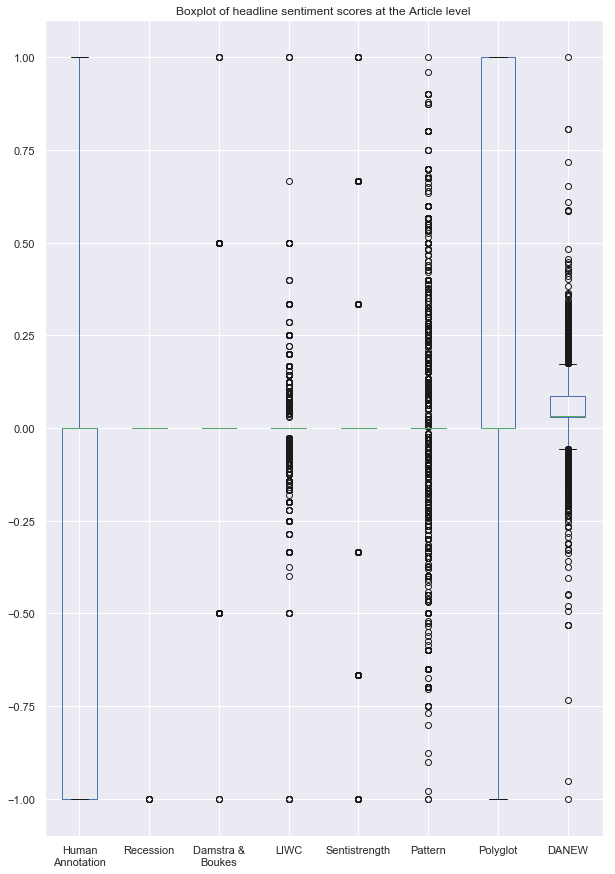

In [47]:
standardized = analyze.compare_sentiment_means(article_data.loc[:,["title_gold"]+title_order],field='title')
plot = standardized.drop('ID',1).plot(kind='box',figsize=(10,15),title="Boxplot of headline sentiment scores at the Article level")
plot.set_xticklabels(['Human\nAnnotation','Recession','Damstra &\nBoukes','LIWC','Sentistrength','Pattern','Polyglot','DANEW'])

In [48]:
article_data.loc[:,["title_gold"]+title_order].describe()

,title_gold,title_recessie,title_boukes,title_LIWC,title_sentistrength,title_pattern,title_polyglot,title_DANEW
count,4640.000000,5806.000000,5806.000000,5806.000000,5806.000000,5806.000000,5806.000000,5806.000000
mean,-0.089655,-0.001033,0.012745,-0.204487,-0.233035,-0.000660,0.042096,0.054169
std,0.747880,0.032133,0.240247,9.007601,0.789433,0.225344,0.686317,0.205356
min,-1.000000,-1.000000,-2.000000,-100.000000,-3.000000,-1.000000,-1.000000,-2.436222
25%,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004979
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.135944
max,1.000000,0.000000,2.000000,100.000000,3.000000,1.000000,1.000000,2.293778


In [49]:
from scipy.stats import kstest,kurtosis,skew
print("Online")
for col in text_order:
    k,pval = kstest(article_data[article_data.online==True][col].dropna(),cdf='norm')
    kurt   = kurtosis(article_data[article_data.online==True][col].dropna())
    sk     = skew(article_data[article_data.online==True][col].dropna())
    print("{:20.20s}: D={:0.3f} pval={:0.3f} kurtosis={:6.2f} skew={:6.2f}".format(col,k,pval,kurt,sk))
print("Offline")
for col in text_order:
    k,pval = kstest(article_data[article_data.online==False][col].dropna(),cdf='norm')
    kurt   = kurtosis(article_data[article_data.online==False][col].dropna())
    sk     = skew(article_data[article_data.online==False][col].dropna())
    print("{:20.20s}: D={:0.3f} pval={:0.3f} kurtosis={:6.2f} skew={:6.2f}".format(col,k,pval,kurt,sk))

Online
text_recessie       : D=0.500 pval=0.000 kurtosis= 35.07 skew= -6.09
text_boukes         : D=0.318 pval=0.000 kurtosis=  6.82 skew=  0.48
text_LIWC           : D=0.108 pval=0.000 kurtosis=  1.94 skew= -0.01
text_sentistrength  : D=0.482 pval=0.000 kurtosis= -0.27 skew=  0.25
text_pattern        : D=0.417 pval=0.000 kurtosis=  2.04 skew= -0.12
text_polyglot       : D=0.394 pval=0.000 kurtosis=  0.92 skew=  0.02
text_DANEW          : D=0.490 pval=0.000 kurtosis=  0.78 skew=  0.45
Offline
text_recessie       : D=0.500 pval=0.000 kurtosis= 34.42 skew= -6.03
text_boukes         : D=0.307 pval=0.000 kurtosis=  9.60 skew=  0.41
text_LIWC           : D=0.103 pval=0.000 kurtosis=  4.66 skew=  0.32
text_sentistrength  : D=0.430 pval=0.000 kurtosis= -0.16 skew=  0.02
text_pattern        : D=0.402 pval=0.000 kurtosis=  4.04 skew= -0.49
text_polyglot       : D=0.377 pval=0.000 kurtosis=  2.35 skew=  0.02
text_DANEW          : D=0.483 pval=0.000 kurtosis=  1.40 skew=  0.22


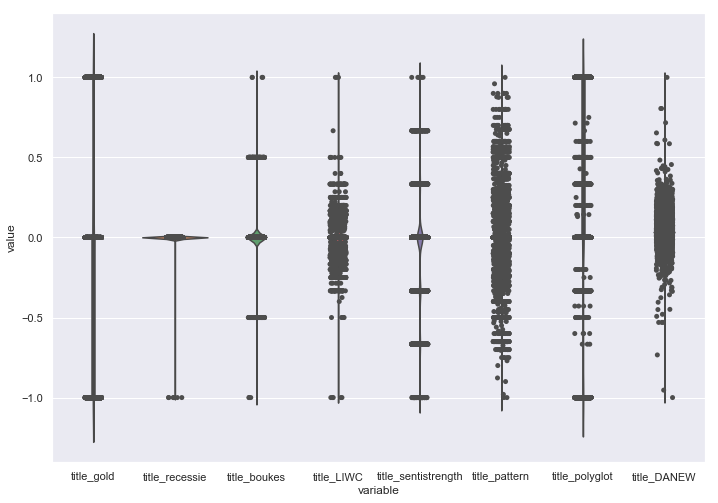

In [50]:
seaborn.violinplot(x="variable", y="value",data=standardized.drop('ID',1).melt())
seaborn.stripplot(x="variable", y="value",data=standardized.drop('ID',1).melt(),color=".3",jitter=True)

         text_gold  text_recessie  text_boukes    text_LIWC  \
count  1426.000000    5806.000000  5806.000000  5806.000000   
mean      0.051192      -0.025319    -0.021944     0.044028   
std       0.766749       0.157105     0.109891     0.128360   
min      -1.000000      -1.000000    -1.000000    -1.000000   
25%      -0.500000       0.000000    -0.037037    -0.026549   
50%       0.000000       0.000000    -0.037037     0.037611   
75%       1.000000       0.000000     0.037037     0.113938   
max       1.000000       0.000000     1.000000     1.000000   

       text_sentistrength  text_pattern  text_polyglot   text_DANEW  \
count         5806.000000   5806.000000    5806.000000  5806.000000   
mean             0.087438      0.093256       0.157393     0.028282   
std              0.326150      0.167585       0.222722     0.192387   
min             -1.000000     -1.000000      -1.000000    -1.000000   
25%              0.000000      0.002956       0.025641    -0.091724   
50%   

[Text(0,0,'Human\nAnnotation'),
 Text(0,0,'Recession'),
 Text(0,0,'Damstra &\nBoukes'),
 Text(0,0,'LIWC'),
 Text(0,0,'Sentistrength'),
 Text(0,0,'Pattern'),
 Text(0,0,'Polyglot'),
 Text(0,0,'DANEW')]

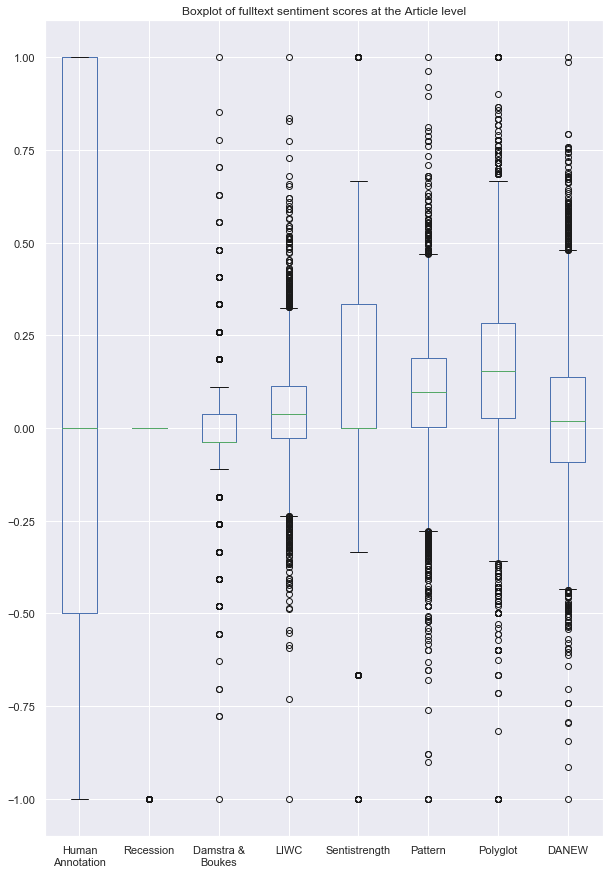

In [51]:
standardized = analyze.compare_sentiment_means(article_data.loc[:,["text_gold"]+text_order],field='text')
plot=standardized.drop('ID',1).plot(
    kind='box',
    figsize=(10,15),
    title="Boxplot of fulltext sentiment scores at the Article level"
    )
plot.set_xticklabels(['Human\nAnnotation','Recession','Damstra &\nBoukes','LIWC','Sentistrength','Pattern','Polyglot','DANEW'])

        text_gold  text_recessie  text_boukes   text_LIWC  text_sentistrength  \
count  255.000000     961.000000   961.000000  961.000000          961.000000   
mean     0.103922      -0.024974     0.076948    0.043891           -0.137981   
std      0.798611       0.156127     0.154148    0.224568            0.394525   
min     -1.000000      -1.000000    -1.000000   -1.000000           -1.000000   
25%     -0.500000       0.000000     0.052632   -0.077661           -0.600000   
50%      0.500000       0.000000     0.052632    0.025887           -0.200000   
75%      1.000000       0.000000     0.157895    0.171620            0.200000   
max      1.000000       0.000000     1.000000    1.000000            1.000000   

       text_pattern  text_polyglot  text_DANEW          ID  
count    961.000000     961.000000  961.000000  961.000000  
mean       0.164375       0.087033   -0.165527  480.000000  
std        0.189924       0.232393    0.298936  277.561104  
min       -1.000000      -

[Text(0,0,'Manual\nAnnotation'),
 Text(0,0,'Recession'),
 Text(0,0,'Damstra &\nBoukes'),
 Text(0,0,'LIWC'),
 Text(0,0,'Sentistrength'),
 Text(0,0,'Pattern'),
 Text(0,0,'Polyglot'),
 Text(0,0,'DANEW')]

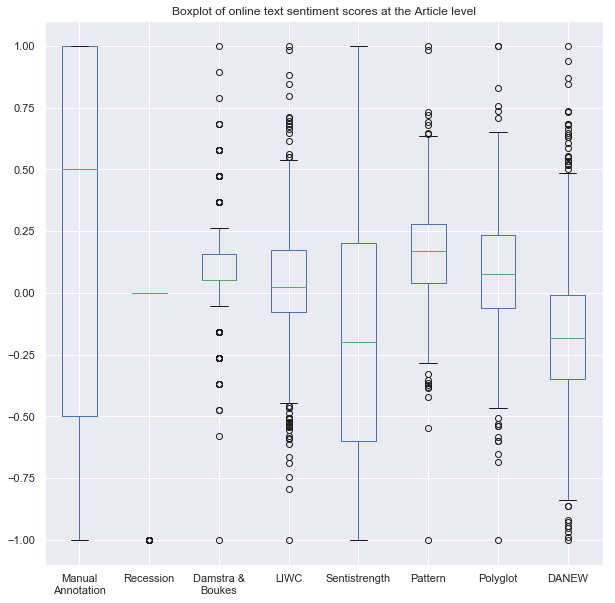

In [52]:
standardized = analyze.compare_sentiment_means(article_data[article_data.online].loc[:,["text_gold"]+text_order],field='text')
plot=standardized.drop('ID',1).plot(
    kind='box',
    figsize=(10,10),
    title="Boxplot of online text sentiment scores at the Article level",
    )
plot.set_xticklabels(['Manual\nAnnotation','Recession','Damstra &\nBoukes','LIWC','Sentistrength','Pattern','Polyglot','DANEW'])

        text_gold  text_recessie  text_boukes    text_LIWC  \
count  1171.00000    4845.000000  4845.000000  4845.000000   
mean      0.03971      -0.025387    -0.022345     0.043240   
std       0.75950       0.157314     0.110176     0.128122   
min      -1.00000      -1.000000    -1.000000    -1.000000   
25%      -0.50000       0.000000    -0.037037    -0.027655   
50%       0.00000       0.000000    -0.037037     0.037611   
75%       0.50000       0.000000     0.037037     0.111726   
max       1.00000       0.000000     1.000000     1.000000   

       text_sentistrength  text_pattern  text_polyglot   text_DANEW  \
count         4845.000000   4845.000000    4845.000000  4845.000000   
mean             0.094530      0.095379       0.154886     0.026006   
std              0.325195      0.169540       0.224861     0.193835   
min             -1.000000     -1.000000      -1.000000    -1.000000   
25%              0.000000      0.008990       0.023256    -0.094426   
50%            

[Text(0,0,'Manual\nAnnotation'),
 Text(0,0,'Recession'),
 Text(0,0,'Damstra &\nBoukes'),
 Text(0,0,'LIWC'),
 Text(0,0,'Sentistrength'),
 Text(0,0,'Pattern'),
 Text(0,0,'Polyglot'),
 Text(0,0,'DANEW')]

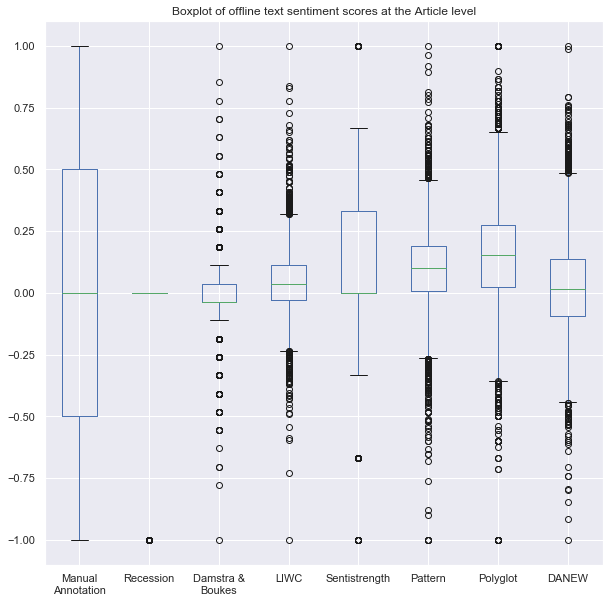

In [53]:
standardized = analyze.compare_sentiment_means(article_data[~article_data.online].loc[:,["text_gold"]+text_order],field='text')
plot=standardized.drop('ID',1).plot(
    kind='box',
    figsize=(10,10),
    title="Boxplot of offline text sentiment scores at the Article level"
    )
plot.set_xticklabels(['Manual\nAnnotation','Recession','Damstra &\nBoukes','LIWC','Sentistrength','Pattern','Polyglot','DANEW'])

In [54]:
standardized.describe().T

,count,mean,std,min,25%,50%,75%,max
text_gold,1171.0,0.039710,0.759500,-1.0,-0.500000,0.000000,0.500000,1.0
text_recessie,4845.0,-0.025387,0.157314,-1.0,0.000000,0.000000,0.000000,0.0
text_boukes,4845.0,-0.022345,0.110176,-1.0,-0.037037,-0.037037,0.037037,1.0
text_LIWC,4845.0,0.043240,0.128122,-1.0,-0.027655,0.037611,0.111726,1.0
text_sentistrength,4845.0,0.094530,0.325195,-1.0,0.000000,0.000000,0.333333,1.0
text_pattern,4845.0,0.095379,0.169540,-1.0,0.008990,0.100800,0.191111,1.0
text_polyglot,4845.0,0.154886,0.224861,-1.0,0.023256,0.152174,0.276316,1.0
text_DANEW,4845.0,0.026006,0.193835,-1.0,-0.094426,0.017481,0.137607,1.0
ID,4845.0,2422.000000,1398.775357,0.0,1211.000000,2422.000000,3633.000000,4844.0


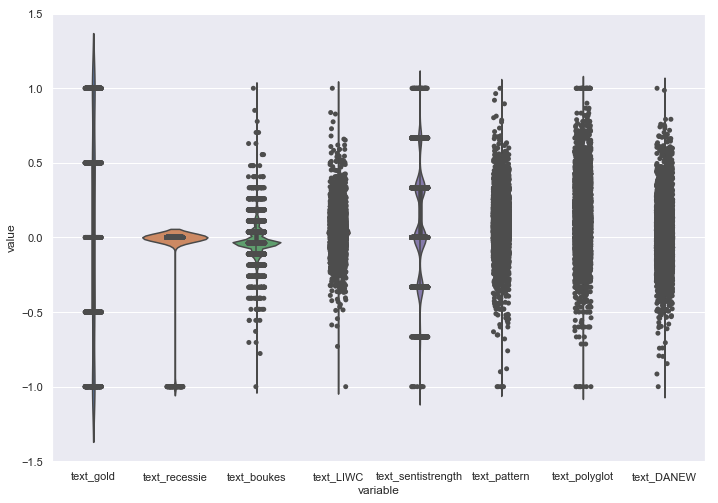

In [55]:
seaborn.violinplot(x="variable", y="value",data=standardized.drop('ID',1).melt())
seaborn.stripplot(x="variable", y="value",data=standardized.drop('ID',1).melt(),color=".3",jitter=True)

### Quality of models

In [56]:
analyze.check_quality(article_data,'title').loc[title_order,:]

/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1
,precision,precision,precision,precision,recall,recall,recall,recall,f1,f1,f1,f1,support,support,support,support,n_predicted,n_predicted,n_predicted
title_recessie,0.33,0.43,0.00,0.30,0.00,1.00,0.00,0.43,0.00,0.60,0.00,0.26,1524,2008,1108,4640,6,4634,0
title_boukes,0.62,0.44,0.53,0.52,0.04,0.96,0.08,0.45,0.08,0.60,0.14,0.32,1524,2008,1108,4640,99,4366,175
title_LIWC,0.62,0.46,0.52,0.53,0.19,0.86,0.20,0.48,0.29,0.60,0.29,0.42,1524,2008,1108,4640,471,3750,419
title_sentistrength,0.45,0.45,0.42,0.45,0.34,0.70,0.14,0.45,0.39,0.55,0.22,0.42,1524,2008,1108,4640,1158,3103,379
title_pattern,0.48,0.45,0.39,0.45,0.22,0.74,0.24,0.45,0.30,0.56,0.30,0.41,1524,2008,1108,4640,692,3260,688
title_polyglot,0.48,0.45,0.37,0.44,0.37,0.50,0.42,0.44,0.42,0.47,0.39,0.43,1524,2008,1108,4640,1158,2231,1251
title_DANEW,0.52,0.46,0.37,0.46,0.27,0.63,0.35,0.45,0.36,0.53,0.36,0.43,1524,2008,1108,4640,794,2776,1070


In [57]:
analyze.check_quality(article_data,'text').loc[text_order,:]

/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1
,precision,precision,precision,precision,recall,recall,recall,recall,f1,f1,f1,f1,support,support,support,support,n_predicted,n_predicted,n_predicted
text_recessie,0.30,0.09,0.00,0.13,0.03,0.95,0.00,0.10,0.05,0.16,0.00,0.04,594,130,702,1426,56,1370,0
text_boukes,0.62,0.09,0.72,0.62,0.22,0.61,0.30,0.29,0.32,0.15,0.42,0.36,594,130,702,1426,213,923,290
text_LIWC,0.66,0.10,0.72,0.64,0.46,0.51,0.39,0.43,0.54,0.17,0.50,0.49,594,130,702,1426,409,641,376
text_sentistrength,0.57,0.09,0.56,0.52,0.26,0.39,0.47,0.37,0.36,0.14,0.51,0.41,594,130,702,1426,270,574,582
text_pattern,0.46,0.10,0.57,0.48,0.30,0.48,0.33,0.33,0.36,0.16,0.42,0.37,594,130,702,1426,383,631,412
text_polyglot,0.58,0.10,0.68,0.58,0.40,0.47,0.39,0.40,0.47,0.16,0.49,0.45,594,130,702,1426,408,616,402
text_DANEW,0.52,0.11,0.61,0.52,0.38,0.49,0.33,0.37,0.44,0.17,0.43,0.41,594,130,702,1426,433,609,384


### Correlations of results

In [58]:
analyze.correlation_tests(article_data,'title').loc[['title_gold']+title_order,['title_gold']+title_order]

/Users/theo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,title_gold,title_recessie,title_boukes,title_LIWC,title_sentistrength,title_pattern,title_polyglot,title_DANEW
title_gold,1.00 ***,nan,0.16 ***,0.30 ***,0.24 ***,0.22 ***,0.30 ***,0.24 ***
title_recessie,nan,nan,nan,nan,nan,nan,nan,nan
title_boukes,0.16 ***,nan,1.00 ***,0.16 ***,0.08 **,-0.00,0.19 ***,0.04
title_LIWC,0.30 ***,nan,0.16 ***,1.00 ***,0.26 ***,0.30 ***,0.32 ***,0.43 ***
title_sentistrength,0.24 ***,nan,0.08 **,0.26 ***,1.00 ***,0.22 ***,0.37 ***,0.33 ***
title_pattern,0.22 ***,nan,-0.00,0.30 ***,0.22 ***,1.00 ***,0.26 ***,0.23 ***
title_polyglot,0.30 ***,nan,0.19 ***,0.32 ***,0.37 ***,0.26 ***,1.00 ***,0.32 ***
title_DANEW,0.24 ***,nan,0.04,0.43 ***,0.33 ***,0.23 ***,0.32 ***,1.00 ***


In [59]:
analyze.correlation_tests(article_data,'text').loc[['text_gold']+text_order,['text_gold']+text_order]

,text_gold,text_recessie,text_boukes,text_LIWC,text_sentistrength,text_pattern,text_polyglot,text_DANEW
text_gold,1.00 ***,-0.06 *,0.27 ***,0.39 ***,0.17 ***,0.13 ***,0.26 ***,0.15 ***
text_recessie,-0.06 *,1.00 ***,-0.16 ***,0.02,-0.01,-0.02,0.05,0.06 *
text_boukes,0.27 ***,-0.16 ***,1.00 ***,0.27 ***,0.10 ***,0.04,0.17 ***,0.05
text_LIWC,0.39 ***,0.02,0.27 ***,1.00 ***,0.18 ***,0.28 ***,0.41 ***,0.36 ***
text_sentistrength,0.17 ***,-0.01,0.10 ***,0.18 ***,1.00 ***,0.12 ***,0.21 ***,0.18 ***
text_pattern,0.13 ***,-0.02,0.04,0.28 ***,0.12 ***,1.00 ***,0.30 ***,0.29 ***
text_polyglot,0.26 ***,0.05,0.17 ***,0.41 ***,0.21 ***,0.30 ***,1.00 ***,0.37 ***
text_DANEW,0.15 ***,0.06 *,0.05,0.36 ***,0.18 ***,0.29 ***,0.37 ***,1.00 ***


### article-level correlations in online publications

In [60]:
analyze.correlation_tests(article_data[article_data.online],'title').loc[['title_gold']+title_order,['title_gold']+title_order]

/Users/theo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,title_gold,title_recessie,title_boukes,title_LIWC,title_sentistrength,title_pattern,title_polyglot,title_DANEW
title_gold,1.00 ***,nan,0.24 ***,0.36 ***,0.25 ***,0.29 ***,0.29 ***,0.30 ***
title_recessie,nan,nan,nan,nan,nan,nan,nan,nan
title_boukes,0.24 ***,nan,1.00 ***,0.29 ***,0.09,0.05,0.12,0.00
title_LIWC,0.36 ***,nan,0.29 ***,1.00 ***,0.32 ***,0.33 ***,0.35 ***,0.31 ***
title_sentistrength,0.25 ***,nan,0.09,0.32 ***,1.00 ***,0.29 ***,0.32 ***,0.45 ***
title_pattern,0.29 ***,nan,0.05,0.33 ***,0.29 ***,1.00 ***,0.20 **,0.22 **
title_polyglot,0.29 ***,nan,0.12,0.35 ***,0.32 ***,0.20 **,1.00 ***,0.32 ***
title_DANEW,0.30 ***,nan,0.00,0.31 ***,0.45 ***,0.22 **,0.32 ***,1.00 ***


In [61]:
article_data.title_recessie[article_data.online].describe()

count    961.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: title_recessie, dtype: float64

### article-level correlations in offline publications

In [62]:
analyze.correlation_tests(article_data[~article_data.online],'title').loc[['title_gold']+title_order,['title_gold']+title_order]

/Users/theo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,title_gold,title_recessie,title_boukes,title_LIWC,title_sentistrength,title_pattern,title_polyglot,title_DANEW
title_gold,1.00 ***,nan,0.14 ***,0.28 ***,0.24 ***,0.20 ***,0.31 ***,0.22 ***
title_recessie,nan,nan,nan,nan,nan,nan,nan,nan
title_boukes,0.14 ***,nan,1.00 ***,0.13 ***,0.07 *,-0.02,0.20 ***,0.04
title_LIWC,0.28 ***,nan,0.13 ***,1.00 ***,0.25 ***,0.29 ***,0.31 ***,0.45 ***
title_sentistrength,0.24 ***,nan,0.07 *,0.25 ***,1.00 ***,0.20 ***,0.37 ***,0.31 ***
title_pattern,0.20 ***,nan,-0.02,0.29 ***,0.20 ***,1.00 ***,0.27 ***,0.23 ***
title_polyglot,0.31 ***,nan,0.20 ***,0.31 ***,0.37 ***,0.27 ***,1.00 ***,0.32 ***
title_DANEW,0.22 ***,nan,0.04,0.45 ***,0.31 ***,0.23 ***,0.32 ***,1.00 ***


Text(0.5,1,'Correlation heatmap of title sentiment scores at the article level')

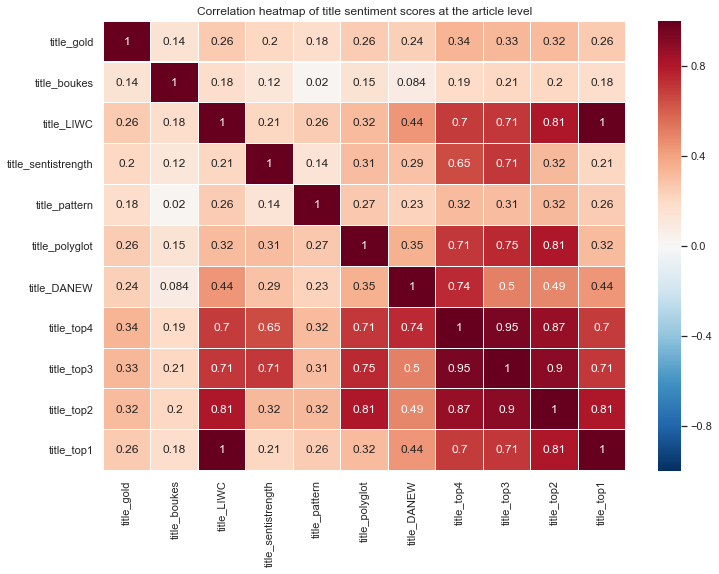

In [63]:
corplot(analyze.correlate_results(article_data.drop("title_recessie",axis=1),'title'),"Correlation heatmap of title sentiment scores at the article level")

In [64]:
analyze.correlation_tests(article_data,'text').loc[['text_gold']+text_order,['text_gold']+text_order]

,text_gold,text_recessie,text_boukes,text_LIWC,text_sentistrength,text_pattern,text_polyglot,text_DANEW
text_gold,1.00 ***,-0.06 *,0.27 ***,0.39 ***,0.17 ***,0.13 ***,0.26 ***,0.15 ***
text_recessie,-0.06 *,1.00 ***,-0.16 ***,0.02,-0.01,-0.02,0.05,0.06 *
text_boukes,0.27 ***,-0.16 ***,1.00 ***,0.27 ***,0.10 ***,0.04,0.17 ***,0.05
text_LIWC,0.39 ***,0.02,0.27 ***,1.00 ***,0.18 ***,0.28 ***,0.41 ***,0.36 ***
text_sentistrength,0.17 ***,-0.01,0.10 ***,0.18 ***,1.00 ***,0.12 ***,0.21 ***,0.18 ***
text_pattern,0.13 ***,-0.02,0.04,0.28 ***,0.12 ***,1.00 ***,0.30 ***,0.29 ***
text_polyglot,0.26 ***,0.05,0.17 ***,0.41 ***,0.21 ***,0.30 ***,1.00 ***,0.37 ***
text_DANEW,0.15 ***,0.06 *,0.05,0.36 ***,0.18 ***,0.29 ***,0.37 ***,1.00 ***


### Article-level body online correlations

In [65]:
analyze.correlation_tests(article_data[article_data.online],'text').loc[['text_gold']+text_order,['text_gold']+text_order]

,text_gold,text_recessie,text_boukes,text_LIWC,text_sentistrength,text_pattern,text_polyglot,text_DANEW
text_gold,1.00 ***,-0.07,0.33 ***,0.52 ***,0.28 ***,0.10,0.29 ***,0.31 ***
text_recessie,-0.07,1.00 ***,-0.05,-0.02,0.12,-0.02,0.12,0.04
text_boukes,0.33 ***,-0.05,1.00 ***,0.31 ***,0.31 ***,-0.01,0.26 ***,-0.06
text_LIWC,0.52 ***,-0.02,0.31 ***,1.00 ***,0.24 ***,0.28 ***,0.41 ***,0.36 ***
text_sentistrength,0.28 ***,0.12,0.31 ***,0.24 ***,1.00 ***,0.04,0.34 ***,0.22 **
text_pattern,0.10,-0.02,-0.01,0.28 ***,0.04,1.00 ***,0.28 ***,0.35 ***
text_polyglot,0.29 ***,0.12,0.26 ***,0.41 ***,0.34 ***,0.28 ***,1.00 ***,0.33 ***
text_DANEW,0.31 ***,0.04,-0.06,0.36 ***,0.22 **,0.35 ***,0.33 ***,1.00 ***


### Article-level body offline correlations

In [66]:
analyze.correlation_tests(article_data[~article_data.online],'text').loc[['text_gold']+text_order,['text_gold']+text_order]

,text_gold,text_recessie,text_boukes,text_LIWC,text_sentistrength,text_pattern,text_polyglot,text_DANEW
text_gold,1.00 ***,-0.06 *,0.26 ***,0.36 ***,0.15 ***,0.14 ***,0.25 ***,0.11 ***
text_recessie,-0.06 *,1.00 ***,-0.18 ***,0.03,-0.04,-0.02,0.04,0.06 *
text_boukes,0.26 ***,-0.18 ***,1.00 ***,0.26 ***,0.06,0.05,0.15 ***,0.07 *
text_LIWC,0.36 ***,0.03,0.26 ***,1.00 ***,0.17 ***,0.28 ***,0.41 ***,0.37 ***
text_sentistrength,0.15 ***,-0.04,0.06,0.17 ***,1.00 ***,0.13 ***,0.19 ***,0.17 ***
text_pattern,0.14 ***,-0.02,0.05,0.28 ***,0.13 ***,1.00 ***,0.31 ***,0.28 ***
text_polyglot,0.25 ***,0.04,0.15 ***,0.41 ***,0.19 ***,0.31 ***,1.00 ***,0.39 ***
text_DANEW,0.11 ***,0.06 *,0.07 *,0.37 ***,0.17 ***,0.28 ***,0.39 ***,1.00 ***


## Comparison table

In [67]:
online_full  = analyze.correlation_tests(article_data[article_data.online],'text').loc[['text_gold']+text_order,['text_gold']+text_order].text_gold
online_head  = analyze.correlation_tests(article_data[article_data.online],'title').loc[['title_gold']+title_order,['title_gold']+title_order].title_gold
offline_full = analyze.correlation_tests(article_data[~article_data.online],'text').loc[['text_gold']+text_order,['text_gold']+text_order].text_gold
offline_head = analyze.correlation_tests(article_data[~article_data.online],'title').loc[['title_gold']+title_order,['title_gold']+title_order].title_gold
overall_full = analyze.correlation_tests(article_data,'text').loc[['text_gold']+text_order,['text_gold']+text_order].text_gold
overall_head = analyze.correlation_tests(article_data,'title').loc[['title_gold']+title_order,['title_gold']+title_order].title_gold

online_full.index = ["Human"] + tool_order
offline_full.index = ["Human"] + tool_order
offline_head.index = ["Human"] + tool_order
online_head.index = ["Human"] + tool_order
overall_head.index = ["Human"] + tool_order
overall_full.index = ["Human"] + tool_order

compared_cors = pandas.DataFrame({
        "online_fulltext" : online_full,
        "online_headline" : online_head,
        "offline_fulltext": offline_full,
        "offline_headline": offline_head,
        "all_fulltext"    : overall_full,
        "all_headline"    : overall_head
    })
compared_cors

/Users/theo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,online_fulltext,online_headline,offline_fulltext,offline_headline,all_fulltext,all_headline
Human,1.00 ***,1.00 ***,1.00 ***,1.00 ***,1.00 ***,1.00 ***
recessie,-0.07,nan,-0.06 *,nan,-0.06 *,nan
boukes,0.33 ***,0.24 ***,0.26 ***,0.14 ***,0.27 ***,0.16 ***
LIWC,0.52 ***,0.36 ***,0.36 ***,0.28 ***,0.39 ***,0.30 ***
sentistrength,0.28 ***,0.25 ***,0.15 ***,0.24 ***,0.17 ***,0.24 ***
pattern,0.10,0.29 ***,0.14 ***,0.20 ***,0.13 ***,0.22 ***
polyglot,0.29 ***,0.29 ***,0.25 ***,0.31 ***,0.26 ***,0.30 ***
DANEW,0.31 ***,0.30 ***,0.11 ***,0.22 ***,0.15 ***,0.24 ***


In [68]:
av_h, av_f = [], []
for classifier, headline, fulltext in zip(compared_cors.index, compared_cors.all_headline,compared_cors.all_fulltext):
    to_num = lambda x: float(x.replace('*','').strip())
    c_compare = analyze.cor_compare(to_num(headline), to_num(fulltext), len(data[article_data.text_gold.isnull()]), len(data[article_data.title_gold.isnull()]))
    av_h.append(to_num(headline))
    av_f.append(to_num(fulltext))
    print(classifier, round(c_compare['cordiff'],2), c_compare['p_value'])
print("average", numpy.nanmean(av_h),numpy.nanmean(av_f),analyze.cor_compare(numpy.nanmean(av_h),numpy.nanmean(av_f), len(data[article_data.text_gold.isnull()]), len(data[article_data.title_gold.isnull()]))['p_value'])

Human 0.0 nan
recessie nan nan
boukes -0.11 0.0018
LIWC -0.09 0.0048
sentistrength 0.07 0.0354
pattern 0.09 0.0094
polyglot 0.04 0.1934
DANEW 0.09 0.0089
average 0.3514285714285714 0.28875 0.0433


/Users/theo/Documents/GitHub/economic_sentiment/scripts_r1/analyze.py:474: RuntimeWarning: divide by zero encountered in log
  za = (numpy.log(raplus)-numpy.log(raminus))/2
/Users/theo/Documents/GitHub/economic_sentiment/scripts_r1/analyze.py:475: RuntimeWarning: divide by zero encountered in log
  zb = (numpy.log(rbplus)-numpy.log(rbminus))/2
/Users/theo/Documents/GitHub/economic_sentiment/scripts_r1/analyze.py:481: RuntimeWarning: invalid value encountered in double_scalars
  z = (za-zb)/se


Text(0.5,1,'Correlation heatmap of text sentiment scores at the article level')

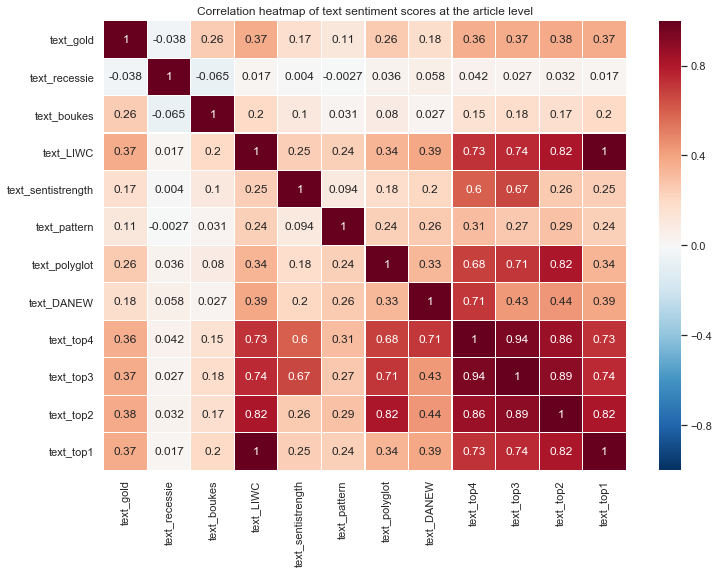

In [69]:
seaborn.heatmap(analyze.correlate_results(article_data,'text'), linewidth=.1, annot=True,cmap='RdBu_r',vmin=-1).set_title(
"Correlation heatmap of text sentiment scores at the article level")

### Correlations of errors

In [70]:
analyze.correlation_tests(article_data, 'title', errors=True)


,title_recessie_err,title_boukes_err,title_LIWC_err,title_sentistrength_err,title_pattern_err,title_polyglot_err,title_DANEW_err,title_top4_err,title_top3_err,title_top2_err,title_top1_err
title_DANEW_err,0.90 ***,0.76 ***,0.12 ***,0.37 ***,0.82 ***,0.27 ***,1.00 ***,0.52 ***,0.39 ***,0.37 ***,0.52 ***
title_LIWC_err,0.18 ***,0.11 ***,1.00 ***,0.11 ***,0.10 ***,-0.05,0.12 ***,0.20 ***,0.19 ***,0.35 ***,0.68 ***
title_boukes_err,0.84 ***,1.00 ***,0.11 ***,0.34 ***,0.72 ***,0.23 ***,0.76 ***,0.35 ***,0.33 ***,0.35 ***,0.47 ***
title_pattern_err,0.86 ***,0.72 ***,0.10 ***,0.40 ***,1.00 ***,0.25 ***,0.82 ***,0.40 ***,0.37 ***,0.35 ***,0.51 ***
title_polyglot_err,0.19 ***,0.23 ***,-0.05,0.21 ***,0.25 ***,1.00 ***,0.27 ***,0.60 ***,0.67 ***,0.74 ***,0.16 ***
title_recessie_err,1.00 ***,0.84 ***,0.18 ***,0.39 ***,0.86 ***,0.19 ***,0.90 ***,0.36 ***,0.32 ***,0.32 ***,0.53 ***
title_sentistrength_err,0.39 ***,0.34 ***,0.11 ***,1.00 ***,0.40 ***,0.21 ***,0.37 ***,0.55 ***,0.60 ***,0.31 ***,0.34 ***
title_top1_err,0.53 ***,0.47 ***,0.68 ***,0.34 ***,0.51 ***,0.16 ***,0.52 ***,0.58 ***,0.55 ***,0.65 ***,1.00 ***
title_top2_err,0.32 ***,0.35 ***,0.35 ***,0.31 ***,0.35 ***,0.74 ***,0.37 ***,0.78 ***,0.84 ***,1.00 ***,0.65 ***
title_top3_err,0.32 ***,0.33 ***,0.19 ***,0.60 ***,0.37 ***,0.67 ***,0.39 ***,0.92 ***,1.00 ***,0.84 ***,0.55 ***


Text(0.5,1,'Heatmap of Article-level title error correlation coefficients')

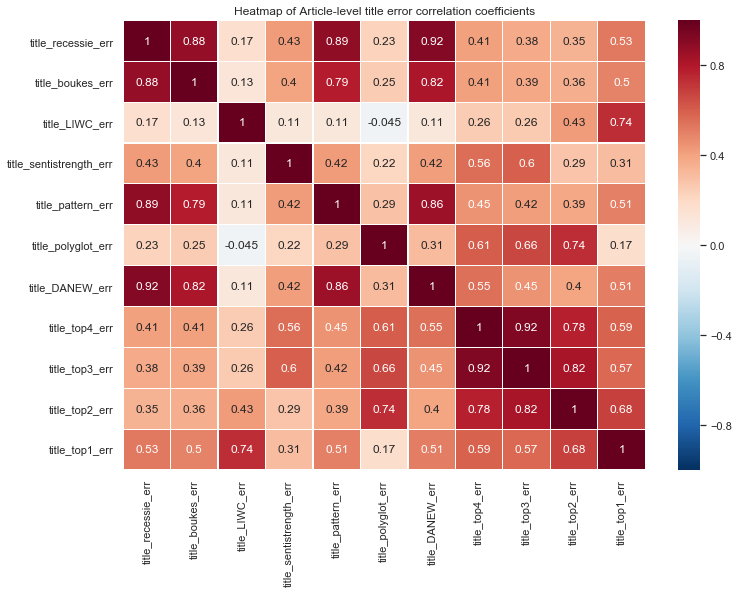

In [71]:
corplot(analyze.correlate_results(article_data,'title',errors=True),"Heatmap of Article-level title error correlation coefficients")

In [72]:
analyze.correlation_tests(article_data, 'text',errors=True)

,text_recessie_err,text_boukes_err,text_LIWC_err,text_sentistrength_err,text_pattern_err,text_polyglot_err,text_DANEW_err,text_top4_err,text_top3_err,text_top2_err,text_top1_err
text_DANEW_err,0.95 ***,0.24 ***,0.36 ***,0.32 ***,0.99 ***,0.93 ***,1.00 ***,0.64 ***,0.61 ***,0.55 ***,0.44 ***
text_LIWC_err,0.33 ***,0.18 ***,1.00 ***,0.11 ***,0.37 ***,0.39 ***,0.36 ***,0.57 ***,0.60 ***,0.74 ***,0.98 ***
text_boukes_err,0.23 ***,1.00 ***,0.18 ***,0.03,0.24 ***,0.26 ***,0.24 ***,0.21 ***,0.23 ***,0.21 ***,0.20 ***
text_pattern_err,0.94 ***,0.24 ***,0.37 ***,0.33 ***,1.00 ***,0.93 ***,0.99 ***,0.65 ***,0.62 ***,0.56 ***,0.45 ***
text_polyglot_err,0.86 ***,0.26 ***,0.39 ***,0.23 ***,0.93 ***,1.00 ***,0.93 ***,0.75 ***,0.74 ***,0.70 ***,0.47 ***
text_recessie_err,1.00 ***,0.23 ***,0.33 ***,0.36 ***,0.94 ***,0.86 ***,0.95 ***,0.60 ***,0.57 ***,0.52 ***,0.41 ***
text_sentistrength_err,0.36 ***,0.03,0.11 ***,1.00 ***,0.33 ***,0.23 ***,0.32 ***,0.46 ***,0.50 ***,0.24 ***,0.16 ***
text_top1_err,0.41 ***,0.20 ***,0.98 ***,0.16 ***,0.45 ***,0.47 ***,0.44 ***,0.65 ***,0.68 ***,0.79 ***,1.00 ***
text_top2_err,0.52 ***,0.21 ***,0.74 ***,0.24 ***,0.56 ***,0.70 ***,0.55 ***,0.86 ***,0.89 ***,1.00 ***,0.79 ***
text_top3_err,0.57 ***,0.23 ***,0.60 ***,0.50 ***,0.62 ***,0.74 ***,0.61 ***,0.95 ***,1.00 ***,0.89 ***,0.68 ***


Text(0.5,1,'Heatmap of Article-level text error correlation coefficients')

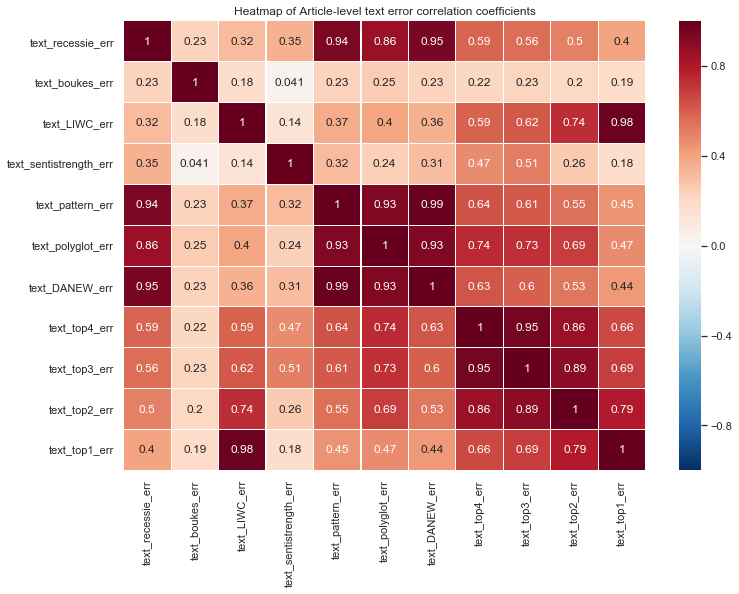

In [73]:
corplot(analyze.correlate_results(article_data,'text',errors=True),"Heatmap of Article-level text error correlation coefficients")

## Daily-level

### Distributions

       title_gold  title_recessie  title_boukes  title_LIWC  \
count  110.000000      110.000000    110.000000  110.000000   
mean    -0.110693       -0.000796     -0.194718   -0.136722   
std      0.332217        0.003366      0.325250    0.443998   
min     -1.000000       -0.017544     -1.000000   -1.000000   
25%     -0.293478        0.000000     -0.379324   -0.437812   
50%     -0.079666        0.000000     -0.280000   -0.126954   
75%      0.086957        0.000000      0.002667    0.185108   
max      1.000000        0.000000      1.000000    1.000000   

       title_sentistrength  title_pattern  title_polyglot  title_DANEW  \
count           110.000000     110.000000      110.000000   110.000000   
mean             -0.202938      -0.042773        0.132733     0.038188   
std               0.275996       0.392208        0.349356     0.318106   
min              -1.000000      -1.000000       -1.000000    -1.000000   
25%              -0.347540      -0.294413       -0.085115    -

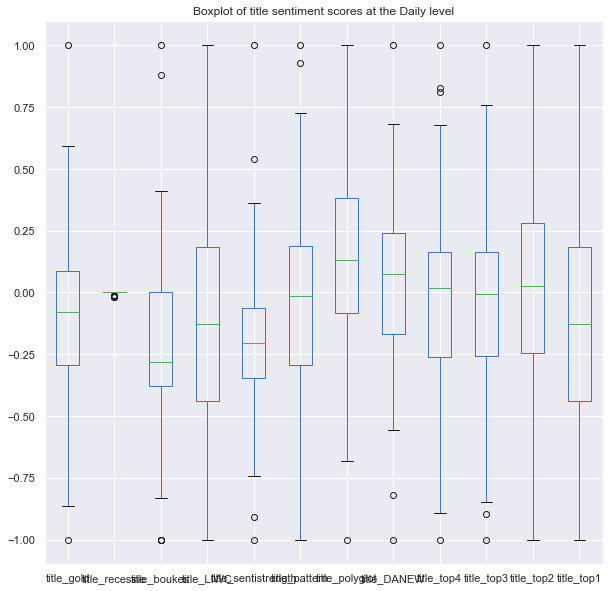

In [74]:
standardized = analyze.compare_sentiment_means(daily_data,field='title')
standardized.drop('ID',1).plot(kind='box',figsize=(10,10),title="Boxplot of title sentiment scores at the Daily level")

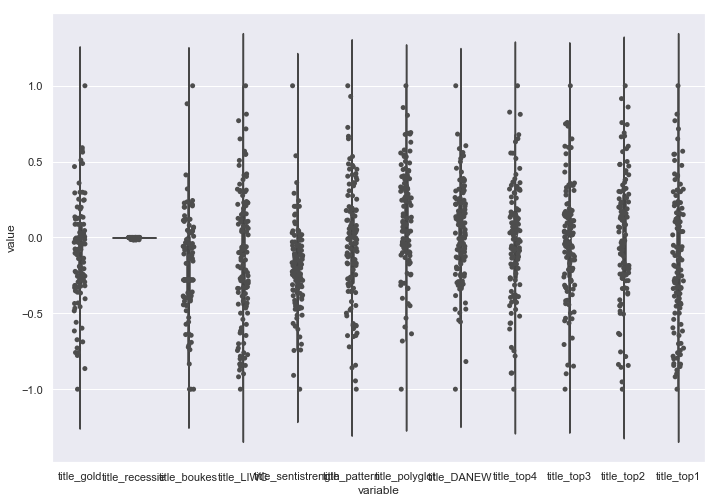

In [75]:
seaborn.violinplot(x="variable", y="value",data=standardized.drop('ID',1).melt())
seaborn.stripplot(x="variable", y="value",data=standardized.drop('ID',1).melt(),color=".3",jitter=True)

        text_gold  text_recessie  text_boukes   text_LIWC  text_sentistrength  \
count  109.000000     110.000000   110.000000  110.000000          110.000000   
mean     0.196386      -0.025253    -0.215867   -0.246583            0.080418   
std      0.424008       0.025959     0.299716    0.395083            0.368870   
min     -1.000000      -0.100000    -1.000000   -1.000000           -1.000000   
25%     -0.058824      -0.040021    -0.378456   -0.523705           -0.127371   
50%      0.197279      -0.018772    -0.223010   -0.276371            0.100312   
75%      0.523810       0.000000    -0.045144   -0.019018            0.333536   
max      1.000000       0.000000     1.000000    1.000000            1.000000   

       text_pattern  text_polyglot  text_DANEW   text_top4   text_top3  \
count    110.000000     110.000000  110.000000  110.000000  110.000000   
mean      -0.018296       0.124976    0.210060   -0.061513   -0.047962   
std        0.285101       0.398107    0.325725  

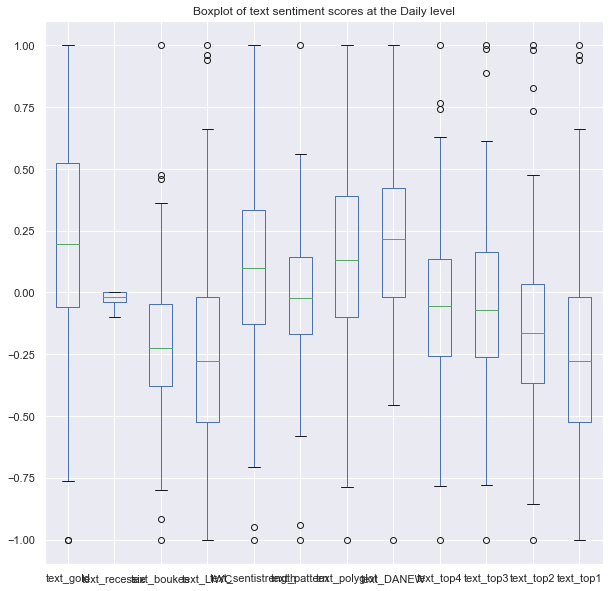

In [76]:
standardized = analyze.compare_sentiment_means(daily_data,field='text')
standardized.drop('ID',1).plot(kind='box',figsize=(10,10),title="Boxplot of text sentiment scores at the Daily level")

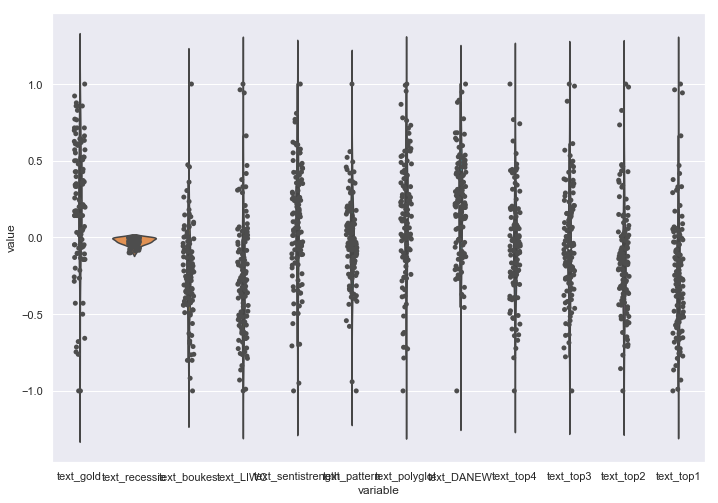

In [77]:
seaborn.violinplot(x="variable", y="value",data=standardized.drop('ID',1).melt())
seaborn.stripplot(x="variable", y="value",data=standardized.drop('ID',1).melt(),color=".3",jitter=True)

### Quality of models

In [78]:
analyze.check_quality(daily_data,'title').loc[title_order,:]

/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1
,precision,precision,precision,precision,recall,recall,recall,recall,f1,f1,f1,f1,support,support,support,support,n_predicted,n_predicted,n_predicted
title_recessie,0.17,0.44,0.00,0.25,0.03,0.92,0.00,0.43,0.05,0.60,0.00,0.29,31,50,29,110,6,104,0
title_boukes,0.28,0.36,0.26,0.31,0.29,0.34,0.28,0.31,0.29,0.35,0.27,0.31,31,50,29,110,32,47,31
title_LIWC,0.41,0.51,0.35,0.44,0.45,0.40,0.45,0.43,0.43,0.45,0.39,0.43,31,50,29,110,34,39,37
title_sentistrength,0.52,0.62,0.54,0.57,0.48,0.66,0.52,0.57,0.50,0.64,0.53,0.57,31,50,29,110,29,53,28
title_pattern,0.47,0.61,0.34,0.50,0.48,0.56,0.38,0.49,0.48,0.58,0.36,0.49,31,50,29,110,32,46,32
title_polyglot,0.36,0.51,0.43,0.45,0.42,0.38,0.55,0.44,0.39,0.44,0.48,0.44,31,50,29,110,36,37,37
title_DANEW,0.45,0.53,0.35,0.46,0.48,0.46,0.41,0.45,0.47,0.49,0.38,0.46,31,50,29,110,33,43,34


In [79]:
analyze.check_quality(daily_data,'text').loc[text_order,:]

,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1
,precision,precision,precision,precision,recall,recall,recall,recall,f1,f1,f1,f1,support,support,support,support,n_predicted,n_predicted,n_predicted
text_recessie,0.31,0.45,0.34,0.37,0.28,0.46,0.36,0.38,0.30,0.46,0.35,0.37,32,41,36,109,29,42,38
text_boukes,0.38,0.44,0.47,0.43,0.34,0.54,0.39,0.43,0.36,0.48,0.42,0.43,32,41,36,109,29,50,30
text_LIWC,0.39,0.44,0.50,0.45,0.44,0.46,0.42,0.44,0.41,0.45,0.45,0.44,32,41,36,109,36,43,30
text_sentistrength,0.40,0.40,0.32,0.37,0.38,0.46,0.28,0.38,0.39,0.43,0.30,0.37,32,41,36,109,30,48,31
text_pattern,0.21,0.37,0.46,0.35,0.19,0.46,0.36,0.35,0.20,0.41,0.41,0.35,32,41,36,109,29,52,28
text_polyglot,0.43,0.46,0.58,0.49,0.41,0.51,0.53,0.49,0.42,0.48,0.55,0.49,32,41,36,109,30,46,33
text_DANEW,0.38,0.47,0.49,0.45,0.34,0.51,0.47,0.45,0.36,0.49,0.48,0.45,32,41,36,109,29,45,35


### Correlations of results

In [80]:
analyze.correlation_tests(daily_data,'title')

,title_gold,title_recessie,title_boukes,title_LIWC,title_sentistrength,title_pattern,title_polyglot,title_DANEW,title_top4,title_top3,title_top2,title_top1
title_DANEW,0.15,0.10,0.08,0.46 ***,0.53 ***,0.32 ***,0.30 **,1.00 ***,0.75 ***,0.56 ***,0.44 ***,0.46 ***
title_LIWC,0.32 ***,0.16,0.26 **,1.00 ***,0.37 ***,0.30 **,0.39 ***,0.46 ***,0.71 ***,0.71 ***,0.78 ***,1.00 ***
title_boukes,0.23 *,-0.10,1.00 ***,0.26 **,0.22 *,0.07,0.18,0.08,0.25 **,0.28 **,0.26 **,0.26 **
title_gold,1.00 ***,0.05,0.23 *,0.32 ***,0.27 **,0.14,0.44 ***,0.15,0.40 ***,0.45 ***,0.47 ***,0.32 ***
title_pattern,0.14,-0.06,0.07,0.30 **,0.14,1.00 ***,0.41 ***,0.32 ***,0.39 ***,0.36 ***,0.43 ***,0.30 **
title_polyglot,0.44 ***,-0.01,0.18,0.39 ***,0.39 ***,0.41 ***,1.00 ***,0.30 **,0.72 ***,0.79 ***,0.88 ***,0.39 ***
title_recessie,0.05,1.00 ***,-0.10,0.16,0.08,-0.06,-0.01,0.10,0.10,0.09,0.07,0.16
title_sentistrength,0.27 **,0.08,0.22 *,0.37 ***,1.00 ***,0.14,0.39 ***,0.53 ***,0.80 ***,0.80 ***,0.45 ***,0.37 ***
title_top1,0.32 ***,0.16,0.26 **,1.00 ***,0.37 ***,0.30 **,0.39 ***,0.46 ***,0.71 ***,0.71 ***,0.78 ***,1.00 ***
title_top2,0.47 ***,0.07,0.26 **,0.78 ***,0.45 ***,0.43 ***,0.88 ***,0.44 ***,0.85 ***,0.90 ***,1.00 ***,0.78 ***


Text(0.5,1,'Correlation heatmap of title sentiment scores at the daily level')

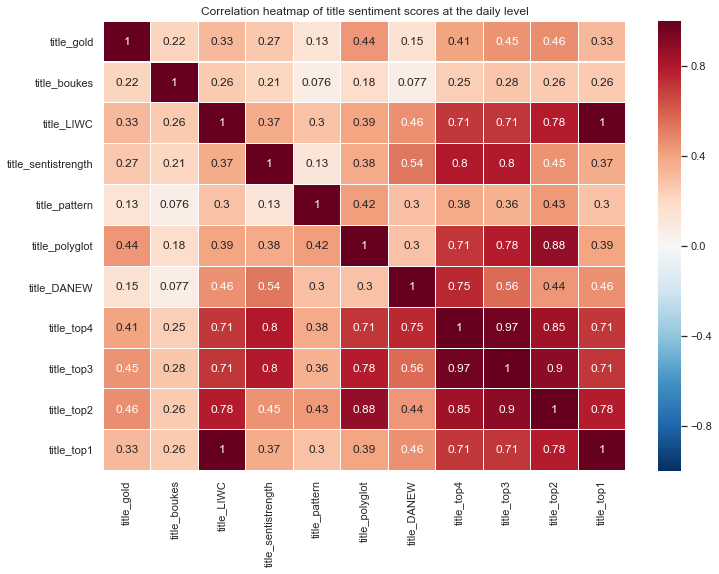

In [81]:
corplot(analyze.correlate_results(daily_data.drop("title_recessie",axis=1),'title'),"Correlation heatmap of title sentiment scores at the daily level")

In [82]:
analyze.correlation_tests(daily_data,'text')

,text_gold,text_recessie,text_boukes,text_LIWC,text_sentistrength,text_pattern,text_polyglot,text_DANEW,text_top4,text_top3,text_top2,text_top1
text_DANEW,0.24 *,0.01,-0.08,0.36 ***,0.27 **,0.17,0.37 ***,1.00 ***,0.72 ***,0.44 ***,0.43 ***,0.36 ***
text_LIWC,0.30 **,-0.04,0.30 **,1.00 ***,0.43 ***,0.21 *,0.45 ***,0.36 ***,0.80 ***,0.85 ***,0.88 ***,1.00 ***
text_boukes,0.21 *,-0.12,1.00 ***,0.30 **,0.21 *,0.12,0.32 ***,-0.08,0.25 **,0.36 ***,0.36 ***,0.30 **
text_gold,1.00 ***,-0.11,0.21 *,0.30 **,0.06,0.17,0.28 **,0.24 *,0.31 ***,0.29 **,0.34 ***,0.30 **
text_pattern,0.17,-0.09,0.12,0.21 *,-0.05,1.00 ***,0.19 *,0.17,0.19 *,0.16,0.24 *,0.21 *
text_polyglot,0.28 **,-0.06,0.32 ***,0.45 ***,0.24 *,0.19 *,1.00 ***,0.37 ***,0.70 ***,0.72 ***,0.81 ***,0.45 ***
text_recessie,-0.11,1.00 ***,-0.12,-0.04,0.03,-0.09,-0.06,0.01,-0.02,-0.03,-0.06,-0.04
text_sentistrength,0.06,0.03,0.21 *,0.43 ***,1.00 ***,-0.05,0.24 *,0.27 **,0.66 ***,0.72 ***,0.41 ***,0.43 ***
text_top1,0.30 **,-0.04,0.30 **,1.00 ***,0.43 ***,0.21 *,0.45 ***,0.36 ***,0.80 ***,0.85 ***,0.88 ***,1.00 ***
text_top2,0.34 ***,-0.06,0.36 ***,0.88 ***,0.41 ***,0.24 *,0.81 ***,0.43 ***,0.88 ***,0.93 ***,1.00 ***,0.88 ***


Text(0.5,1,'Correlation heatmap of text sentiment scores at the article level')

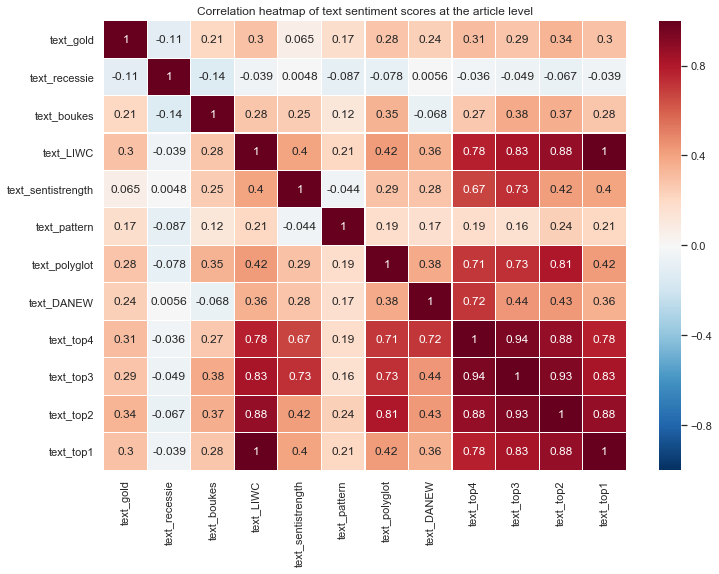

In [83]:
corplot(analyze.correlate_results(daily_data,'text'),"Correlation heatmap of text sentiment scores at the article level")

### Correlations of errors

In [84]:
analyze.correlation_tests(daily_data, 'title', errors=True)

,title_recessie_err,title_boukes_err,title_LIWC_err,title_sentistrength_err,title_pattern_err,title_polyglot_err,title_DANEW_err,title_top4_err,title_top3_err,title_top2_err,title_top1_err
title_DANEW_err,0.93 ***,0.91 ***,0.09,-0.02,0.92 ***,0.63 ***,1.00 ***,0.69 ***,0.63 ***,0.59 ***,0.59 ***
title_LIWC_err,0.13,0.09,1.00 ***,0.04,0.15,0.10,0.09,0.10,0.12,0.19 *,0.18
title_boukes_err,0.93 ***,1.00 ***,0.09,0.03,0.91 ***,0.56 ***,0.91 ***,0.61 ***,0.59 ***,0.56 ***,0.58 ***
title_pattern_err,0.97 ***,0.91 ***,0.15,0.06,1.00 ***,0.62 ***,0.92 ***,0.64 ***,0.60 ***,0.58 ***,0.56 ***
title_polyglot_err,0.57 ***,0.56 ***,0.10,-0.05,0.62 ***,1.00 ***,0.63 ***,0.70 ***,0.75 ***,0.85 ***,0.44 ***
title_recessie_err,1.00 ***,0.93 ***,0.13,0.08,0.97 ***,0.57 ***,0.93 ***,0.61 ***,0.57 ***,0.53 ***,0.54 ***
title_sentistrength_err,0.08,0.03,0.04,1.00 ***,0.06,-0.05,-0.02,0.24 *,0.21 *,0.08,0.03
title_top1_err,0.54 ***,0.58 ***,0.18,0.03,0.56 ***,0.44 ***,0.59 ***,0.73 ***,0.71 ***,0.75 ***,1.00 ***
title_top2_err,0.53 ***,0.56 ***,0.19 *,0.08,0.58 ***,0.85 ***,0.59 ***,0.83 ***,0.87 ***,1.00 ***,0.75 ***
title_top3_err,0.57 ***,0.59 ***,0.12,0.21 *,0.60 ***,0.75 ***,0.63 ***,0.96 ***,1.00 ***,0.87 ***,0.71 ***


Text(0.5,1,'Heatmap of Daily-level title error correlation coefficients')

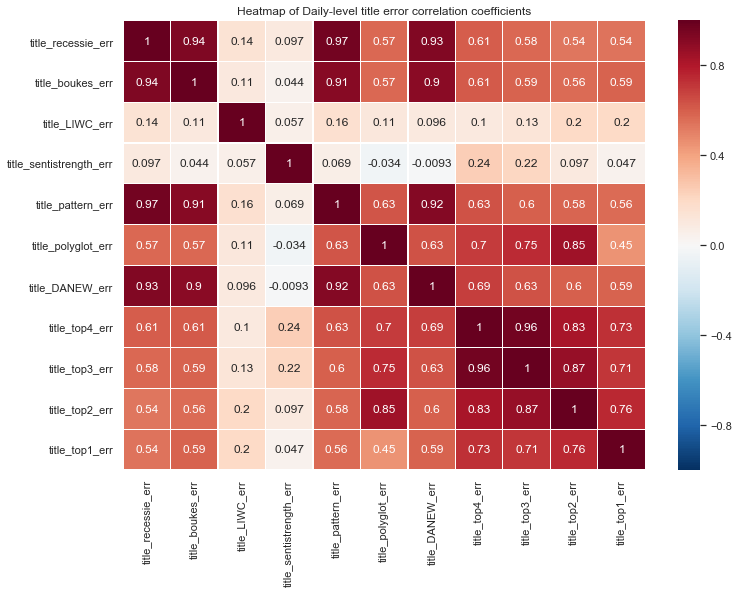

In [85]:
corplot(analyze.correlate_results(daily_data,'title',errors=True),"Heatmap of Daily-level title error correlation coefficients")

In [86]:
analyze.correlation_tests(daily_data, 'text',errors=True)

,text_recessie_err,text_boukes_err,text_LIWC_err,text_sentistrength_err,text_pattern_err,text_polyglot_err,text_DANEW_err,text_top4_err,text_top3_err,text_top2_err,text_top1_err
text_DANEW_err,0.99 ***,0.83 ***,0.90 ***,0.37 ***,1.00 ***,0.97 ***,1.00 ***,0.96 ***,0.96 ***,0.95 ***,0.92 ***
text_LIWC_err,0.89 ***,0.82 ***,1.00 ***,0.34 ***,0.90 ***,0.89 ***,0.90 ***,0.95 ***,0.95 ***,0.96 ***,0.99 ***
text_boukes_err,0.79 ***,1.00 ***,0.82 ***,0.14,0.83 ***,0.88 ***,0.83 ***,0.80 ***,0.82 ***,0.81 ***,0.79 ***
text_pattern_err,0.99 ***,0.83 ***,0.90 ***,0.38 ***,1.00 ***,0.96 ***,1.00 ***,0.96 ***,0.96 ***,0.95 ***,0.92 ***
text_polyglot_err,0.92 ***,0.88 ***,0.89 ***,0.18,0.96 ***,1.00 ***,0.97 ***,0.92 ***,0.92 ***,0.91 ***,0.88 ***
text_recessie_err,1.00 ***,0.79 ***,0.89 ***,0.47 ***,0.99 ***,0.92 ***,0.99 ***,0.96 ***,0.96 ***,0.95 ***,0.92 ***
text_sentistrength_err,0.47 ***,0.14,0.34 ***,1.00 ***,0.38 ***,0.18,0.37 ***,0.46 ***,0.46 ***,0.45 ***,0.44 ***
text_top1_err,0.92 ***,0.79 ***,0.99 ***,0.44 ***,0.92 ***,0.88 ***,0.92 ***,0.97 ***,0.98 ***,0.98 ***,1.00 ***
text_top2_err,0.95 ***,0.81 ***,0.96 ***,0.45 ***,0.95 ***,0.91 ***,0.95 ***,0.99 ***,0.99 ***,1.00 ***,0.98 ***
text_top3_err,0.96 ***,0.82 ***,0.95 ***,0.46 ***,0.96 ***,0.92 ***,0.96 ***,1.00 ***,1.00 ***,0.99 ***,0.98 ***


Text(0.5,1,'Heatmap of Daily-level text error correlation coefficients')

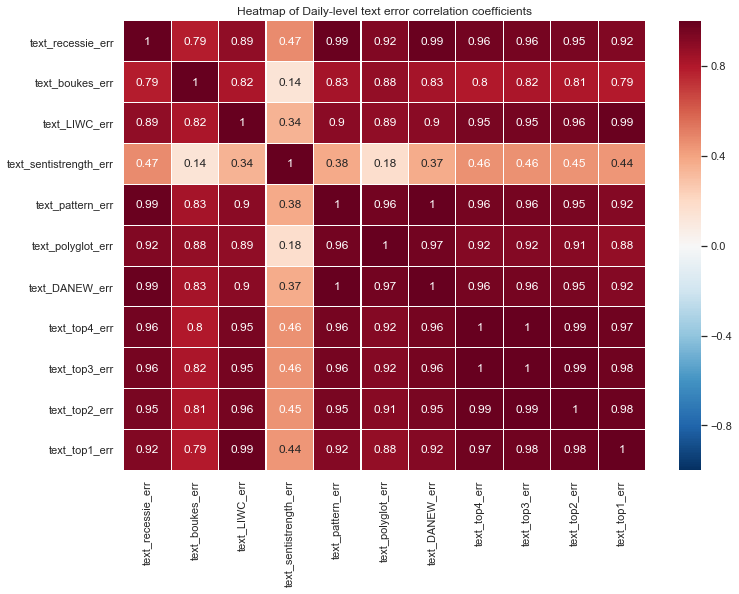

In [87]:
corplot(analyze.correlate_results(daily_data,'text',errors=True),"Heatmap of Daily-level text error correlation coefficients")

## Weekly-level

### Distributions

       title_gold  title_recessie  title_boukes  title_LIWC  \
count   22.000000       22.000000     22.000000   22.000000   
mean    -0.293829       -0.000921     -0.343403   -0.113151   
std      0.473944        0.001567      0.469505    0.469824   
min     -1.000000       -0.004016     -1.000000   -1.000000   
25%     -0.721764       -0.001834     -0.711873   -0.404340   
50%     -0.255070        0.000000     -0.356980   -0.093375   
75%     -0.002767        0.000000     -0.095486    0.160328   
max      1.000000        0.000000      1.000000    1.000000   

       title_sentistrength  title_pattern  title_polyglot  title_DANEW  \
count            22.000000      22.000000       22.000000    22.000000   
mean              0.279435      -0.011477        0.208094     0.117644   
std               0.441219       0.560639        0.566528     0.519270   
min              -1.000000      -1.000000       -1.000000    -1.000000   
25%               0.099366      -0.352924       -0.201189    -

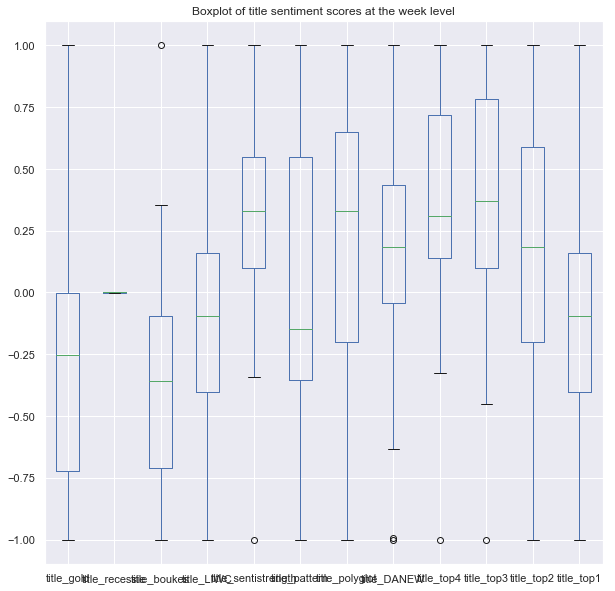

In [88]:
standardized = analyze.compare_sentiment_means(weekly_data,field='title')
standardized.drop('ID',1).plot(kind='box',figsize=(10,10),title="Boxplot of title sentiment scores at the week level")

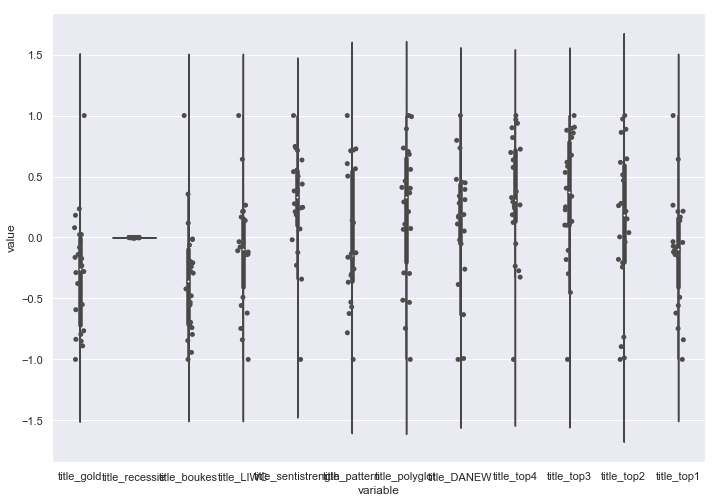

In [89]:
seaborn.violinplot(x="variable", y="value",data=standardized.drop('ID',1).melt())
seaborn.stripplot(x="variable", y="value",data=standardized.drop('ID',1).melt(),color=".3",jitter=True)

       text_gold  text_recessie  text_boukes  text_LIWC  text_sentistrength  \
count  22.000000      22.000000    22.000000  22.000000           22.000000   
mean   -0.129918      -0.024818     0.008919  -0.361640           -0.096144   
std     0.434755       0.010399     0.478508   0.446919            0.582733   
min    -1.000000      -0.042403    -1.000000  -1.000000           -1.000000   
25%    -0.337148      -0.030958    -0.180875  -0.601318           -0.528200   
50%    -0.215436      -0.025027     0.037118  -0.404905           -0.071596   
75%     0.052493      -0.017629     0.241691  -0.157314            0.232024   
max     1.000000      -0.007299     1.000000   1.000000            1.000000   

       text_pattern  text_polyglot  text_DANEW  text_top4  text_top3  \
count     22.000000      22.000000   22.000000  22.000000  22.000000   
mean      -0.257075      -0.013458    0.065161  -0.023629  -0.112029   
std        0.440696       0.528363    0.605524   0.456330   0.436924   


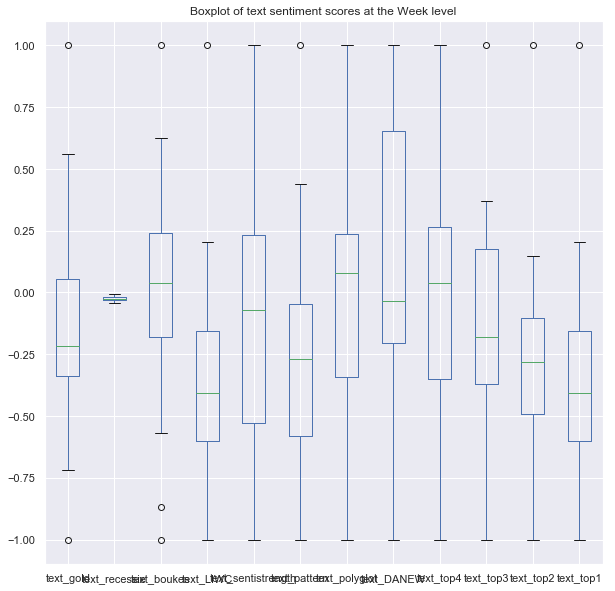

In [90]:
standardized = analyze.compare_sentiment_means(weekly_data,field='text')
standardized.drop('ID',1).plot(kind='box',figsize=(10,10),title="Boxplot of text sentiment scores at the Week level")

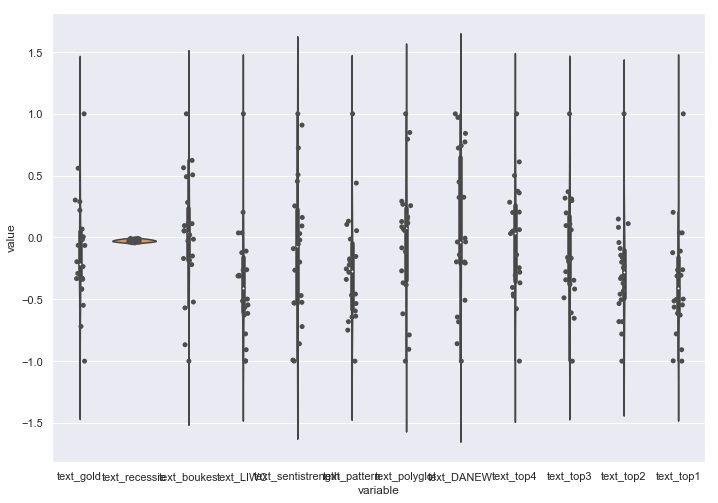

In [91]:
seaborn.violinplot(x="variable", y="value",data=standardized.drop('ID',1).melt())
seaborn.stripplot(x="variable", y="value",data=standardized.drop('ID',1).melt(),color=".3",jitter=True)

### Quality of models

In [92]:
analyze.check_quality(weekly_data,'title').loc[title_order,:]

/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/theo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1
,precision,precision,precision,precision,recall,recall,recall,recall,f1,f1,f1,f1,support,support,support,support,n_predicted,n_predicted,n_predicted
title_recessie,0.67,0.00,0.31,0.33,0.50,0.00,0.83,0.41,0.57,0.00,0.45,0.33,8,8,6,22,6,0,16
title_boukes,0.14,0.22,0.33,0.22,0.12,0.25,0.33,0.23,0.13,0.24,0.33,0.22,8,8,6,22,7,9,6
title_LIWC,0.67,0.44,0.43,0.52,0.50,0.50,0.50,0.50,0.57,0.47,0.46,0.50,8,8,6,22,6,9,7
title_sentistrength,0.60,0.22,0.25,0.37,0.38,0.25,0.33,0.32,0.46,0.24,0.29,0.33,8,8,6,22,5,9,8
title_pattern,0.50,0.57,0.57,0.55,0.50,0.50,0.67,0.55,0.50,0.53,0.62,0.54,8,8,6,22,8,7,7
title_polyglot,0.50,0.33,0.43,0.42,0.38,0.38,0.50,0.41,0.43,0.35,0.46,0.41,8,8,6,22,6,9,7
title_DANEW,0.20,0.30,0.43,0.30,0.12,0.38,0.50,0.32,0.15,0.33,0.46,0.30,8,8,6,22,5,10,7


In [93]:
analyze.check_quality(weekly_data,'text').loc[text_order+["text_top3"],:]

,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1,global,-1,0,1
,precision,precision,precision,precision,recall,recall,recall,recall,f1,f1,f1,f1,support,support,support,support,n_predicted,n_predicted,n_predicted
text_recessie,0.33,0.20,0.00,0.18,0.6,0.08,0.0,0.18,0.43,0.12,0.00,0.16,5,12,5,22,9,5,8
text_boukes,0.75,0.67,0.50,0.65,0.6,0.67,0.6,0.64,0.67,0.67,0.55,0.64,5,12,5,22,4,12,6
text_LIWC,0.50,0.70,0.67,0.65,0.6,0.58,0.8,0.64,0.55,0.64,0.73,0.64,5,12,5,22,6,10,6
text_sentistrength,0.25,0.38,0.17,0.30,0.4,0.25,0.2,0.27,0.31,0.30,0.18,0.27,5,12,5,22,8,8,6
text_pattern,0.14,0.56,0.17,0.37,0.2,0.42,0.2,0.32,0.17,0.48,0.18,0.34,5,12,5,22,7,9,6
text_polyglot,0.50,0.60,0.33,0.52,0.6,0.50,0.4,0.50,0.55,0.55,0.36,0.50,5,12,5,22,6,10,6
text_DANEW,0.40,0.50,0.14,0.40,0.4,0.42,0.2,0.36,0.40,0.45,0.17,0.38,5,12,5,22,5,10,7
text_top3,0.50,0.71,0.43,0.60,0.8,0.42,0.6,0.55,0.62,0.53,0.50,0.54,5,12,5,22,8,7,7


### Correlations of results

In [94]:
analyze.correlation_tests(weekly_data,'title')

,title_gold,title_recessie,title_boukes,title_LIWC,title_sentistrength,title_pattern,title_polyglot,title_DANEW,title_top4,title_top3,title_top2,title_top1
title_DANEW,0.16,-0.08,0.26,0.52 *,0.60 **,0.44 *,0.43 *,1.00 ***,0.81 ***,0.64 **,0.53 *,0.52 *
title_LIWC,0.52 *,0.43 *,0.30,1.00 ***,0.39,0.38,0.54 *,0.52 *,0.74 ***,0.75 ***,0.84 ***,1.00 ***
title_boukes,0.23,-0.10,1.00 ***,0.30,0.29,0.21,0.19,0.26,0.33,0.32,0.27,0.30
title_gold,1.00 ***,0.21,0.23,0.52 *,0.41,0.39,0.39,0.16,0.46 *,0.54 **,0.51 *,0.52 *
title_pattern,0.39,-0.09,0.21,0.38,0.42,1.00 ***,0.51 *,0.44 *,0.56 **,0.54 **,0.51 *,0.38
title_polyglot,0.39,0.37,0.19,0.54 *,0.48 *,0.51 *,1.00 ***,0.43 *,0.78 ***,0.84 ***,0.91 ***,0.54 *
title_recessie,0.21,1.00 ***,-0.10,0.43 *,0.10,-0.09,0.37,-0.08,0.24,0.35,0.45 *,0.43 *
title_sentistrength,0.41,0.10,0.29,0.39,1.00 ***,0.42,0.48 *,0.60 **,0.82 ***,0.82 ***,0.50 *,0.39
title_top1,0.52 *,0.43 *,0.30,1.00 ***,0.39,0.38,0.54 *,0.52 *,0.74 ***,0.75 ***,0.84 ***,1.00 ***
title_top2,0.51 *,0.45 *,0.27,0.84 ***,0.50 *,0.51 *,0.91 ***,0.53 *,0.87 ***,0.91 ***,1.00 ***,0.84 ***


Text(0.5,1,'Correlation heatmap of title sentiment scores at the Week level')

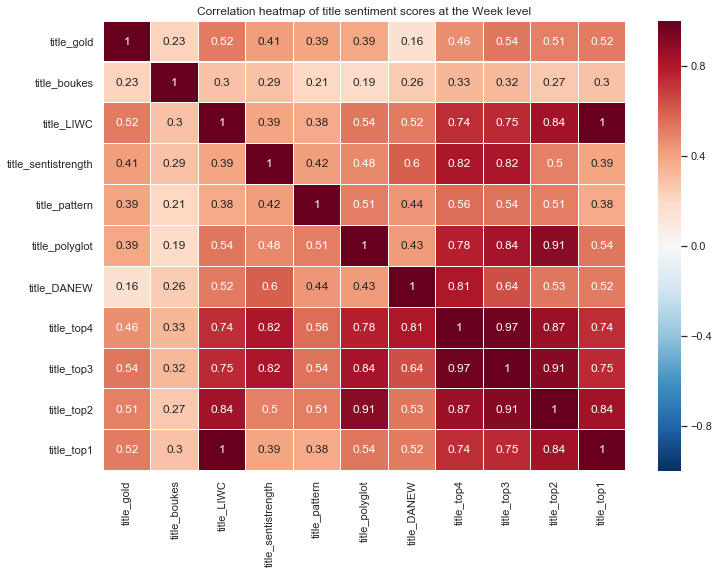

In [95]:
corplot(analyze.correlate_results(weekly_data.drop("title_recessie",axis=1),'title'),"Correlation heatmap of title sentiment scores at the Week level")

In [96]:
analyze.correlation_tests(weekly_data,'text').loc[['text_gold']+text_order,["text_gold"]+text_order]

,text_gold,text_recessie,text_boukes,text_LIWC,text_sentistrength,text_pattern,text_polyglot,text_DANEW
text_gold,1.00 ***,-0.39,0.64 **,0.49 *,0.20,-0.09,0.33,0.10
text_recessie,-0.39,1.00 ***,-0.01,-0.12,-0.14,0.35,-0.09,-0.23
text_boukes,0.64 **,-0.01,1.00 ***,0.40,0.27,0.22,0.35,-0.02
text_LIWC,0.49 *,-0.12,0.40,1.00 ***,0.39,0.02,0.26,0.34
text_sentistrength,0.20,-0.14,0.27,0.39,1.00 ***,0.10,0.15,0.34
text_pattern,-0.09,0.35,0.22,0.02,0.10,1.00 ***,0.40,0.12
text_polyglot,0.33,-0.09,0.35,0.26,0.15,0.40,1.00 ***,0.71 ***
text_DANEW,0.10,-0.23,-0.02,0.34,0.34,0.12,0.71 ***,1.00 ***


Text(0.5,1,'Correlation heatmap of text sentiment scores at the Week level')

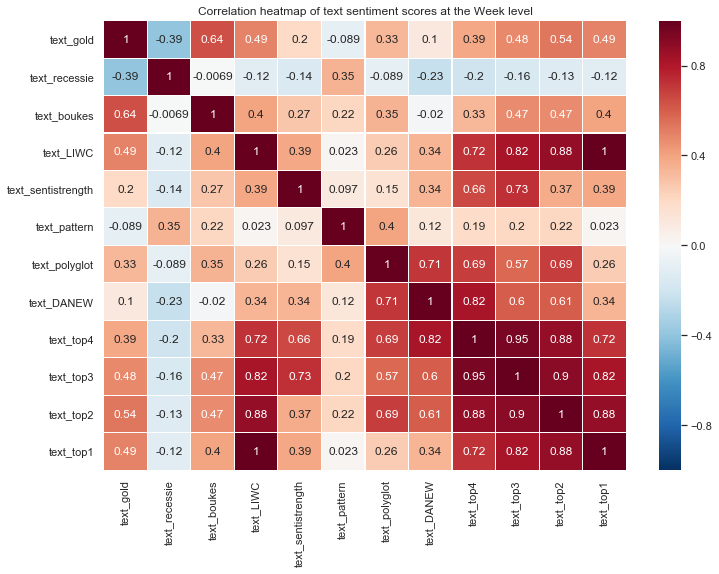

In [97]:
seaborn.heatmap(analyze.correlate_results(weekly_data,'text'), linewidth=.1, annot=True,cmap='RdBu_r',vmin=-1).set_title(
"Correlation heatmap of text sentiment scores at the Week level")

### Correlations of errors

In [98]:
analyze.correlation_tests(weekly_data, 'title', errors=True)


,title_recessie_err,title_boukes_err,title_LIWC_err,title_sentistrength_err,title_pattern_err,title_polyglot_err,title_DANEW_err,title_top4_err,title_top3_err,title_top2_err,title_top1_err
title_DANEW_err,0.91 ***,0.90 ***,-0.03,-0.64 **,0.90 ***,0.74 ***,1.00 ***,0.72 ***,0.66 ***,0.70 ***,0.79 ***
title_LIWC_err,0.15,-0.01,1.00 ***,0.32,0.10,-0.23,-0.03,-0.28,-0.40,-0.37,-0.36
title_boukes_err,0.93 ***,1.00 ***,-0.01,-0.47 *,0.92 ***,0.63 **,0.90 ***,0.62 **,0.57 **,0.62 **,0.72 ***
title_pattern_err,0.97 ***,0.92 ***,0.10,-0.41,1.00 ***,0.66 ***,0.90 ***,0.65 **,0.60 **,0.65 **,0.72 ***
title_polyglot_err,0.62 **,0.63 **,-0.23,-0.60 **,0.66 ***,1.00 ***,0.74 ***,0.85 ***,0.86 ***,0.95 ***,0.81 ***
title_recessie_err,1.00 ***,0.93 ***,0.15,-0.38,0.97 ***,0.62 **,0.91 ***,0.58 **,0.53 *,0.59 **,0.70 ***
title_sentistrength_err,-0.38,-0.47 *,0.32,1.00 ***,-0.41,-0.60 **,-0.64 **,-0.74 ***,-0.77 ***,-0.57 **,-0.52 *
title_top1_err,0.70 ***,0.72 ***,-0.36,-0.52 *,0.72 ***,0.81 ***,0.79 ***,0.81 ***,0.81 ***,0.92 ***,1.00 ***
title_top2_err,0.59 **,0.62 **,-0.37,-0.57 **,0.65 **,0.95 ***,0.70 ***,0.91 ***,0.92 ***,1.00 ***,0.92 ***
title_top3_err,0.53 *,0.57 **,-0.40,-0.77 ***,0.60 **,0.86 ***,0.66 ***,0.97 ***,1.00 ***,0.92 ***,0.81 ***


Text(0.5,1,'Heatmap of Week-level title error correlation coefficients')

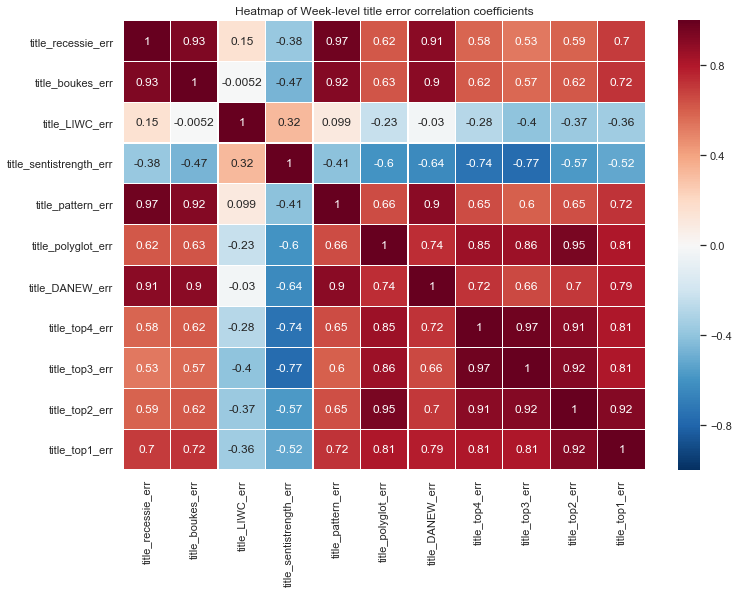

In [99]:
corplot(analyze.correlate_results(weekly_data,'title',errors=True),"Heatmap of Week-level title error correlation coefficients")

In [100]:
analyze.correlation_tests(weekly_data, 'text',errors=True)

,text_recessie_err,text_boukes_err,text_LIWC_err,text_sentistrength_err,text_pattern_err,text_polyglot_err,text_DANEW_err,text_top4_err,text_top3_err,text_top2_err,text_top1_err
text_DANEW_err,0.96 ***,0.48 *,0.85 ***,0.50 *,1.00 ***,0.84 ***,1.00 ***,0.94 ***,0.94 ***,0.94 ***,0.88 ***
text_LIWC_err,0.82 ***,0.55 **,1.00 ***,0.44 *,0.85 ***,0.73 ***,0.85 ***,0.91 ***,0.91 ***,0.92 ***,0.95 ***
text_boukes_err,0.28,1.00 ***,0.55 **,-0.11,0.45 *,0.77 ***,0.48 *,0.37,0.37,0.37,0.38
text_pattern_err,0.97 ***,0.45 *,0.85 ***,0.52 *,1.00 ***,0.81 ***,1.00 ***,0.95 ***,0.95 ***,0.95 ***,0.89 ***
text_polyglot_err,0.67 ***,0.77 ***,0.73 ***,0.08,0.81 ***,1.00 ***,0.84 ***,0.70 ***,0.69 ***,0.69 ***,0.63 **
text_recessie_err,1.00 ***,0.28,0.82 ***,0.66 ***,0.97 ***,0.67 ***,0.96 ***,0.96 ***,0.97 ***,0.97 ***,0.92 ***
text_sentistrength_err,0.66 ***,-0.11,0.44 *,1.00 ***,0.52 *,0.08,0.50 *,0.65 **,0.64 **,0.62 **,0.63 **
text_top1_err,0.92 ***,0.38,0.95 ***,0.63 **,0.89 ***,0.63 **,0.88 ***,0.96 ***,0.97 ***,0.98 ***,1.00 ***
text_top2_err,0.97 ***,0.37,0.92 ***,0.62 **,0.95 ***,0.69 ***,0.94 ***,0.99 ***,0.99 ***,1.00 ***,0.98 ***
text_top3_err,0.97 ***,0.37,0.91 ***,0.64 **,0.95 ***,0.69 ***,0.94 ***,1.00 ***,1.00 ***,0.99 ***,0.97 ***


Text(0.5,1,'Heatmap of Week-level text error correlation coefficients')

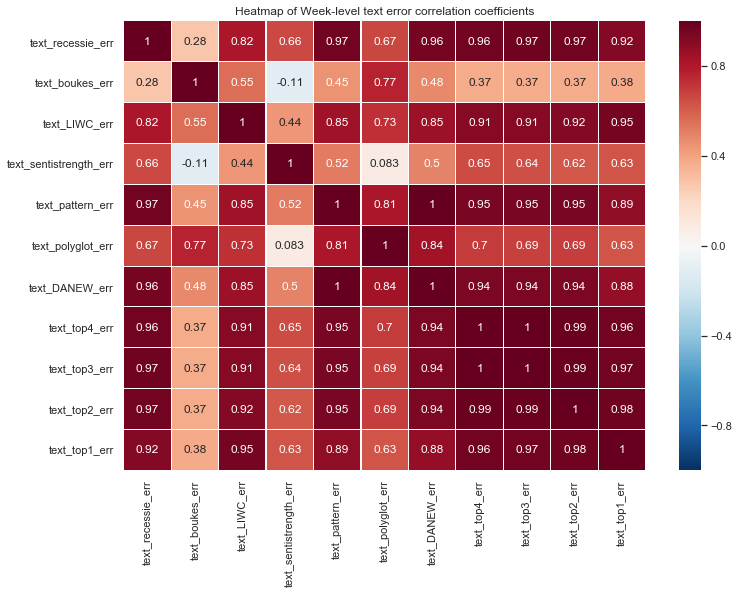

In [101]:
corplot(analyze.correlate_results(weekly_data,'text',errors=True),"Heatmap of Week-level text error correlation coefficients")

## Method correlations with  baseline compared across granularities

In [102]:
analyze.mean_correlations(data.loc[:,["title_"+t for t in tool_order]+["title_gold","title_top3"]].dropna(),'title').loc[title_order+['title_top3','N'],:]

,Article,1D,1W,1M
title_recessie,-0.01,0.04,0.21,0.24
title_boukes,0.14 ***,0.28 **,0.17,-0.34
title_LIWC,0.26 ***,0.41 ***,0.60 **,0.23
title_sentistrength,0.20 ***,0.35 ***,0.38,-0.11
title_pattern,0.18 ***,0.17,0.46 *,-0.68
title_polyglot,0.26 ***,0.40 ***,0.40,-0.35
title_DANEW,0.24 ***,0.26 **,0.29,-0.38
title_top3,0.33 ***,0.49 ***,0.56 **,-0.11
N,4640,152,22,6


### Top 4

In [103]:
analyze.mean_correlations(data.loc[:,["title_"+t for t in tool_order]+["title_gold","title_top4"]].dropna(),'title').loc[title_order+['title_top4','N'],:]

,Article,1D,1W,1M
title_recessie,-0.01,0.04,0.21,0.24
title_boukes,0.14 ***,0.28 **,0.17,-0.34
title_LIWC,0.26 ***,0.41 ***,0.60 **,0.23
title_sentistrength,0.20 ***,0.35 ***,0.38,-0.11
title_pattern,0.18 ***,0.17,0.46 *,-0.68
title_polyglot,0.26 ***,0.40 ***,0.40,-0.35
title_DANEW,0.24 ***,0.26 **,0.29,-0.38
title_top4,0.34 ***,0.47 ***,0.52 *,-0.22
N,4640,152,22,6


In [104]:
analyze.mean_correlations(data.loc[:,["text_"+t for t in tool_order]+["text_gold","text_top3"]].dropna(),'text').loc[text_order+['text_top3','N'],:]

,Article,1D,1W,1M
text_recessie,-0.04,-0.08,-0.34,-0.17
text_boukes,0.26 ***,0.36 ***,0.63 **,0.23
text_LIWC,0.37 ***,0.53 ***,0.59 **,0.33
text_sentistrength,0.17 ***,0.18,0.42,0.33
text_pattern,0.11 ***,0.07,0.09,-0.30
text_polyglot,0.26 ***,0.26 **,0.52 *,0.02
text_DANEW,0.18 ***,0.18,-0.15,-0.07
text_top3,0.37 ***,0.48 ***,0.64 **,0.55
N,1426,152,22,6


### Top 4

In [105]:
analyze.mean_correlations(data.loc[:,["text_"+t for t in tool_order]+["text_gold","text_top4"]].dropna(),'text').loc[text_order+['text_top4','N'],:]

,Article,1D,1W,1M
text_recessie,-0.04,-0.08,-0.34,-0.17
text_boukes,0.26 ***,0.36 ***,0.63 **,0.23
text_LIWC,0.37 ***,0.53 ***,0.59 **,0.33
text_sentistrength,0.17 ***,0.18,0.42,0.33
text_pattern,0.11 ***,0.07,0.09,-0.30
text_polyglot,0.26 ***,0.26 **,0.52 *,0.02
text_DANEW,0.18 ***,0.18,-0.15,-0.07
text_top4,0.36 ***,0.43 ***,0.53 *,0.27
N,1426,152,22,6


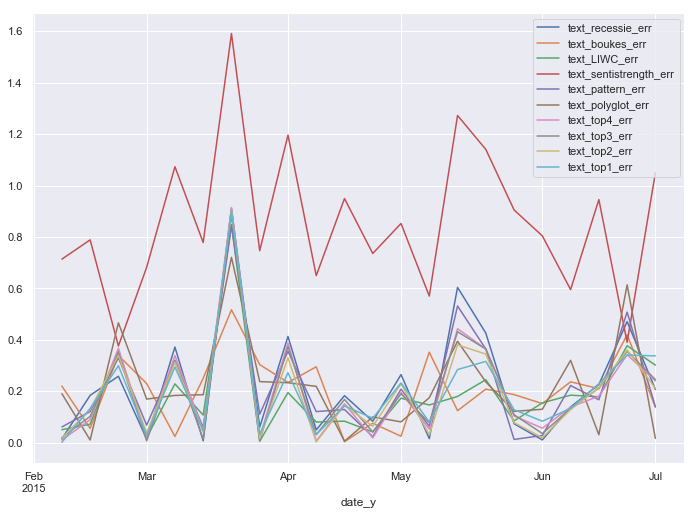

In [106]:
#min_max_norm = lambda x: (x-x.median())/(x.max()-x.min())
weekly_data[[col for col in weekly_data.columns if "text_" in col and "_err" in col and not "text_DANEW" in col ]].plot()

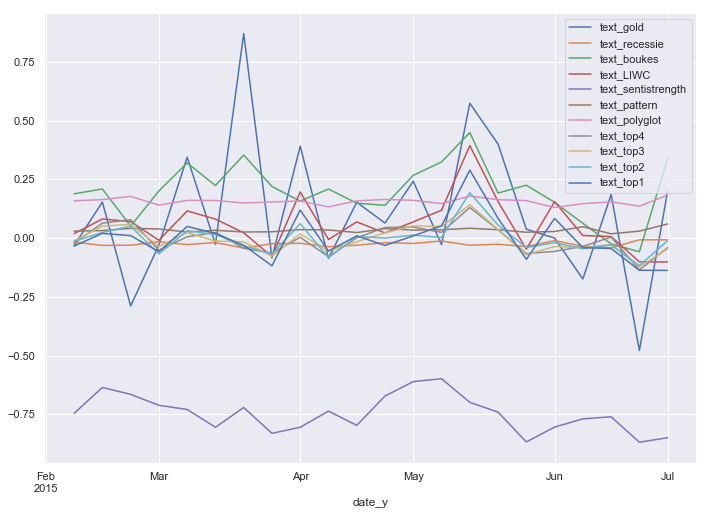

In [107]:
weekly_data[[col for col in weekly_data.columns if "text_" in col and not "_err" in col and not "text_DANEW" in col ]].plot()

# Boukes bonus bonanza

In [108]:
print("Predicting complexity of titles")
analyze.analyze_complexity(article_data, field='title')

Predicting complexity of titles


,Result
Intercept,29.15 ***
Model_F_score,38.60 ***
Model_R2,0.03
Model_adj_R2,0.03
N_observations,4640
online[T.True],1.78
quality,-9.85 ***
title_gold,1.98 *
word_count_title,1.68 ***


In [109]:
print("Predicting complexity of texts")
analyze.analyze_complexity(article_data, field='text')

Predicting complexity of texts


,Result
Intercept,40.18 ***
Model_F_score,17.40 ***
Model_R2,0.05
Model_adj_R2,0.04
N_observations,1426
online[T.True],1.92 **
quality,-3.01 ***
text_gold,0.63 ***
word_count_text,0.01 ***


# Scatterplots

                     count      mean       std       min       25%       50%  \
text_recessie       1426.0 -0.039271  0.194306 -1.000000  0.000000  0.000000   
text_boukes         1426.0  0.575736  1.708661 -9.000000  0.000000  0.000000   
text_LIWC           1426.0  0.265035  1.197659 -4.000000 -0.430000  0.000000   
text_sentistrength  1426.0 -0.686536  0.939160 -3.000000 -1.000000 -1.000000   
text_pattern        1426.0  0.039773  0.099160 -0.575000 -0.014911  0.040563   
text_polyglot       1426.0  0.165750  0.223018 -1.000000  0.032258  0.166667   
text_DANEW          1426.0  0.045519  0.025625 -0.086960  0.029726  0.044263   
text_gold           1426.0  0.102384  1.533498 -2.000000 -1.000000  0.000000   
text_top3           1426.0  0.089412  0.722280 -2.020815 -0.375797  0.078692   

                         75%        max  
text_recessie       0.000000   0.000000  
text_boukes         1.000000  14.000000  
text_LIWC           0.910000   8.700000  
text_sentistrength  0.000000   

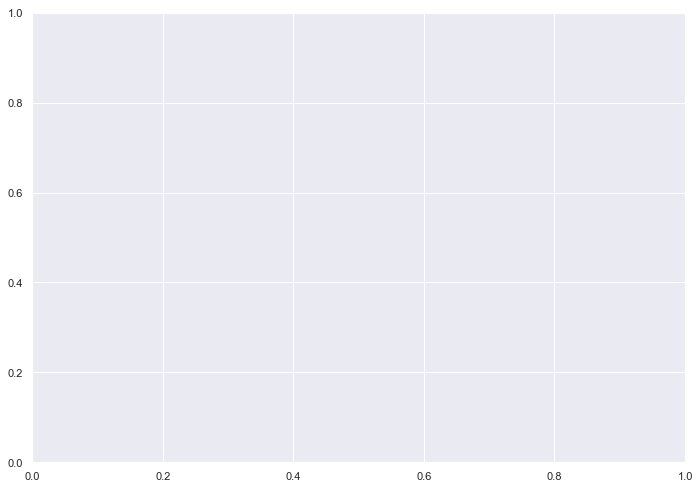

In [110]:
analyze.generate_scatterplots(article_data, "text", tool_order, "scatterplots/unstandardized/", standardization=False)

                     count        mean         std  min         25%  \
text_recessie       1426.0   -0.039271    0.194306 -1.0    0.000000   
text_boukes         1426.0   -0.167327    0.148579 -1.0   -0.217391   
text_LIWC           1426.0   -0.328341    0.188608 -1.0   -0.437795   
text_sentistrength  1426.0   -0.074614    0.375664 -1.0   -0.200000   
text_pattern        1426.0    0.046421    0.168783 -1.0   -0.046656   
text_polyglot       1426.0    0.165750    0.223018 -1.0    0.032258   
text_DANEW          1426.0    0.117831    0.216215 -1.0   -0.015425   
text_gold           1426.0    0.051192    0.766749 -1.0   -0.500000   
text_top3           1426.0   -0.205520    0.271931 -1.0   -0.380666   
ID                  1426.0  712.500000  411.795054  0.0  356.250000   

                           50%          75%     max  
text_recessie         0.000000     0.000000     0.0  
text_boukes          -0.217391    -0.130435     1.0  
text_LIWC            -0.370079    -0.226772     1.0  
te

/Users/theo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


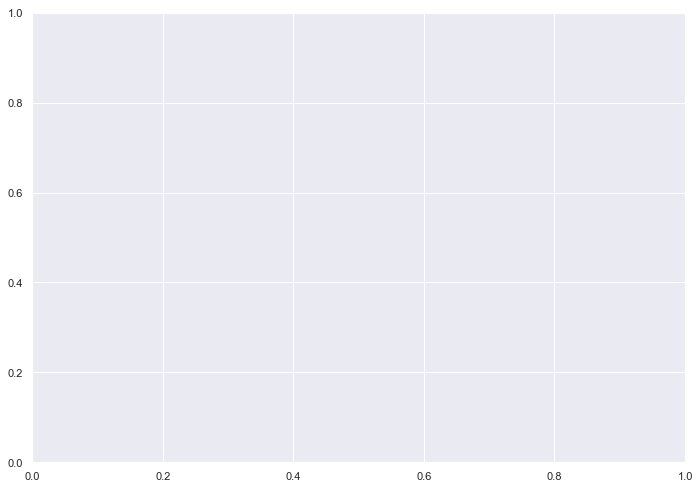

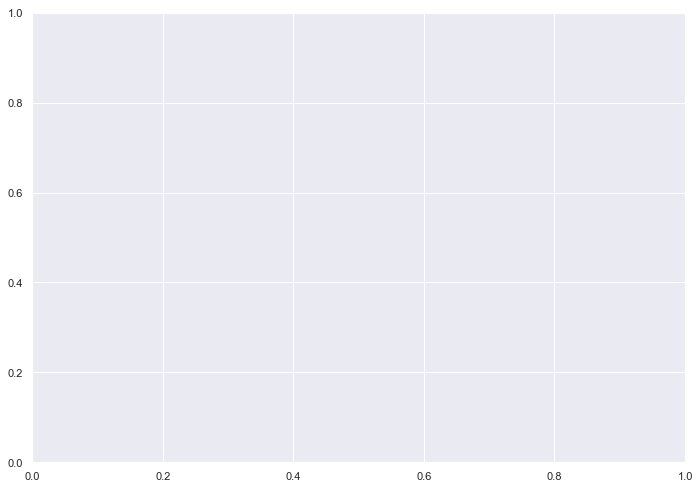

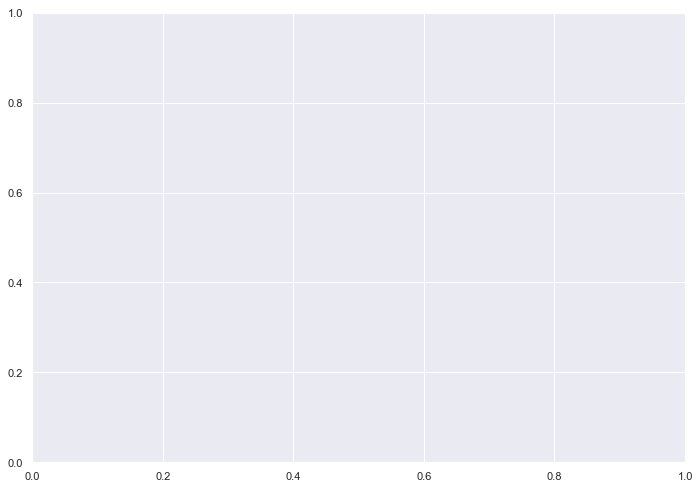

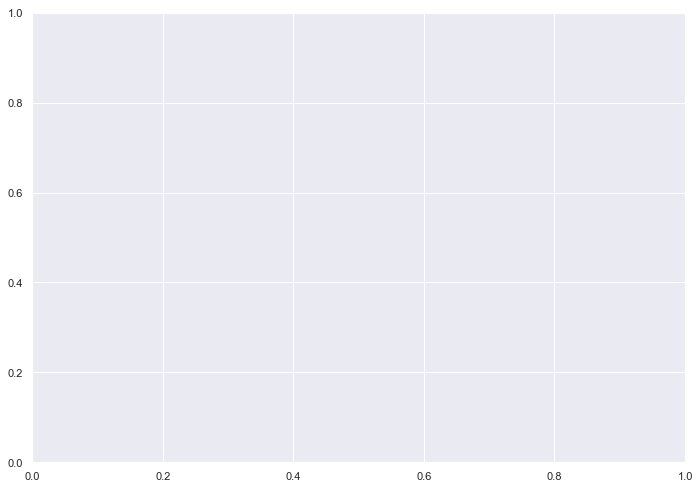

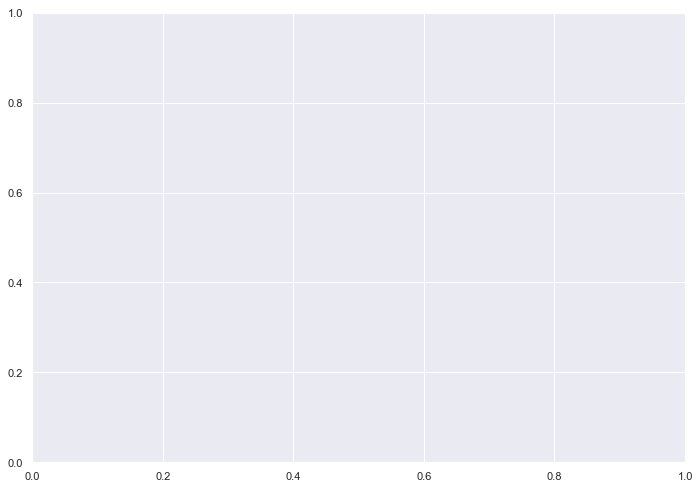

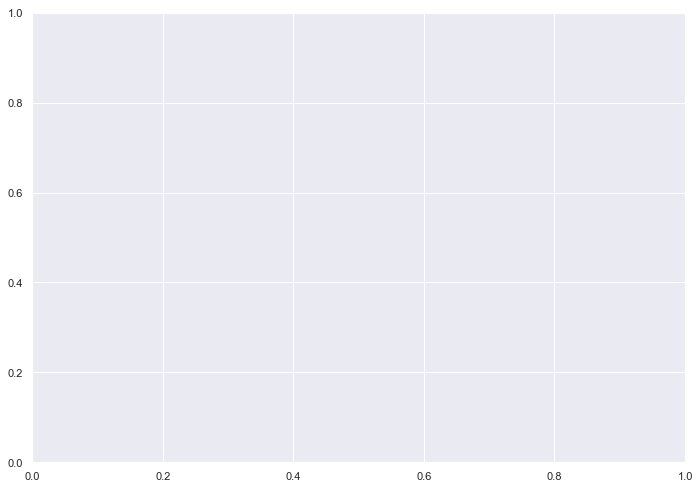

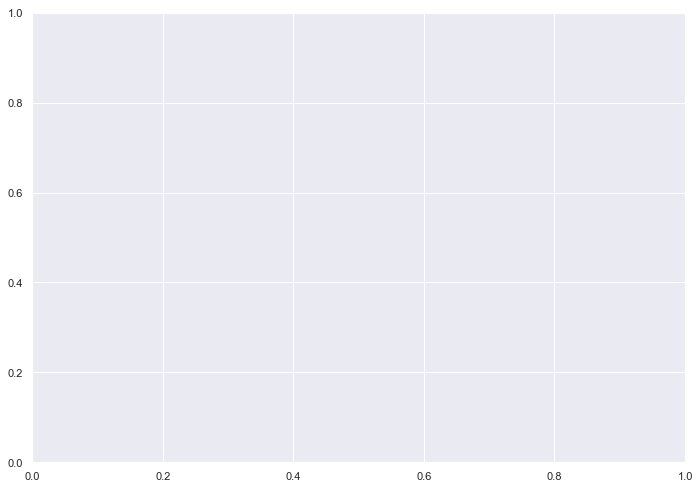

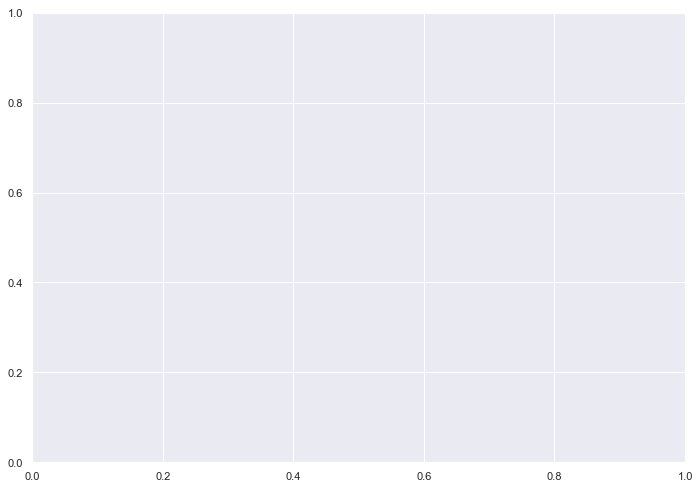

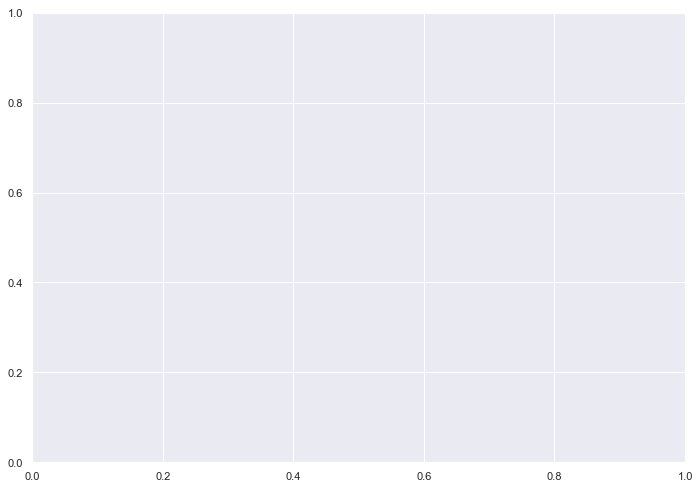

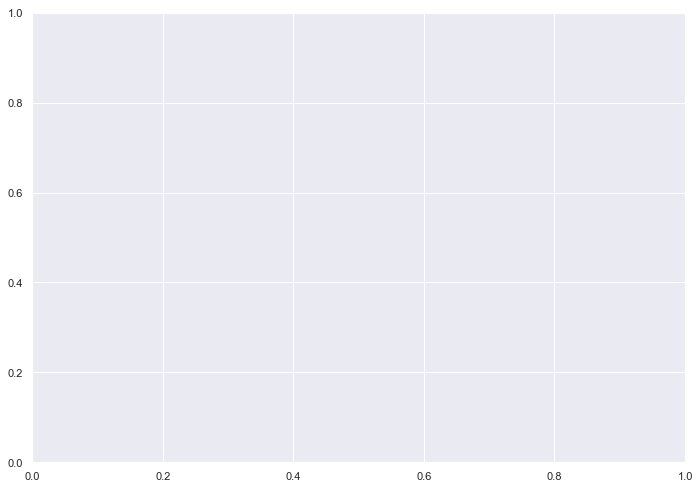

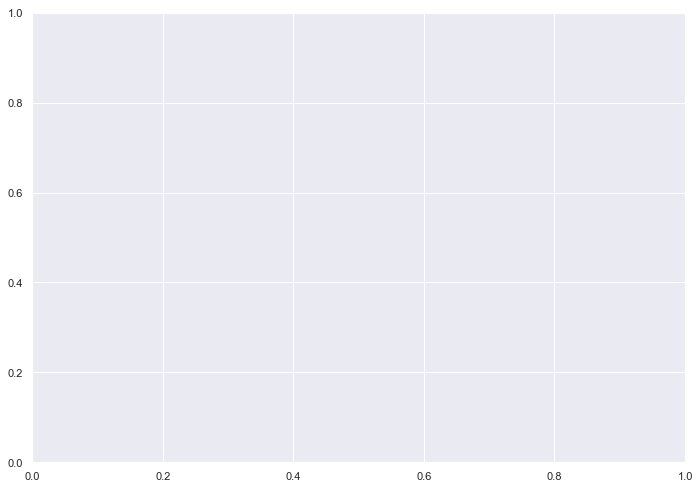

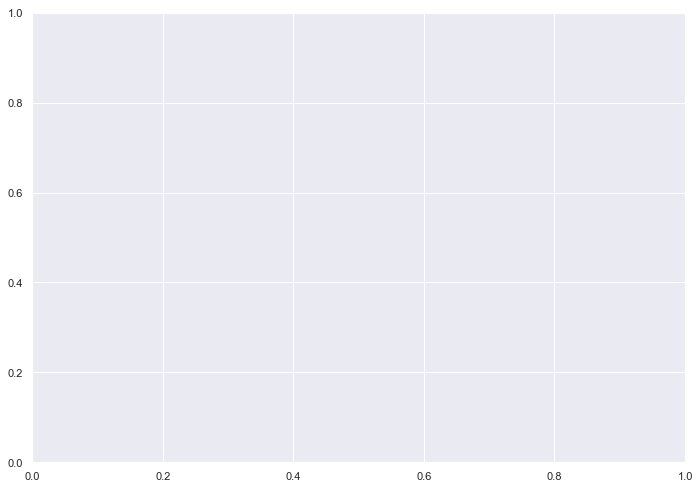

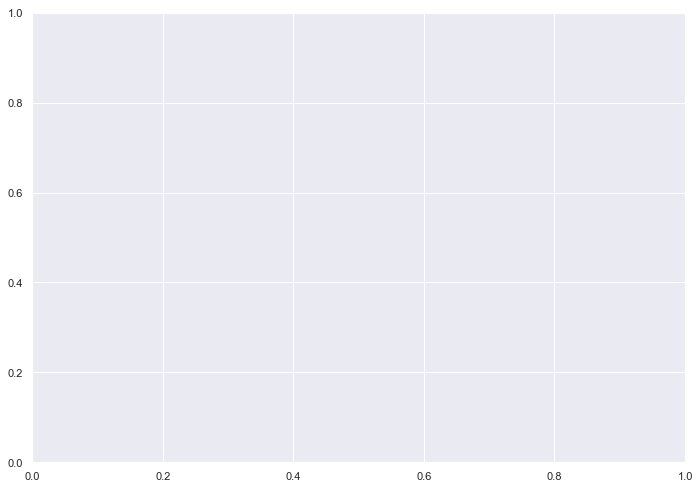

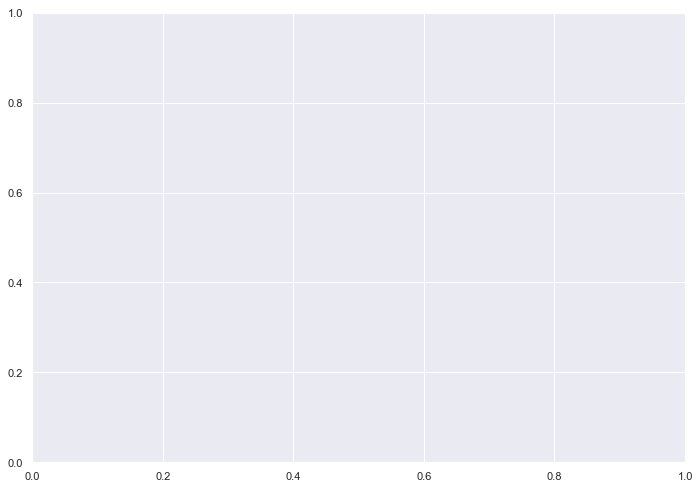

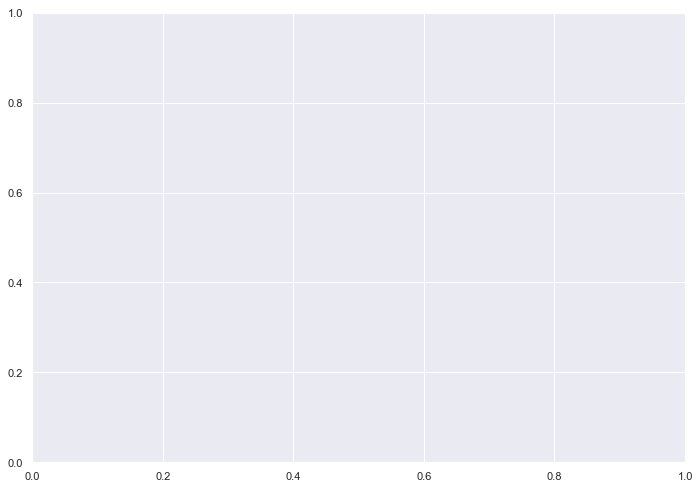

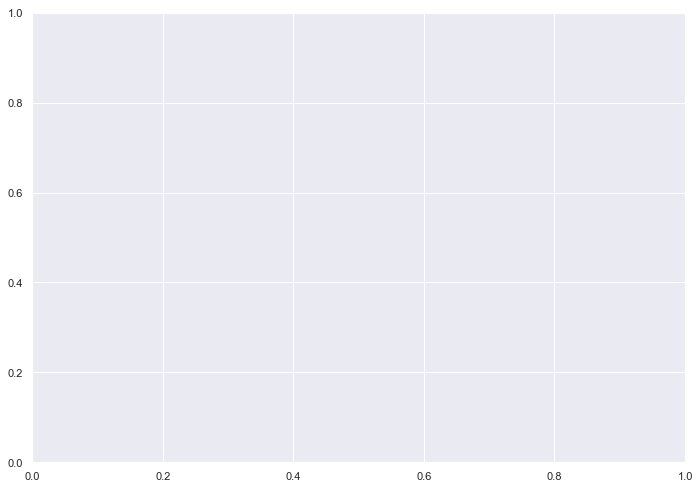

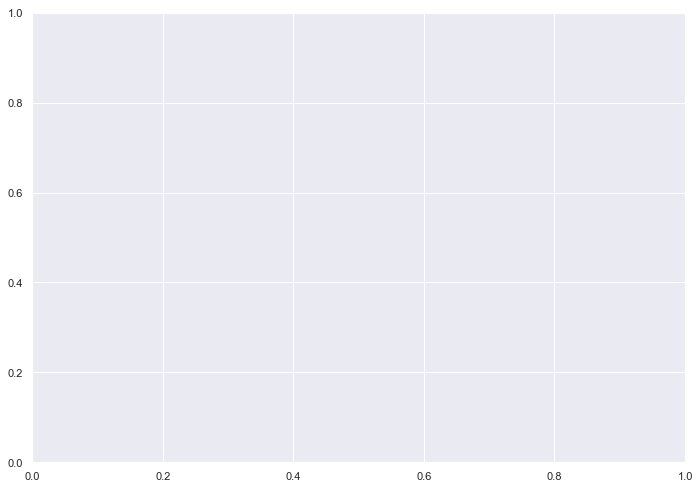

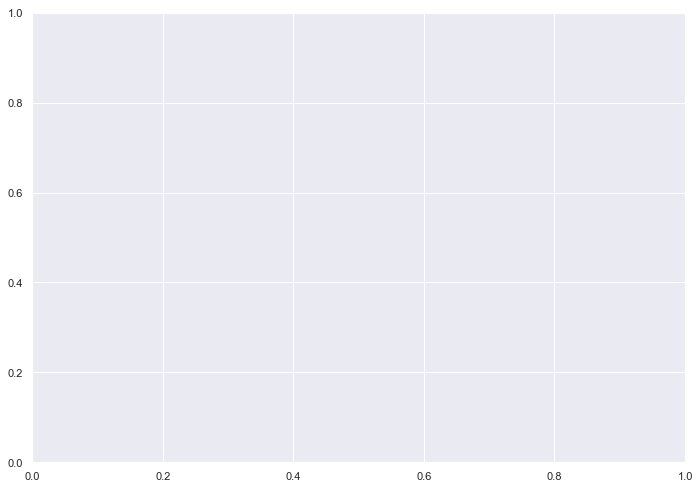

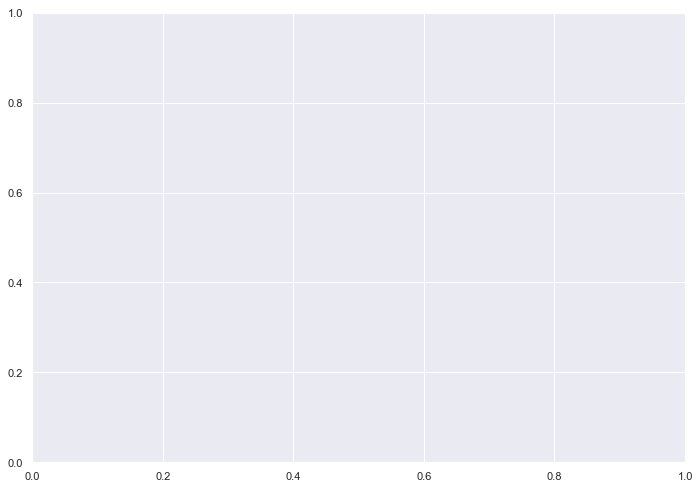

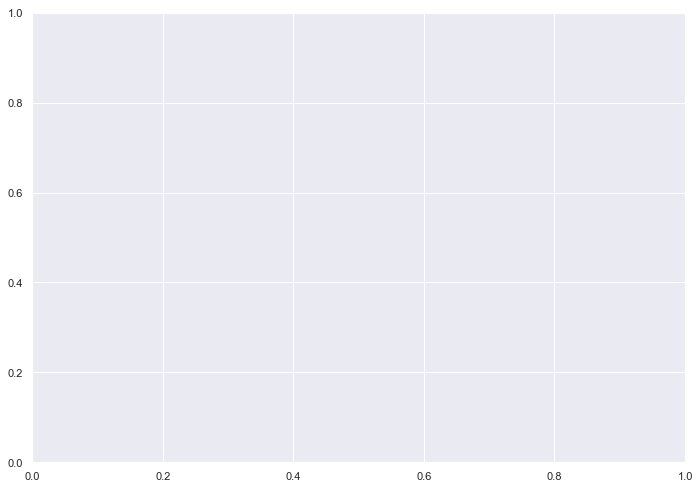

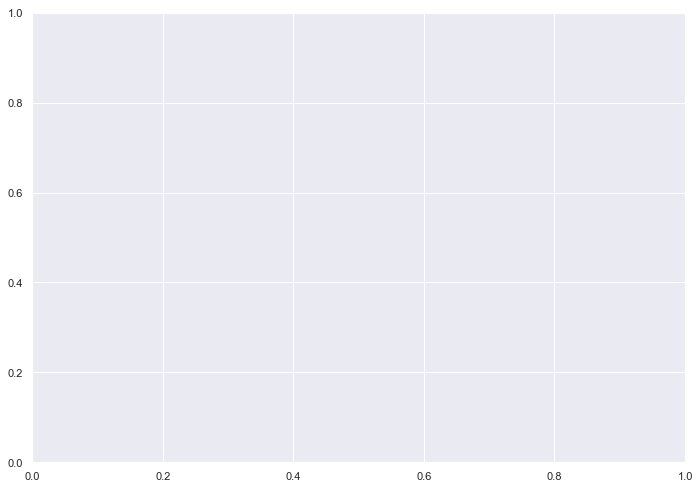

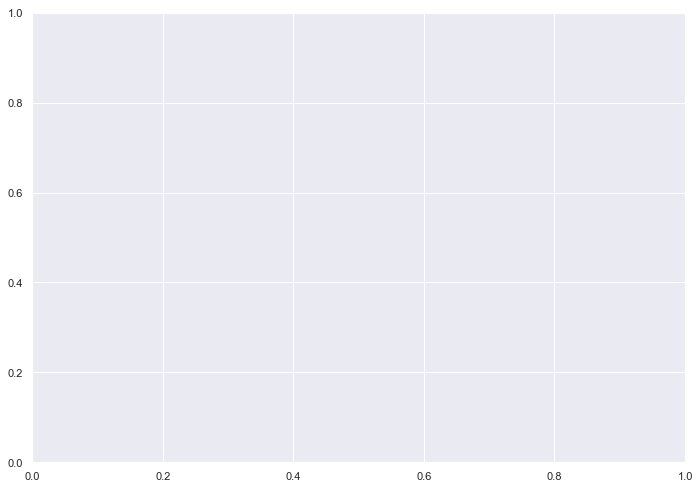

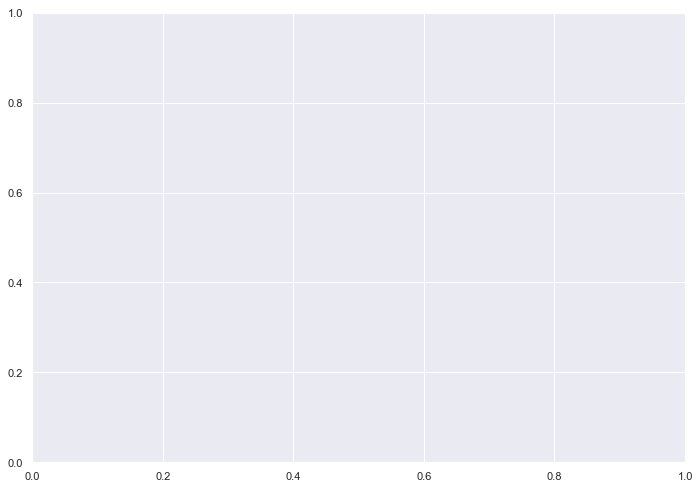

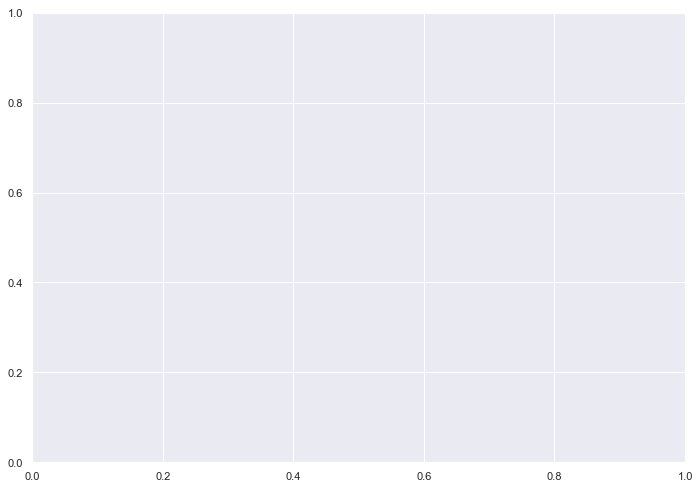

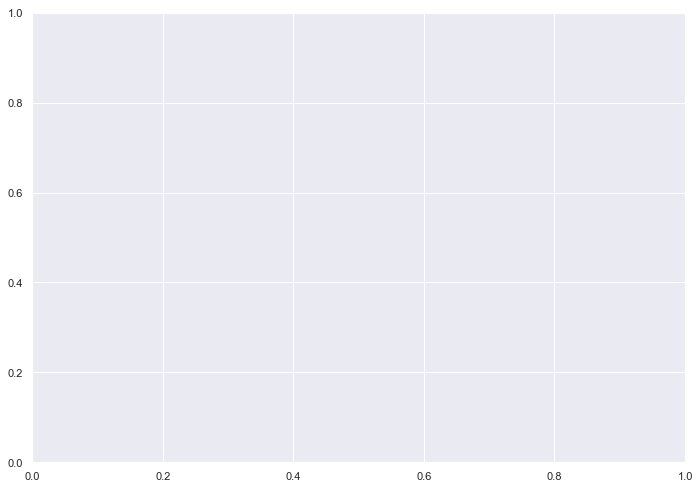

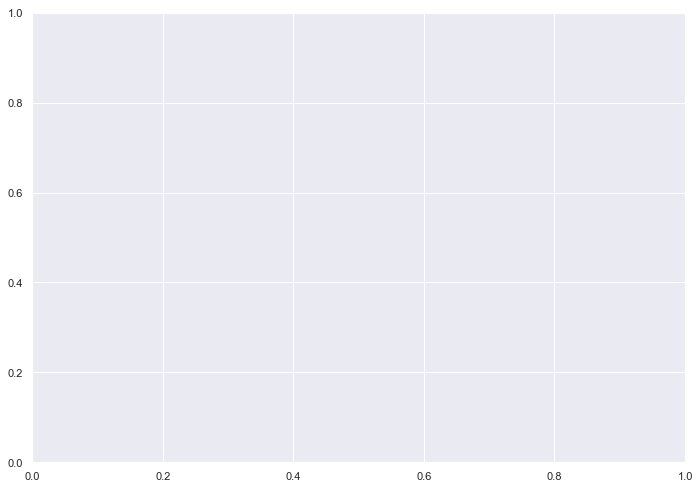

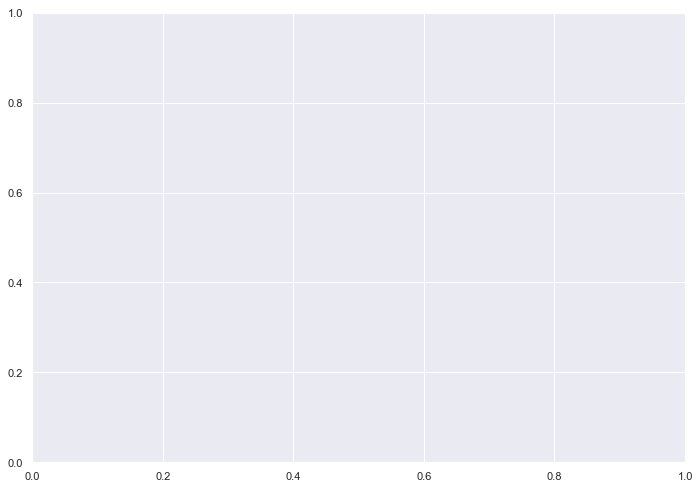

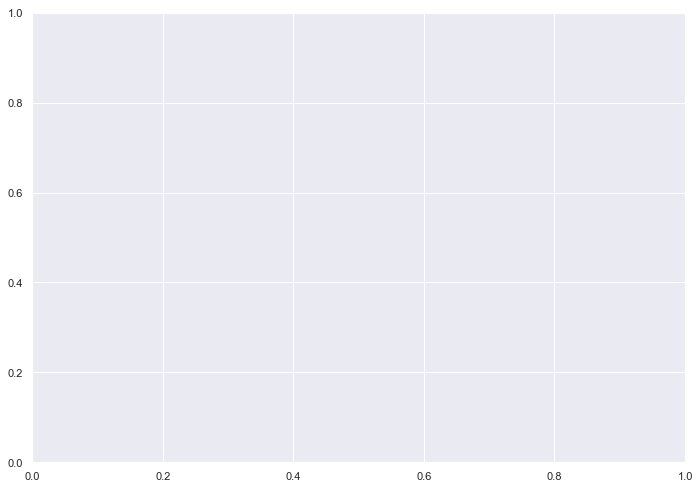

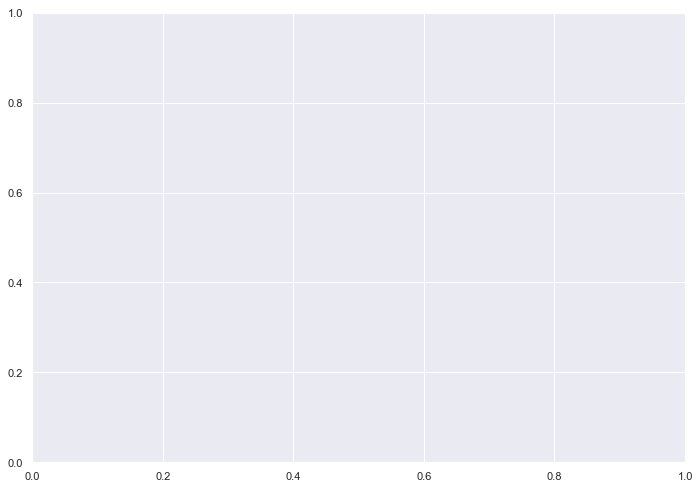

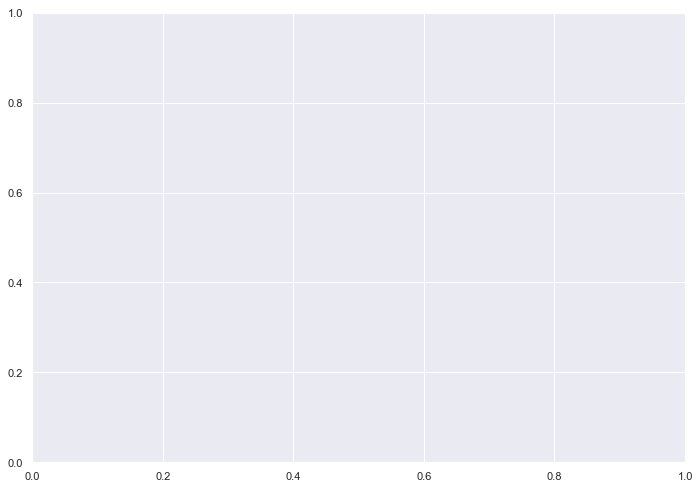

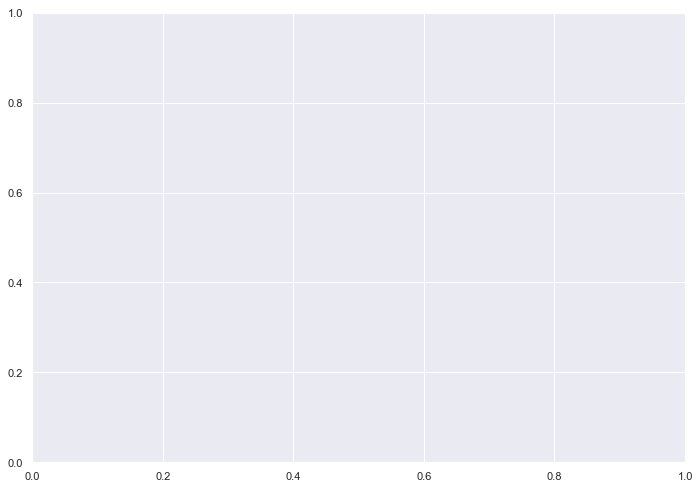

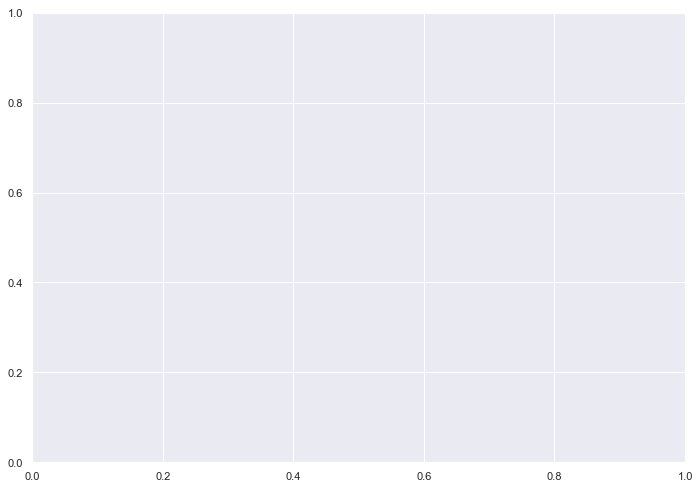

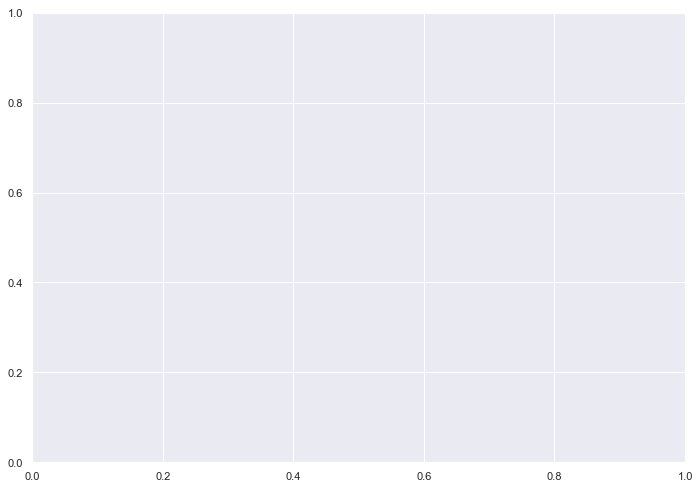

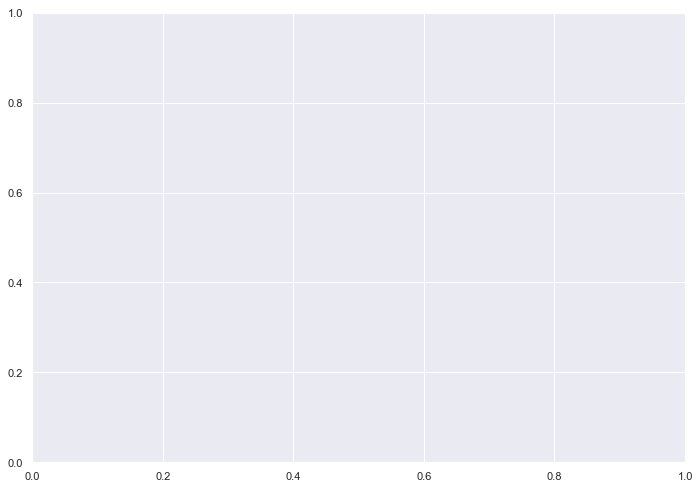

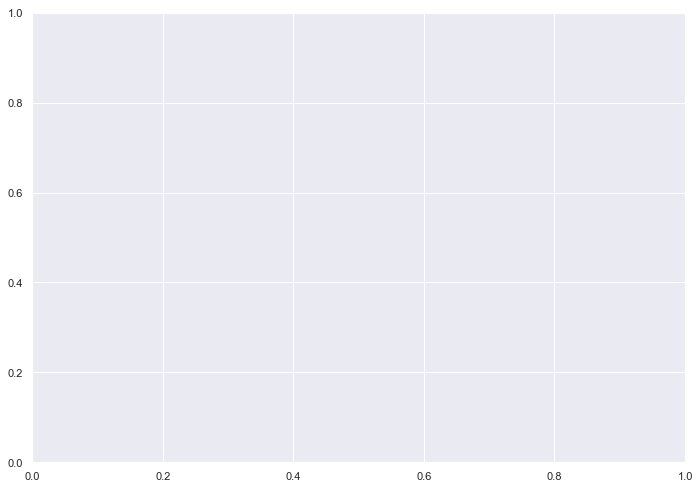

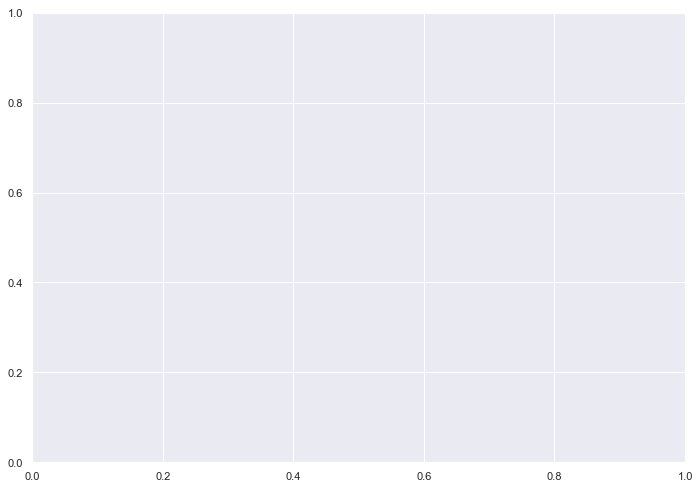

In [111]:
analyze.generate_scatterplots(article_data, "text", tool_order, "scatterplots/min-max/", standardization='min-max')

                     count          mean         std       min         25%  \
text_recessie       1426.0 -3.927069e-02    0.194306 -1.000000    0.000000   
text_boukes         1426.0  2.496834e-16    1.000351 -5.606200   -0.337070   
text_LIWC           1426.0 -1.004339e-16    1.000351 -3.562392   -0.580532   
text_sentistrength  1426.0  1.142922e-16    1.000351 -2.464197   -0.333888   
text_pattern        1426.0  4.982768e-18    1.000351 -6.201974   -0.551657   
text_polyglot       1426.0 -4.126355e-18    1.000351 -5.228984   -0.598781   
text_DANEW          1426.0  4.671345e-19    1.000351 -5.171816   -0.616530   
text_gold           1426.0  2.120401e-16    1.000351 -1.371454   -0.719121   
text_top3           1426.0 -1.074409e-17    1.000351 -2.922646   -0.644310   
ID                  1426.0  7.125000e+02  411.795054  0.000000  356.250000   

                           50%          75%          max  
text_recessie         0.000000     0.000000     0.000000  
text_boukes          -0

/Users/theo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


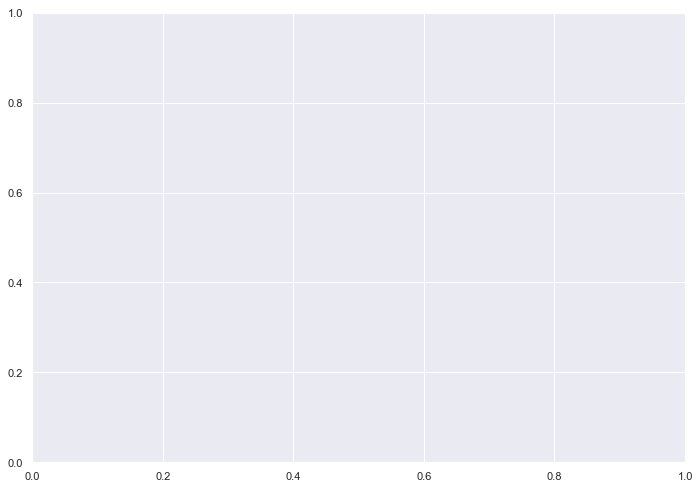

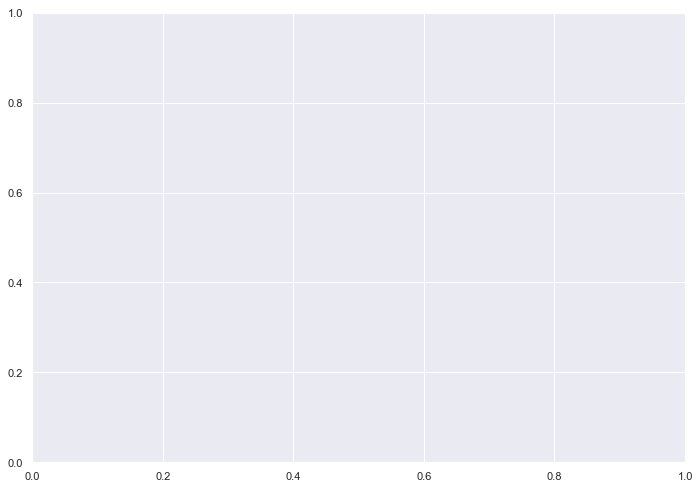

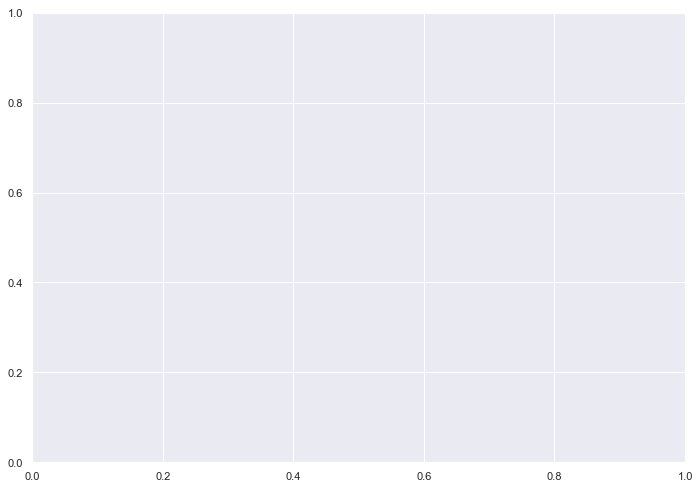

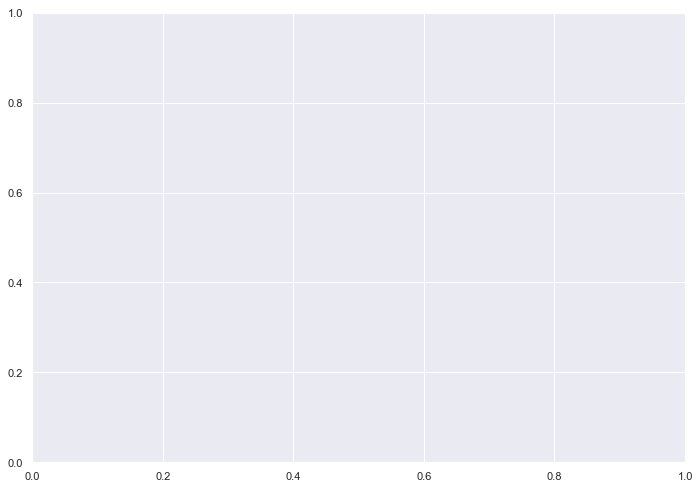

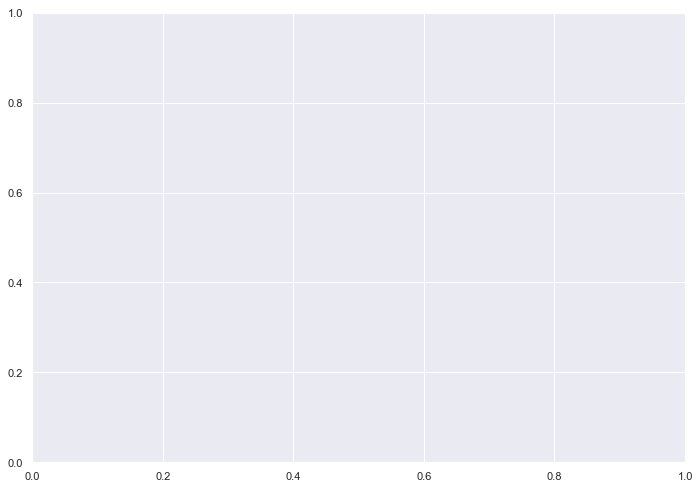

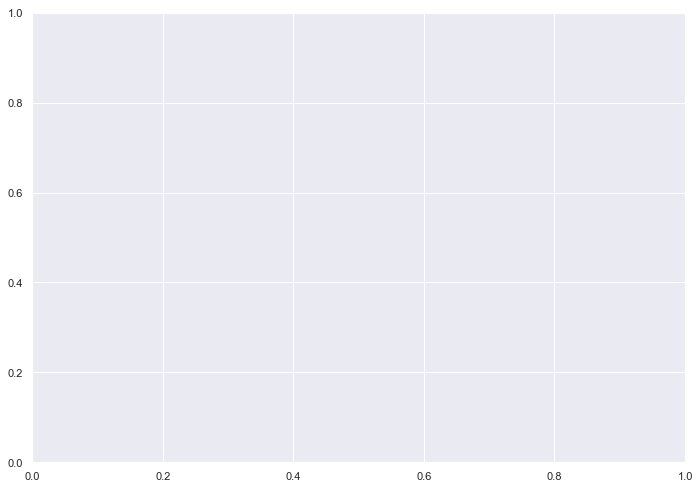

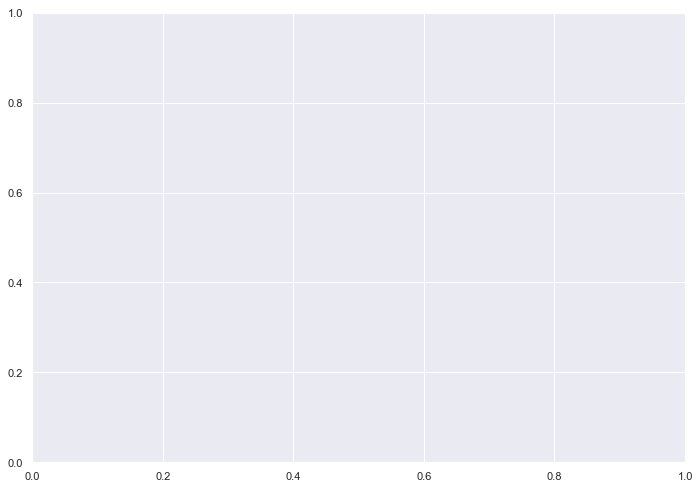

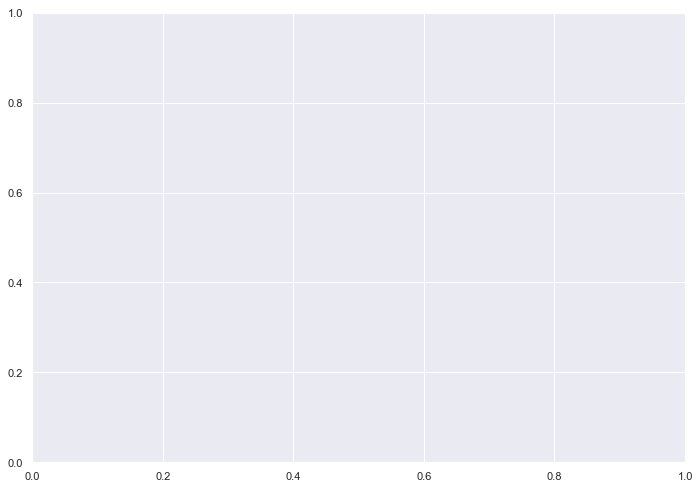

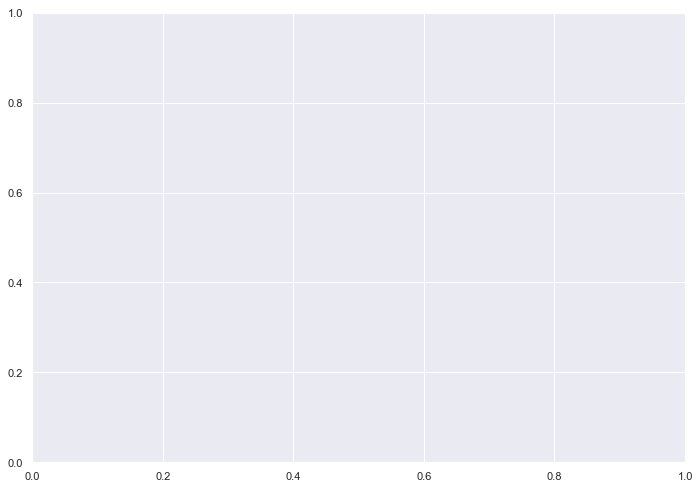

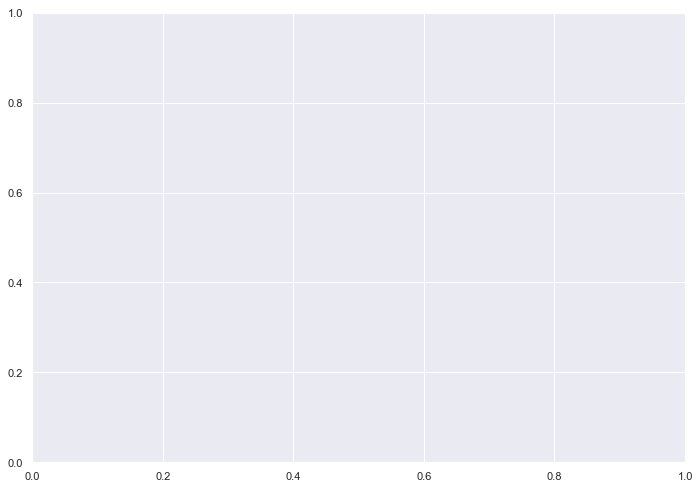

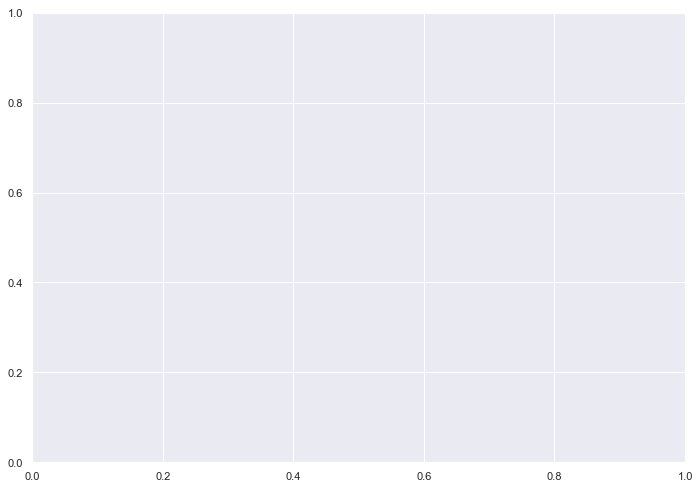

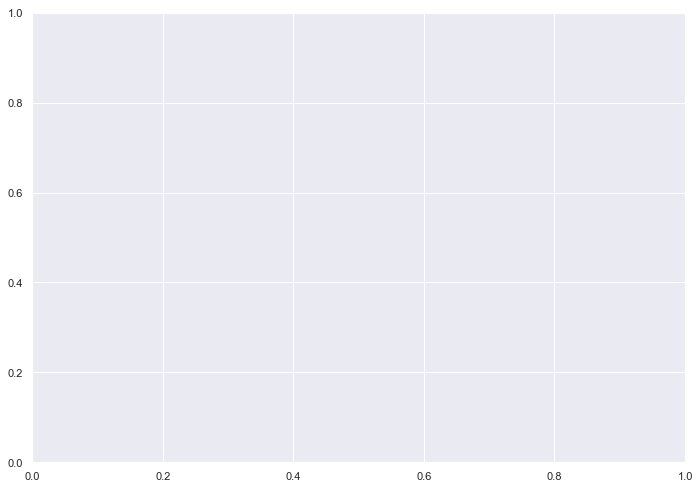

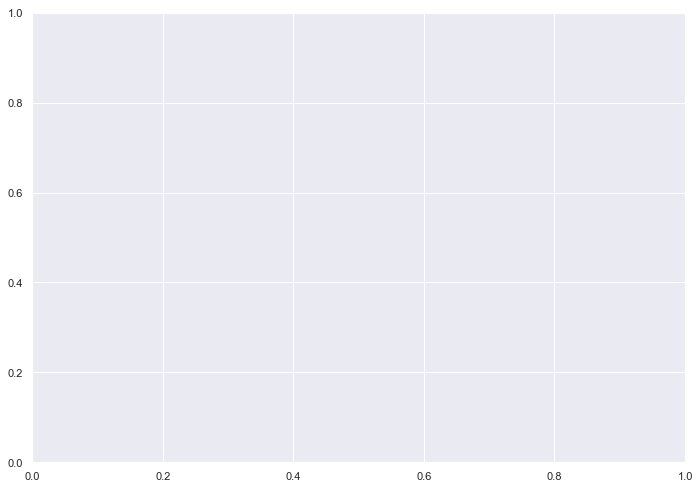

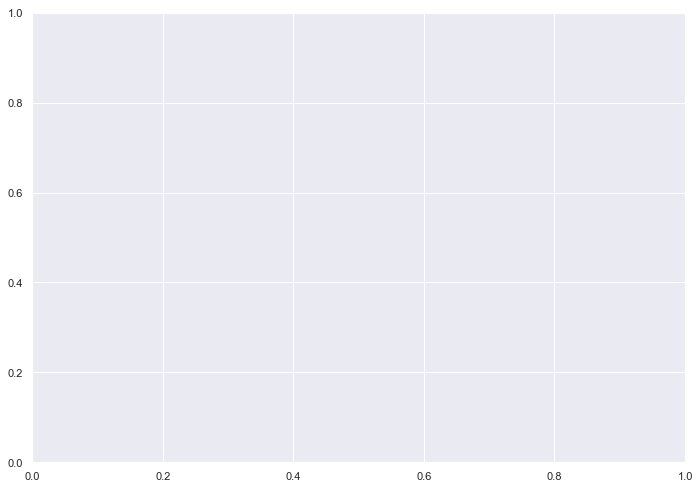

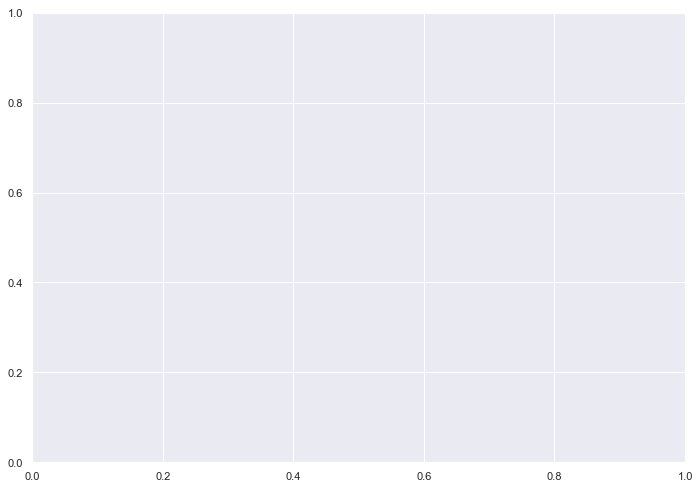

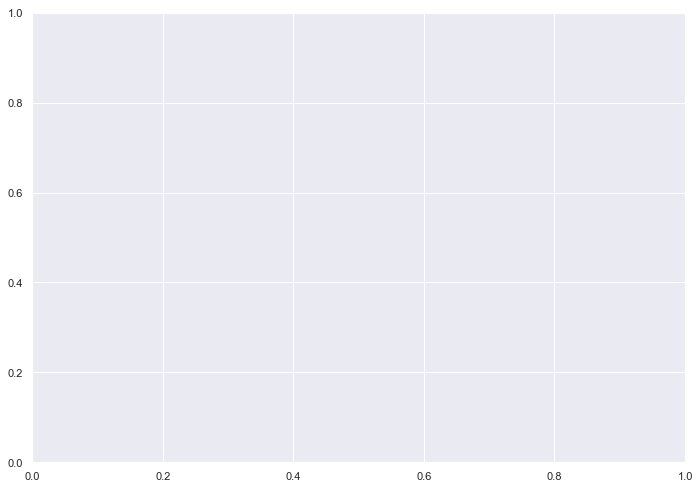

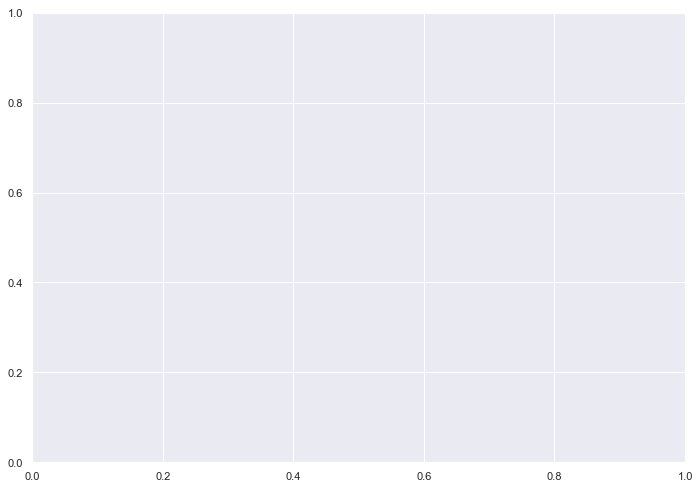

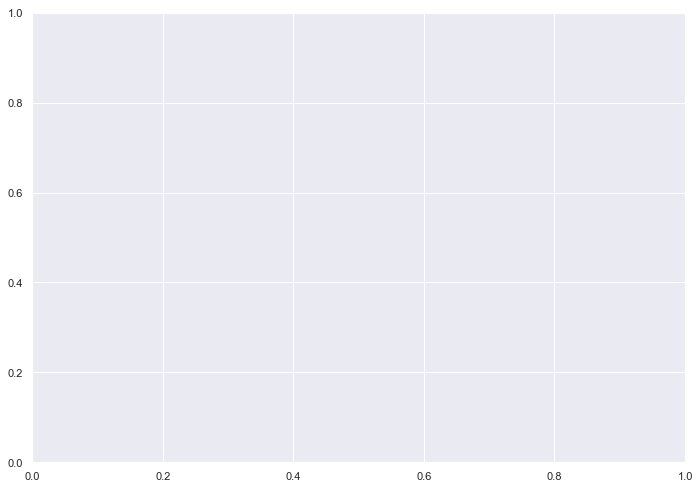

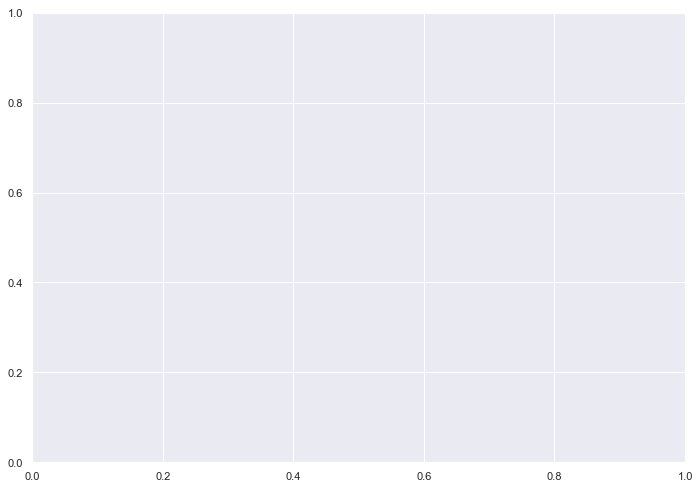

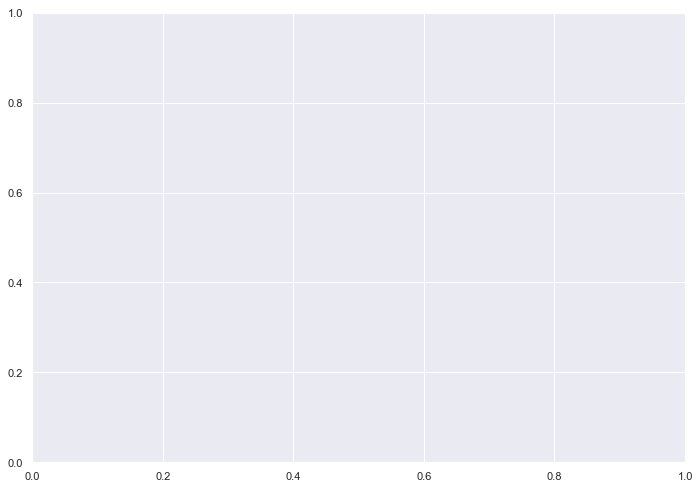

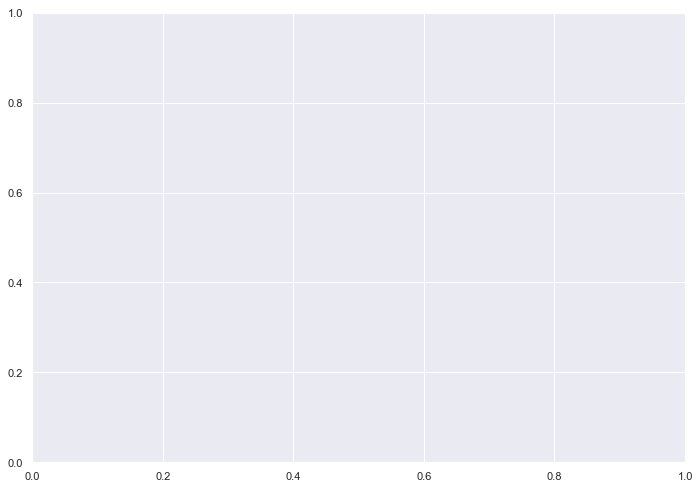

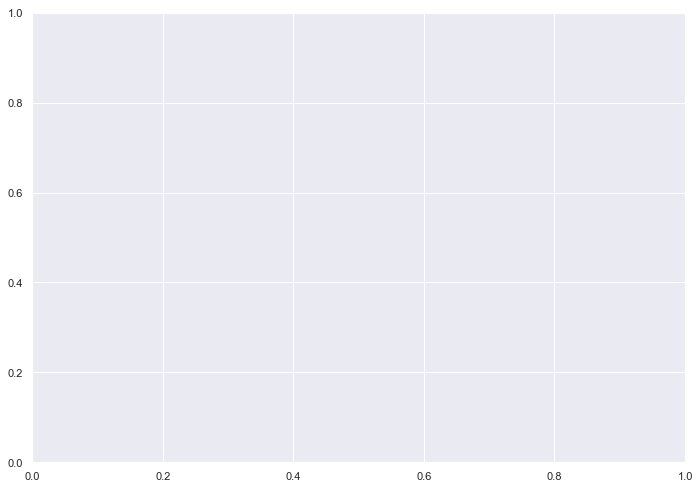

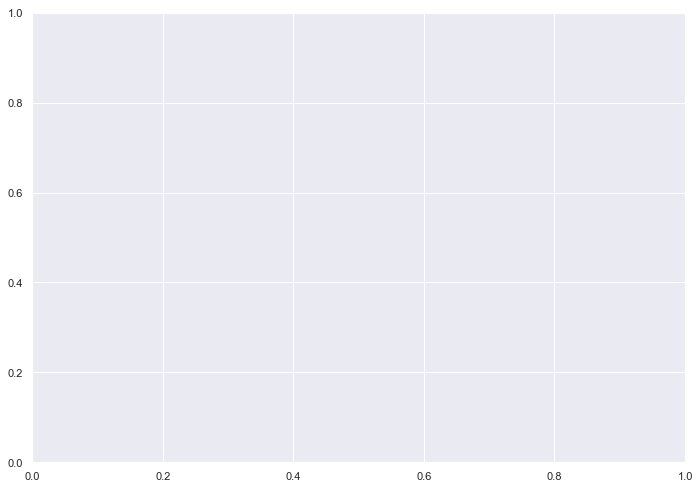

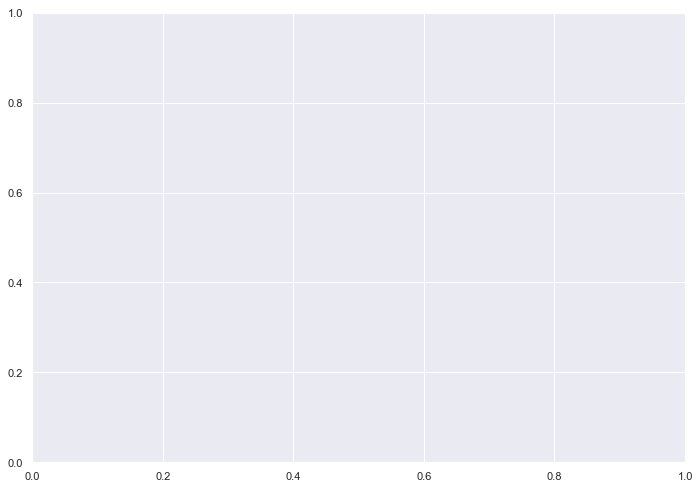

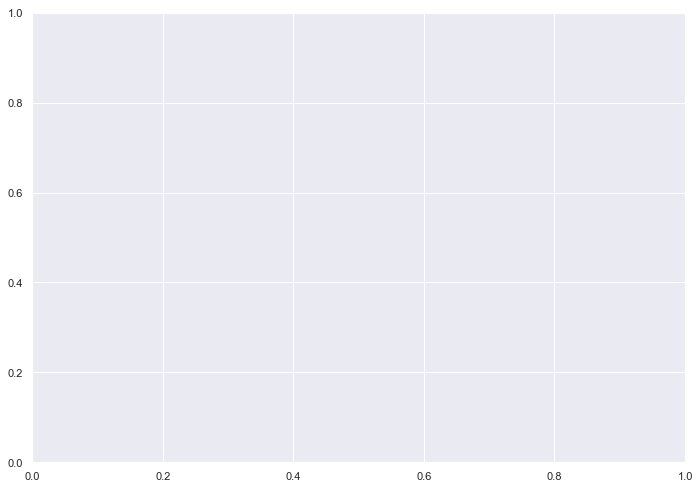

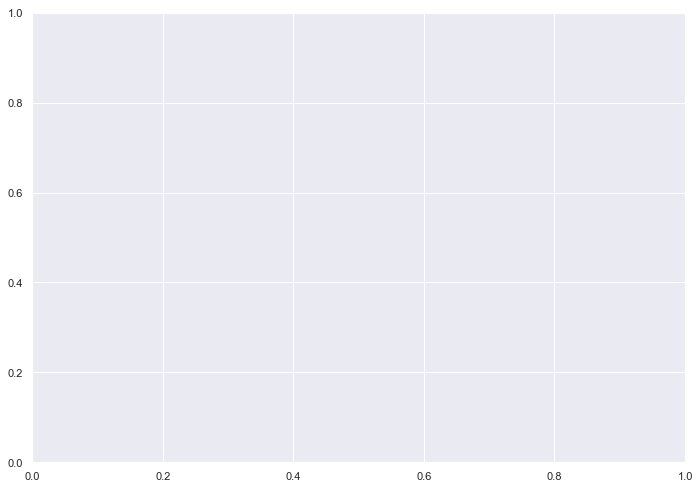

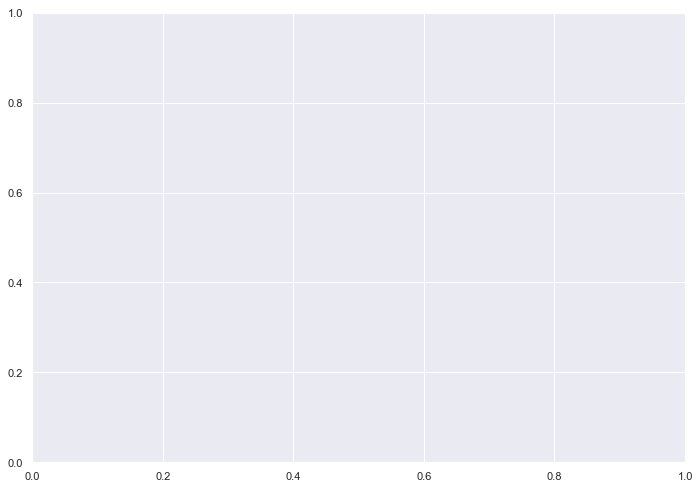

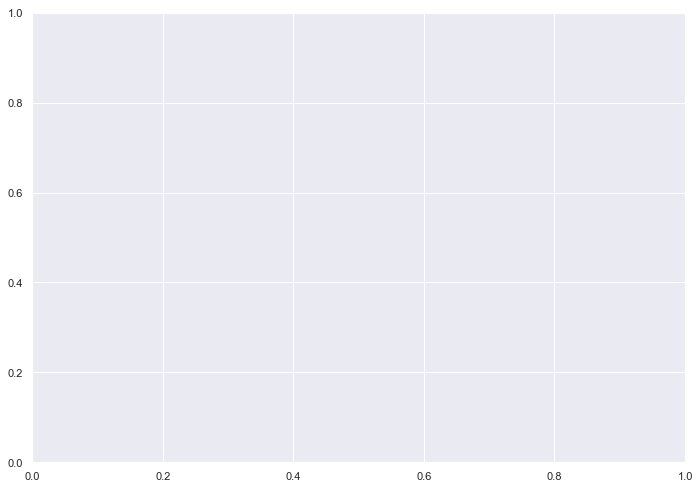

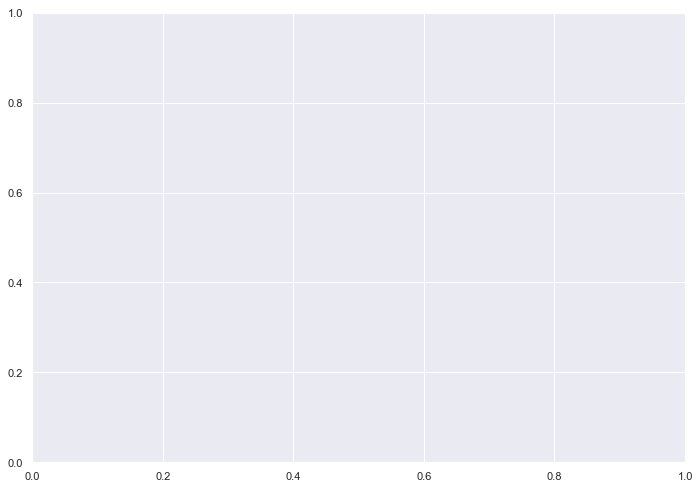

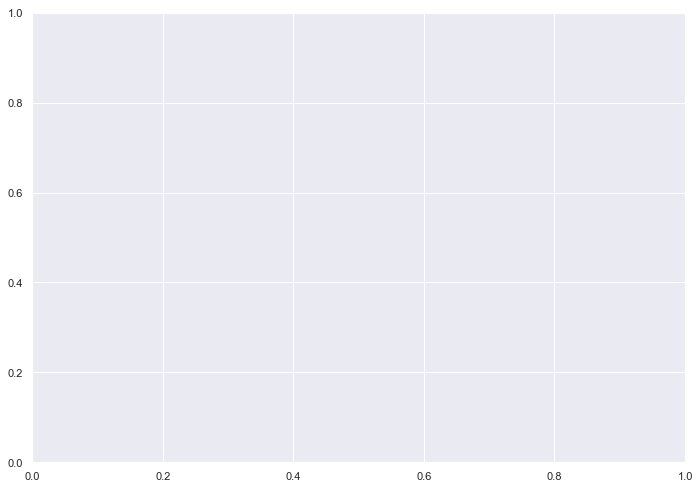

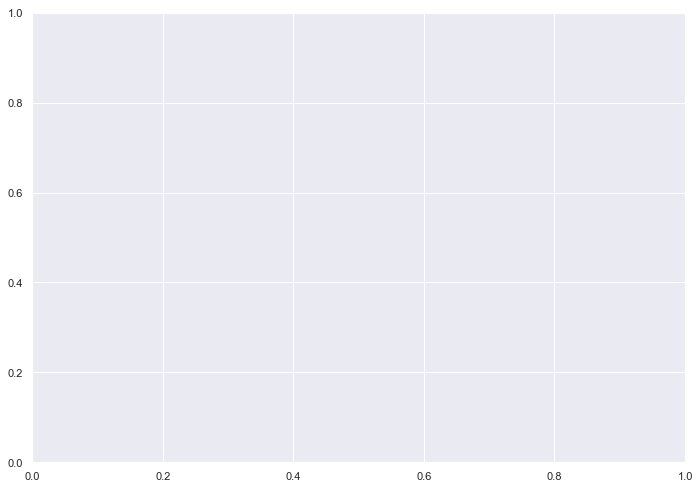

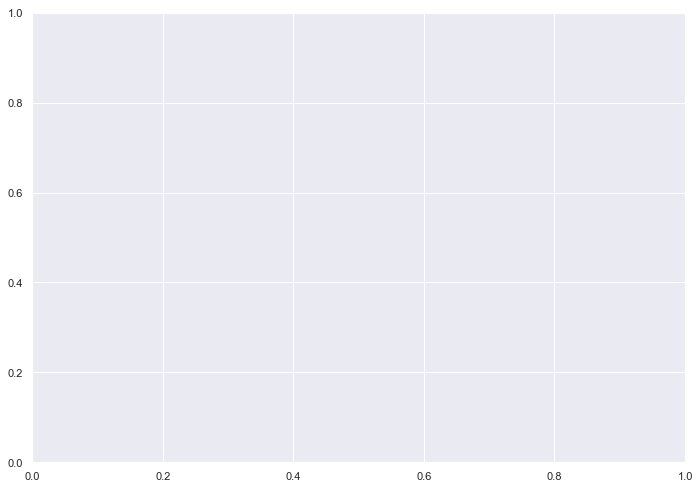

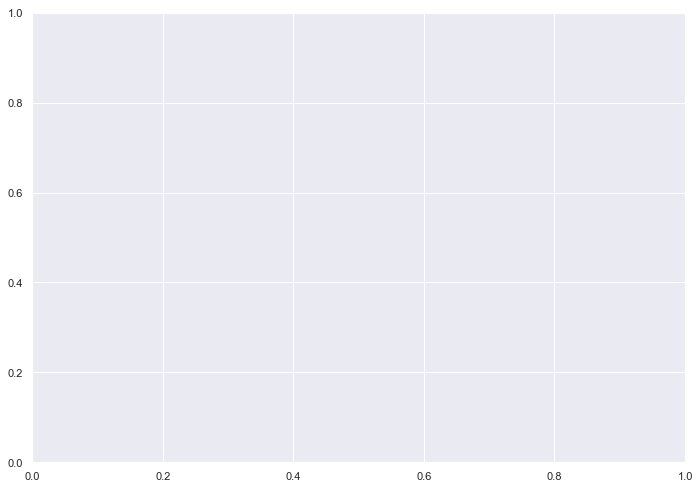

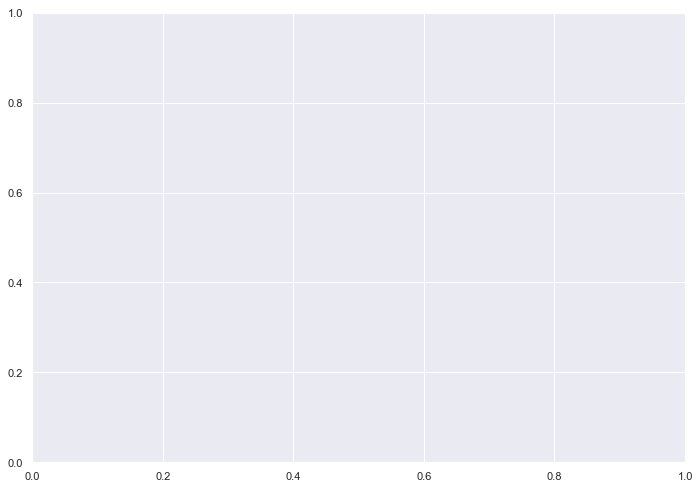

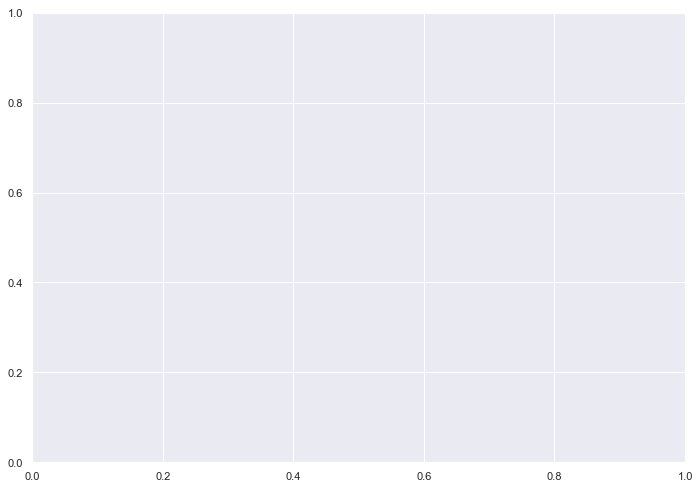

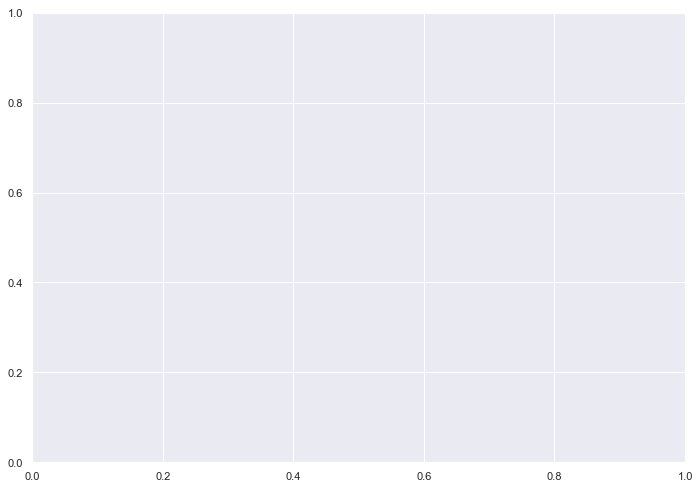

In [112]:
analyze.generate_scatterplots(article_data, "text", tool_order, "scatterplots/z-score/", standardization='z-score')

                      count      mean       std         min     25%       50%  \
title_recessie       4640.0 -0.001293  0.035940   -1.000000  0.0000  0.000000   
title_boukes         4640.0  0.016595  0.249043   -2.000000  0.0000  0.000000   
title_LIWC           4640.0 -0.249030  8.622618 -100.000000  0.0000  0.000000   
title_sentistrength  4640.0 -0.241164  0.808334   -3.000000  0.0000  0.000000   
title_pattern        4640.0 -0.002780  0.225720   -1.000000  0.0000  0.000000   
title_polyglot       4640.0  0.045520  0.697669   -1.000000 -0.2125  0.000000   
title_DANEW          4640.0  0.056064  0.194030   -1.326222  0.0000  0.020307   
title_gold           4640.0 -0.089655  0.747880   -1.000000 -1.0000  0.000000   
title_top3           4640.0 -0.003418  0.722481   -4.101097 -0.4002  0.085527   

                          75%         max  
title_recessie       0.000000    0.000000  
title_boukes         0.000000    2.000000  
title_LIWC           0.000000  100.000000  
title_sentist

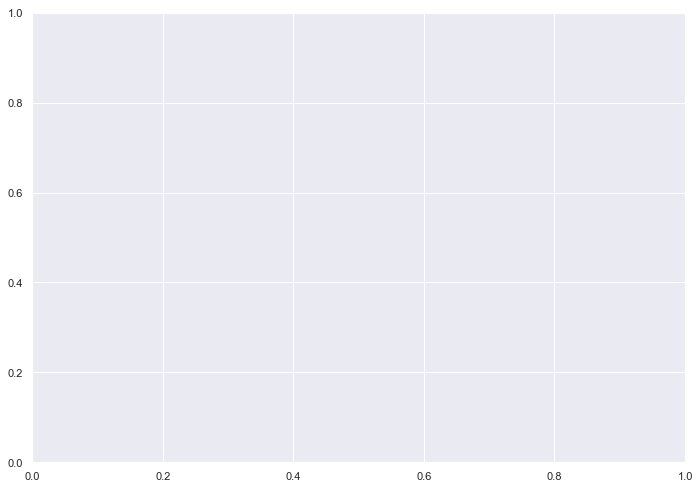

In [113]:
analyze.generate_scatterplots(article_data, "title", tool_order, "scatterplots/unstandardized/", standardization=False)

                      count         mean          std  min          25%  \
title_recessie       4640.0    -0.001293     0.035940 -1.0     0.000000   
title_boukes         4640.0     0.008297     0.124522 -1.0     0.000000   
title_LIWC           4640.0    -0.002490     0.086226 -1.0     0.000000   
title_sentistrength  4640.0    -0.080388     0.269445 -1.0     0.000000   
title_pattern        4640.0     0.017571     0.230326 -1.0     0.020408   
title_polyglot       4640.0     0.045520     0.697669 -1.0    -0.212500   
title_DANEW          4640.0    -0.236306     0.107199 -1.0    -0.267280   
title_gold           4640.0    -0.089655     0.747880 -1.0    -1.000000   
title_top3           4640.0    -0.021245     0.172569 -1.0    -0.116019   
ID                   4640.0  2319.500000  1339.596954  0.0  1159.750000   

                              50%          75%     max  
title_recessie       0.000000e+00     0.000000     0.0  
title_boukes         0.000000e+00     0.000000     1.0  
tit

/Users/theo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


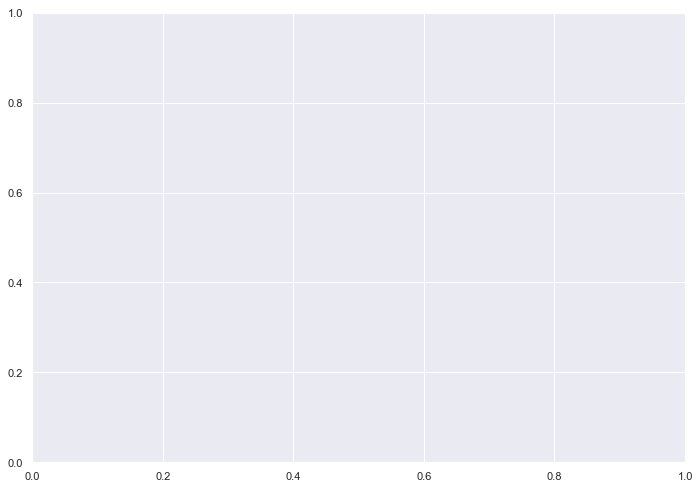

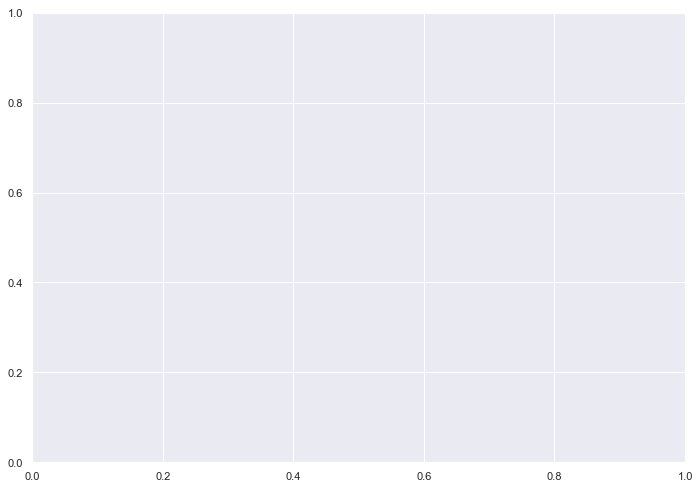

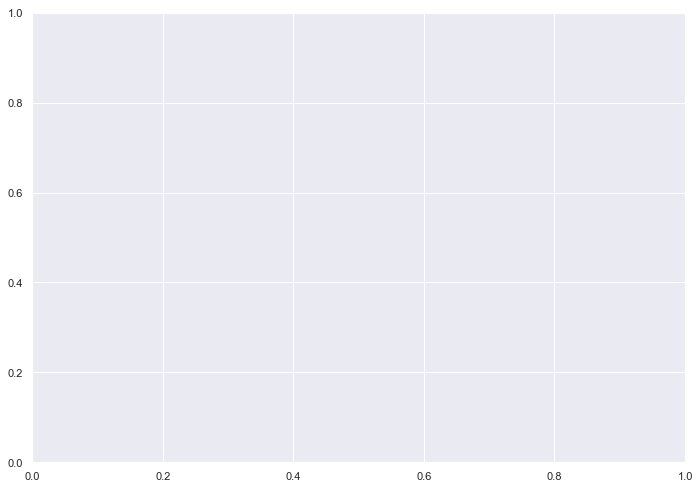

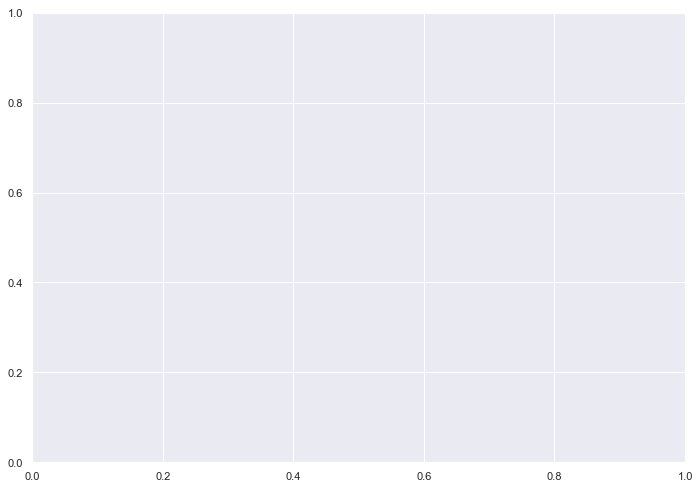

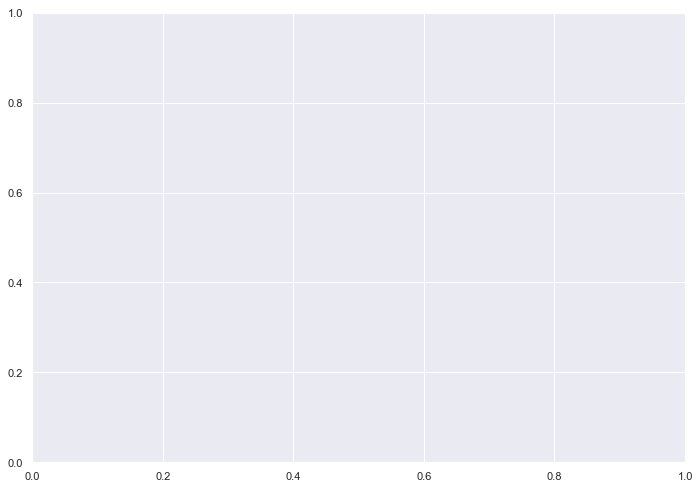

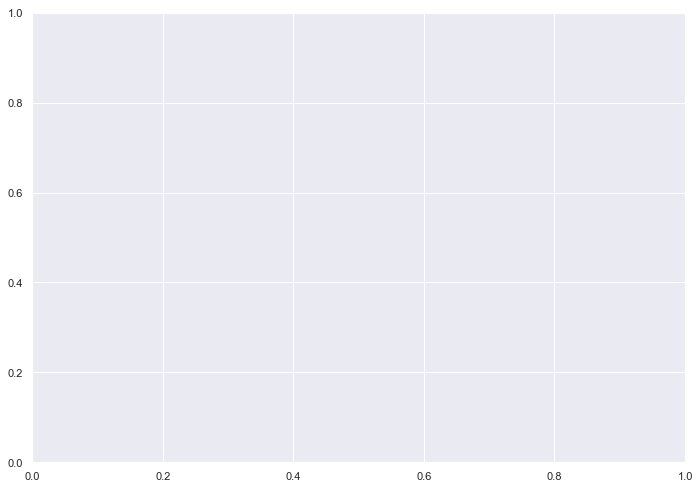

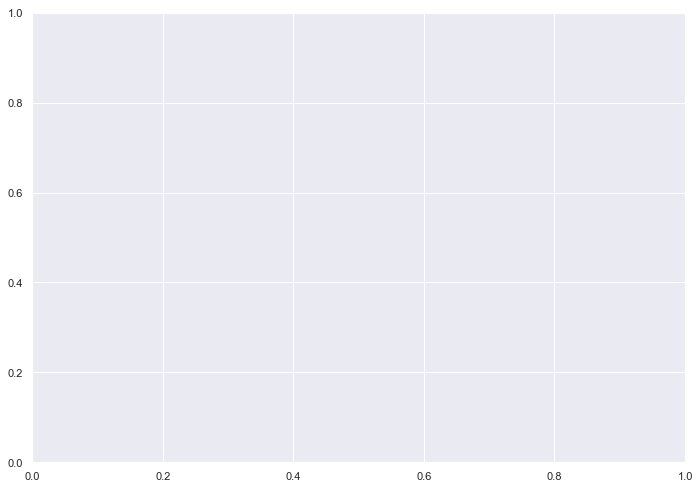

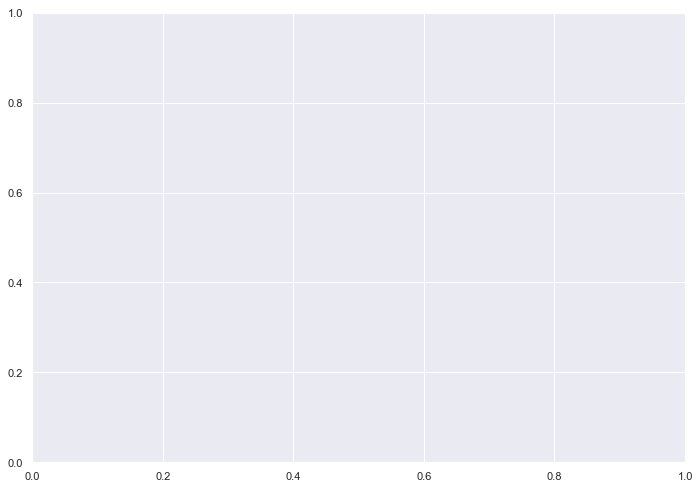

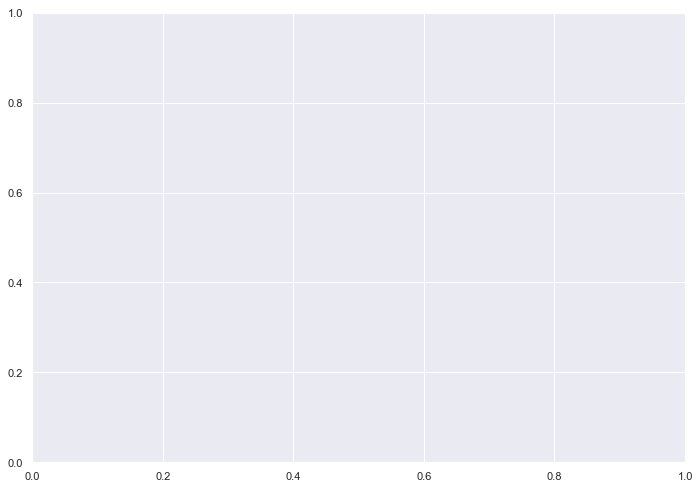

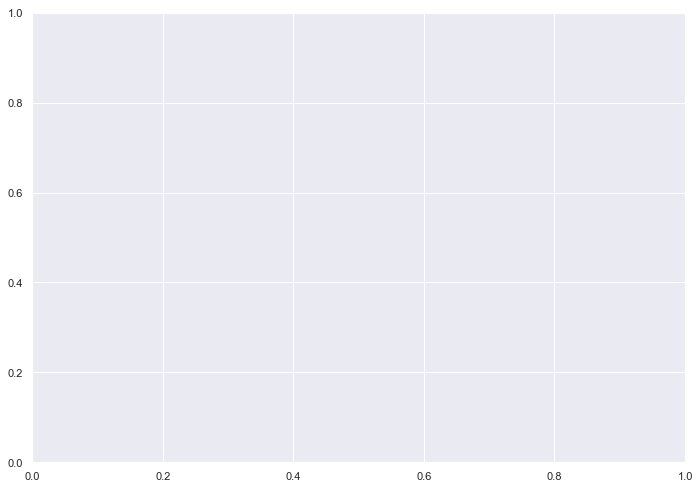

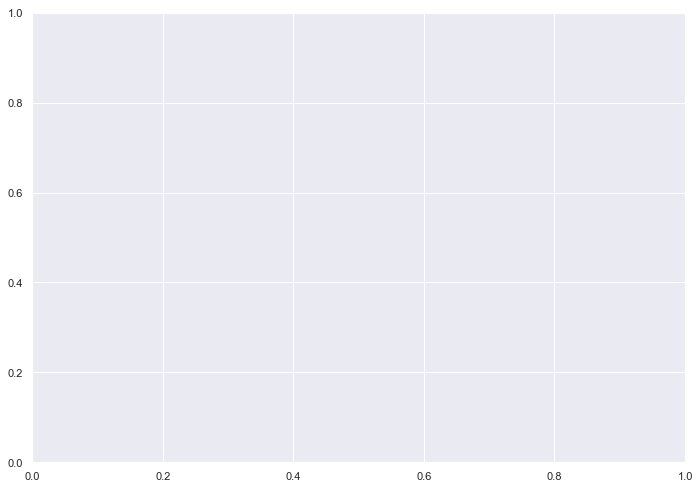

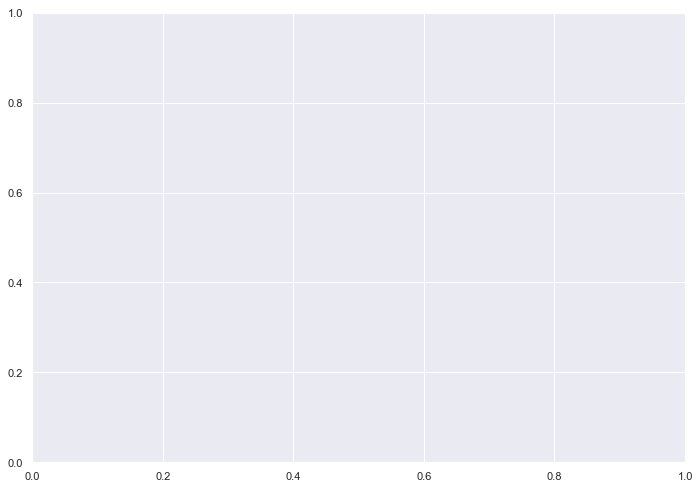

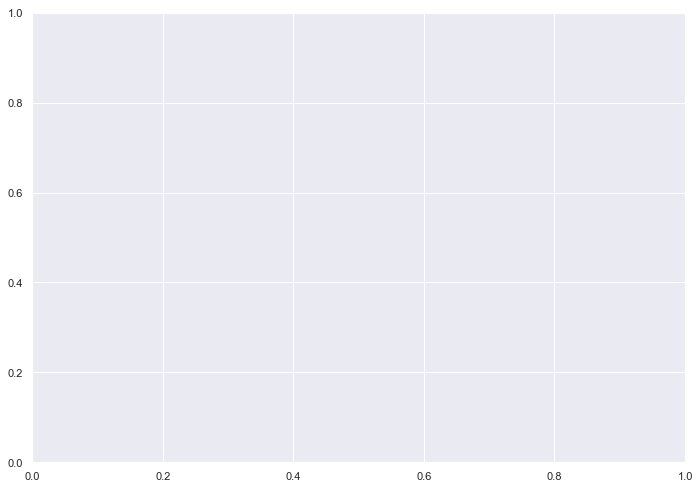

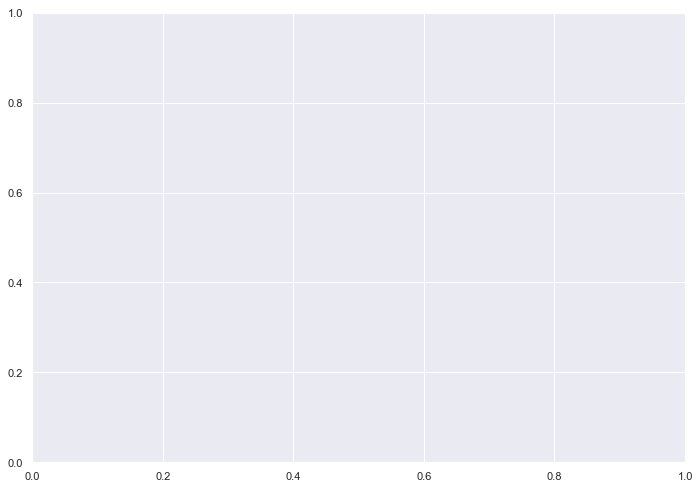

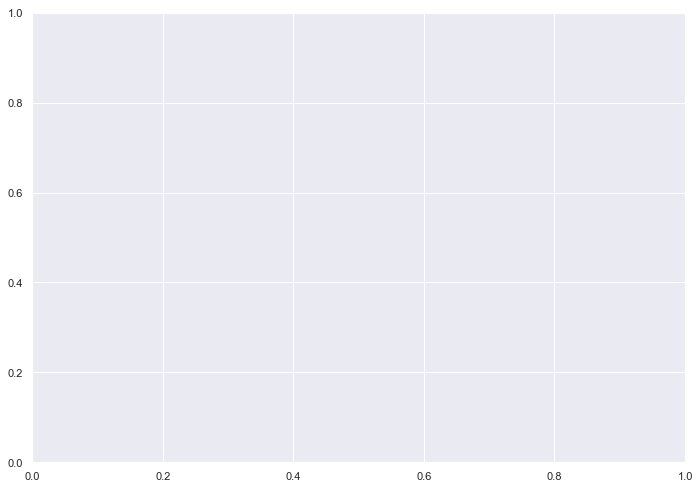

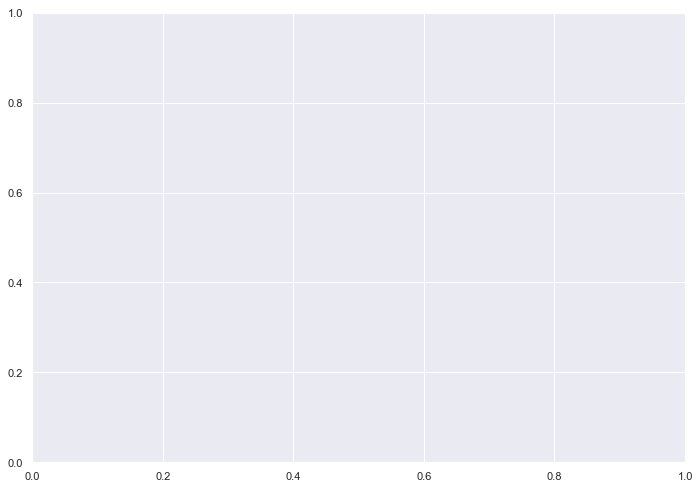

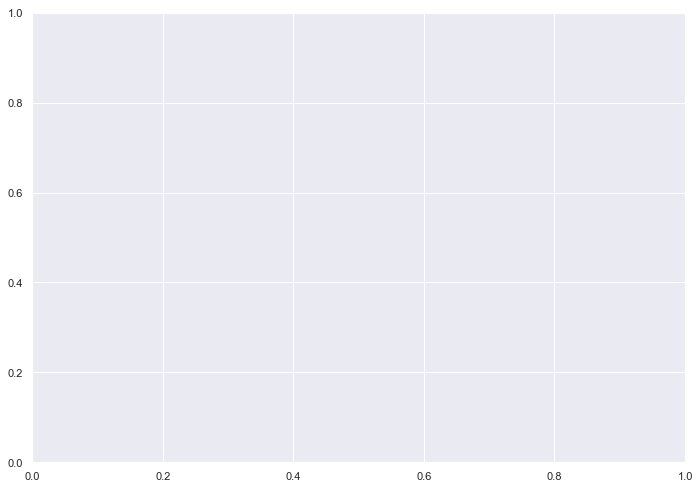

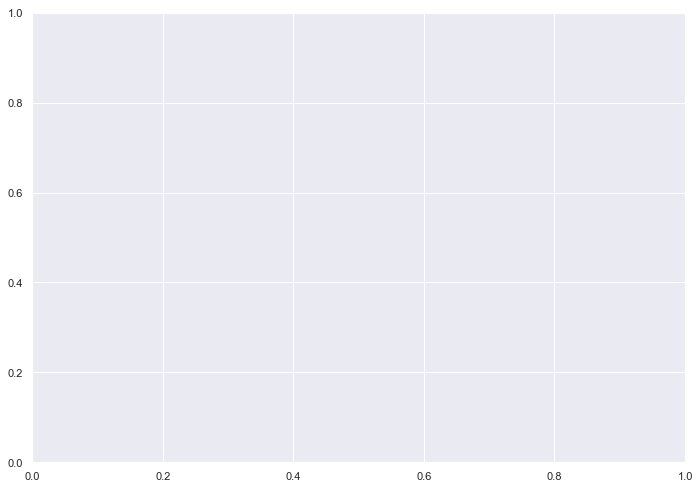

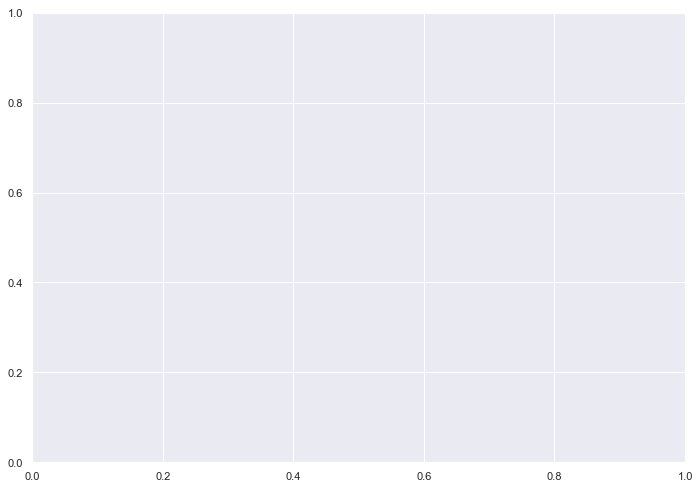

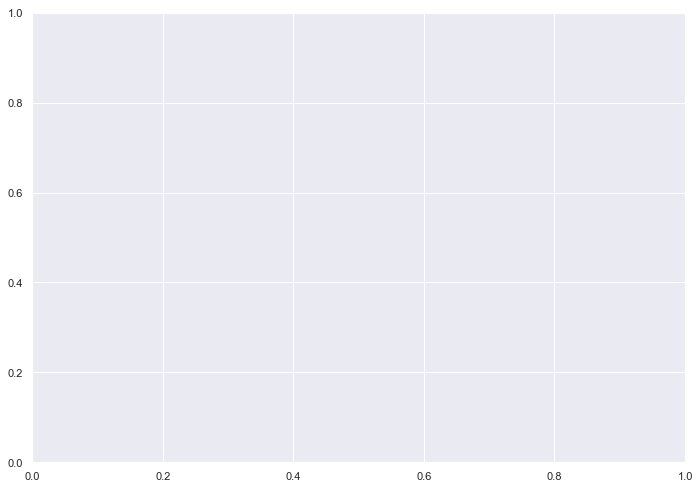

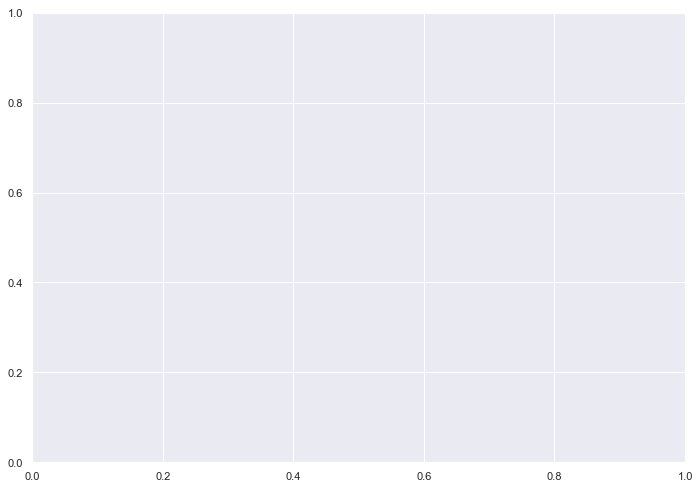

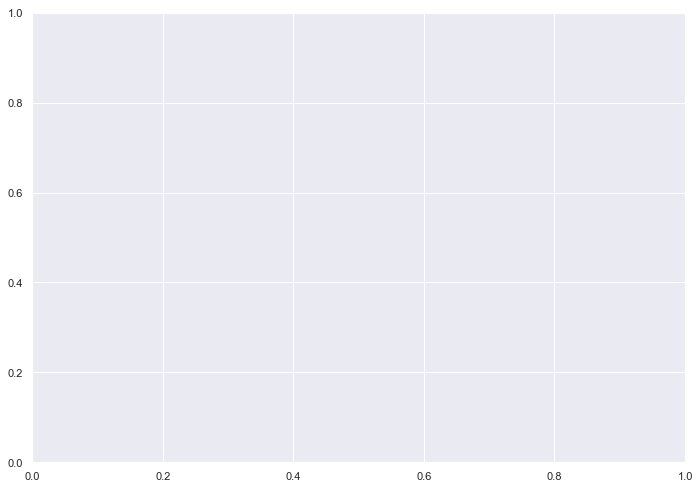

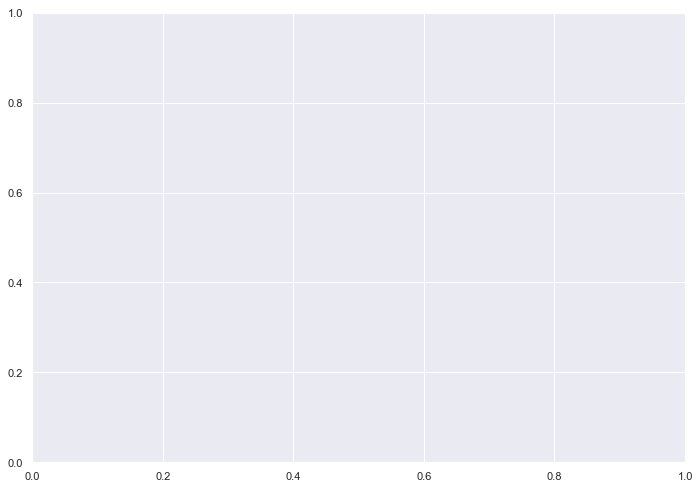

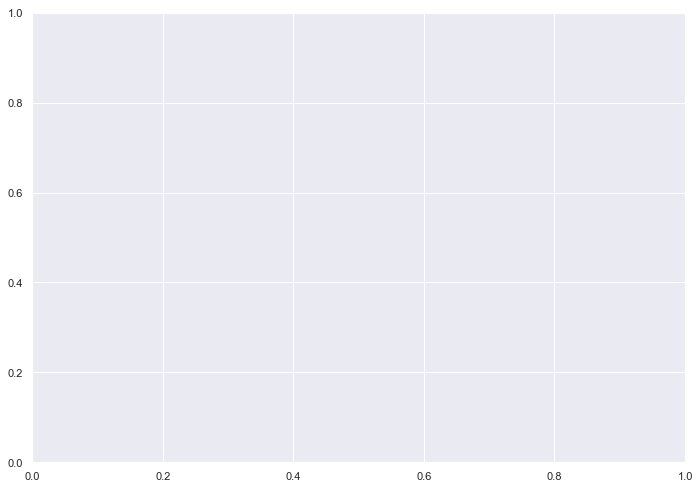

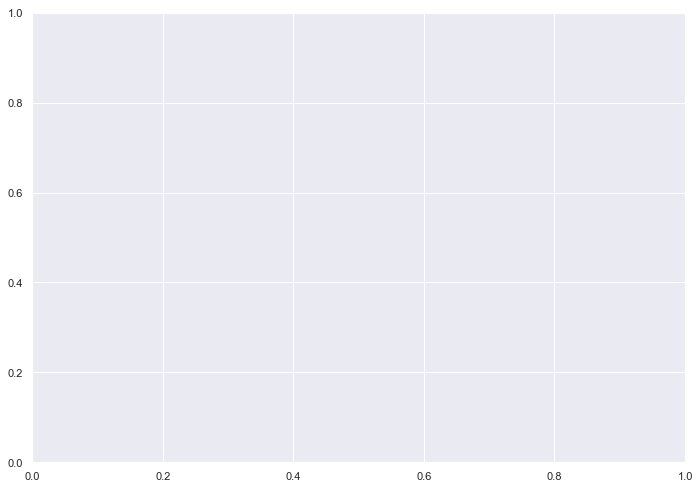

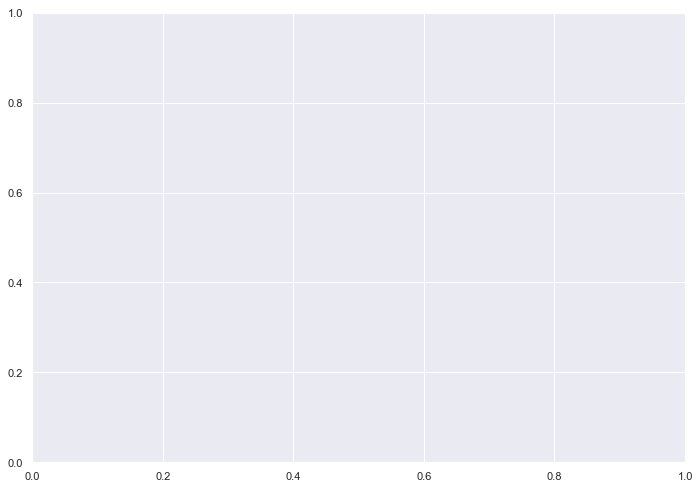

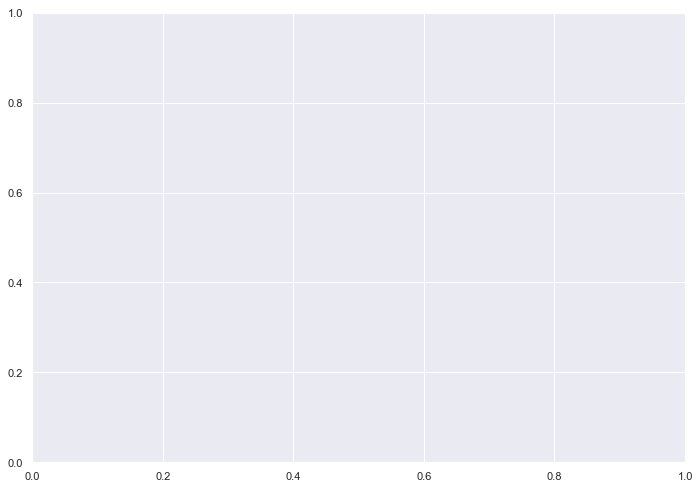

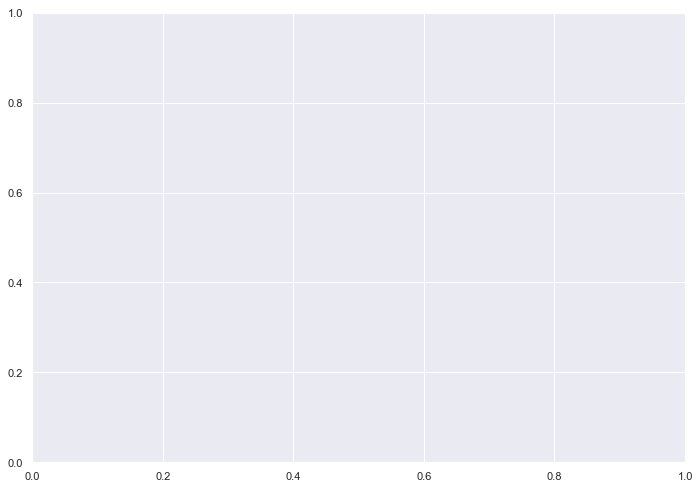

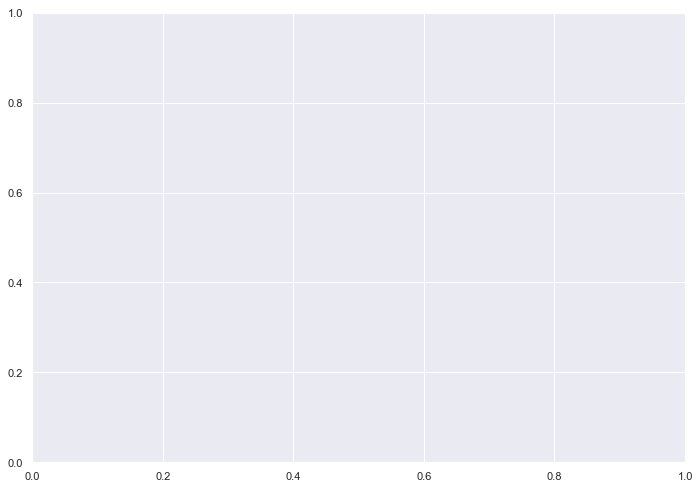

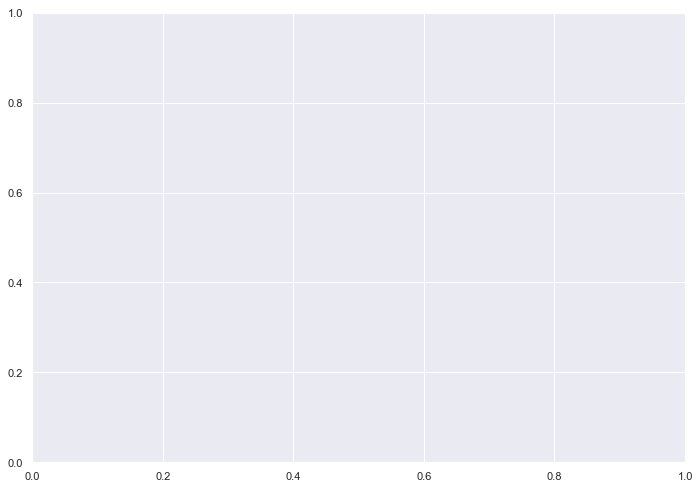

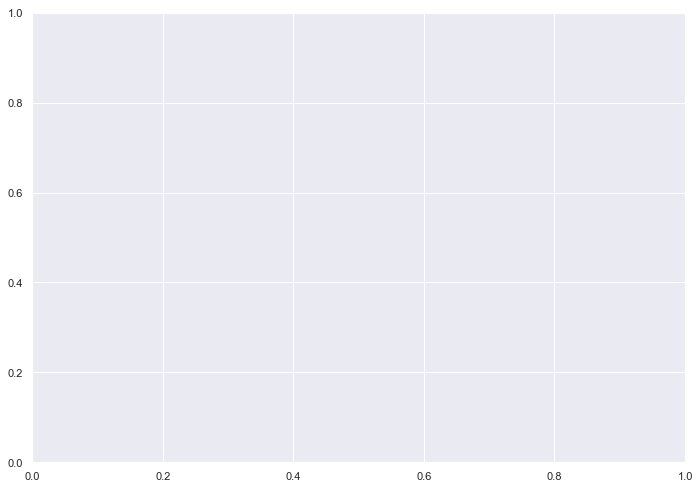

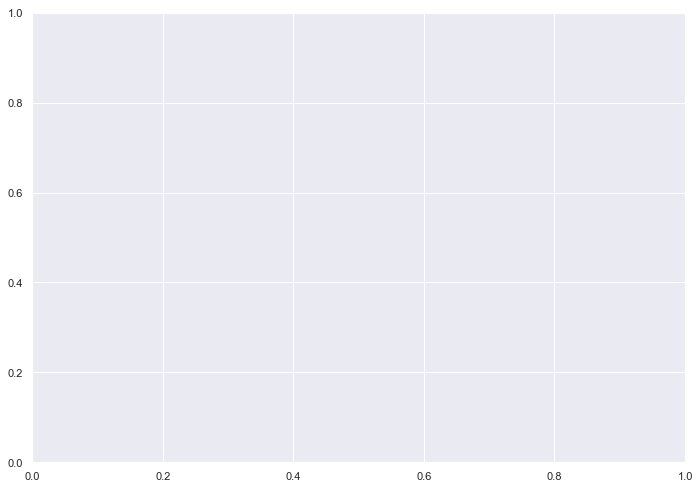

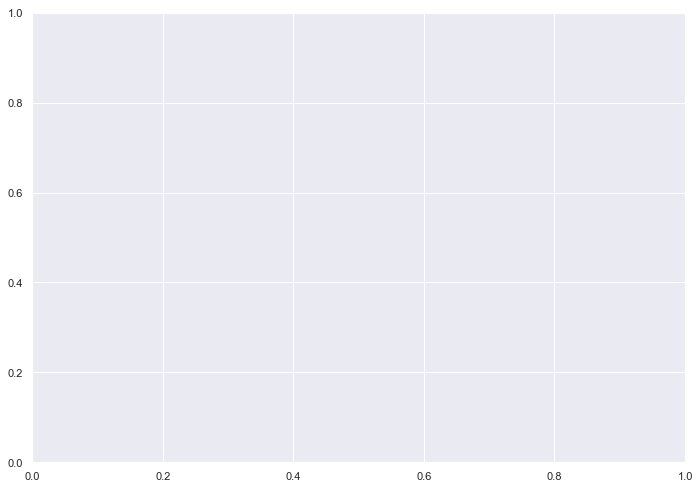

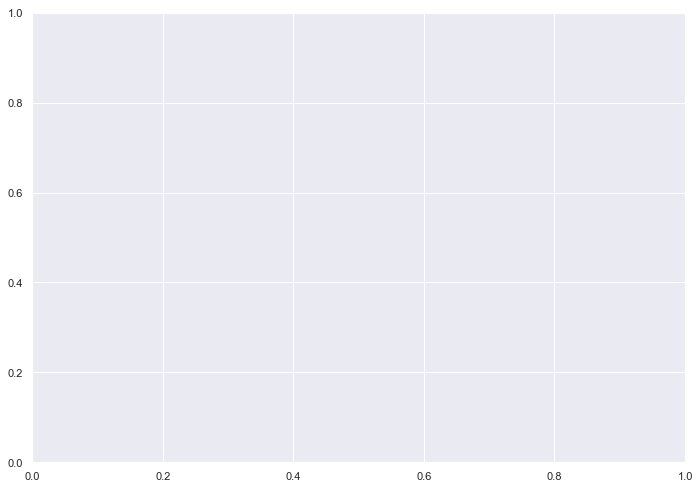

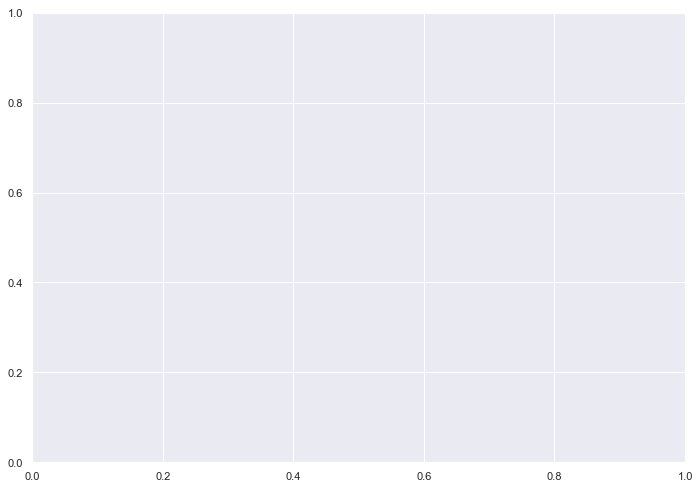

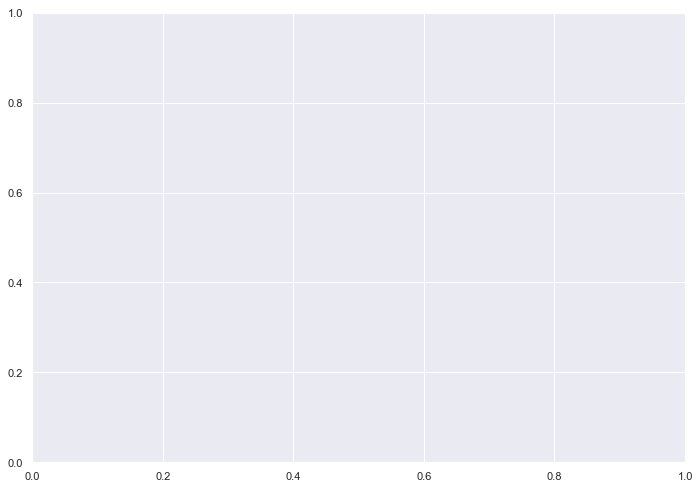

In [114]:
analyze.generate_scatterplots(article_data, "title", tool_order, "scatterplots/min-max/", standardization='min-max')

                      count          mean          std        min  \
title_recessie       4640.0 -1.293103e-03     0.035940  -1.000000   
title_boukes         4640.0  2.206090e-17     1.000108  -8.098246   
title_LIWC           4640.0 -1.364053e-15     1.000108 -11.569771   
title_sentistrength  4640.0 -9.865671e-16     1.000108  -3.413360   
title_pattern        4640.0  1.281097e-16     1.000108  -4.418431   
title_polyglot       4640.0 -3.139251e-16     1.000108  -1.498752   
title_DANEW          4640.0 -6.416084e-16     1.000108  -7.124836   
title_gold           4640.0 -4.201321e-16     1.000108  -1.217366   
title_top3           4640.0  2.512358e-16     1.000108  -5.672284   
ID                   4640.0  2.319500e+03  1339.596954   0.000000   

                             25%          50%          75%          max  
title_recessie          0.000000     0.000000     0.000000     0.000000  
title_boukes           -0.066642    -0.066642    -0.066642     7.964963  
title_LIWC        

/Users/theo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


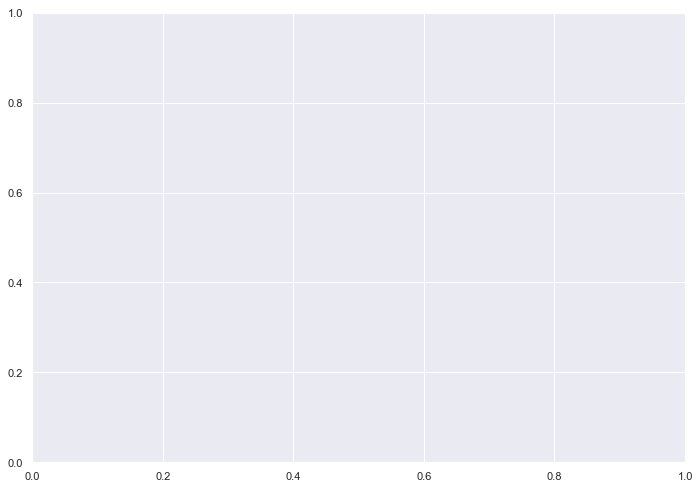

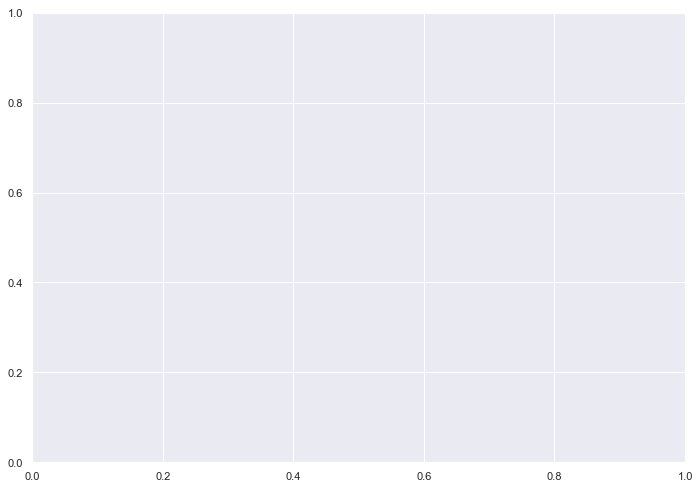

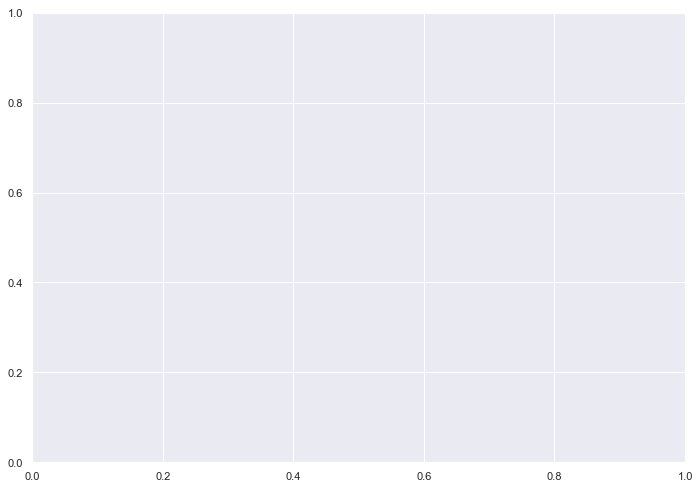

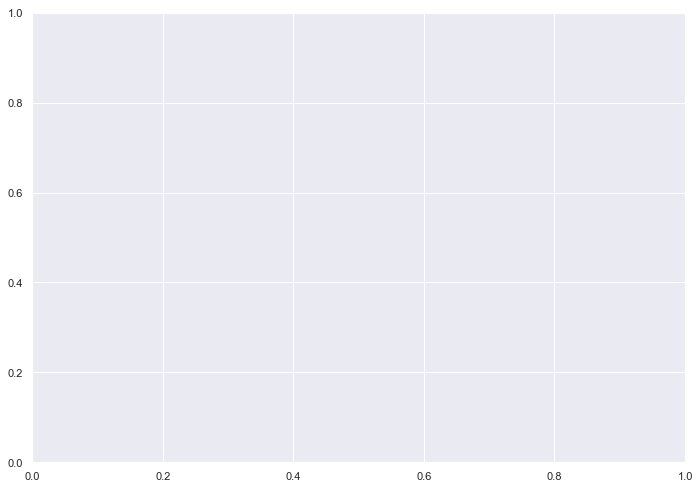

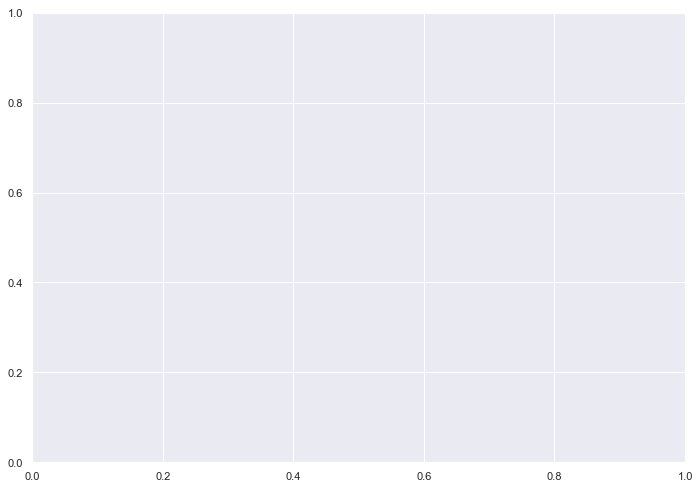

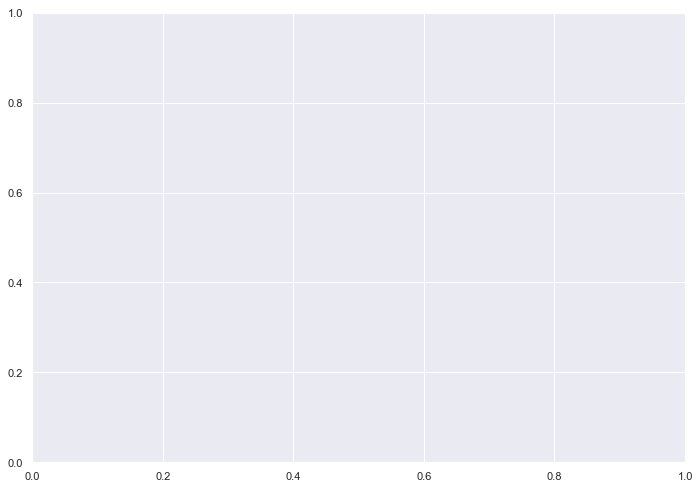

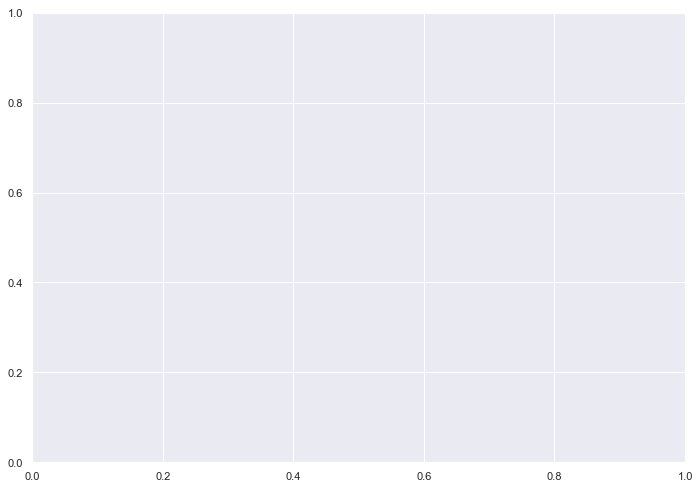

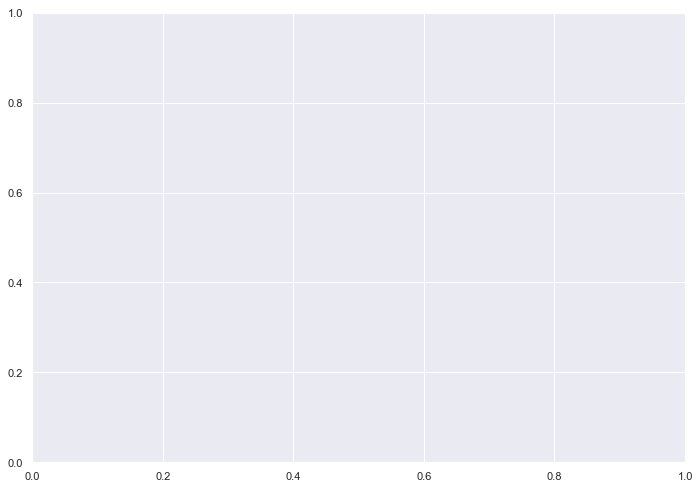

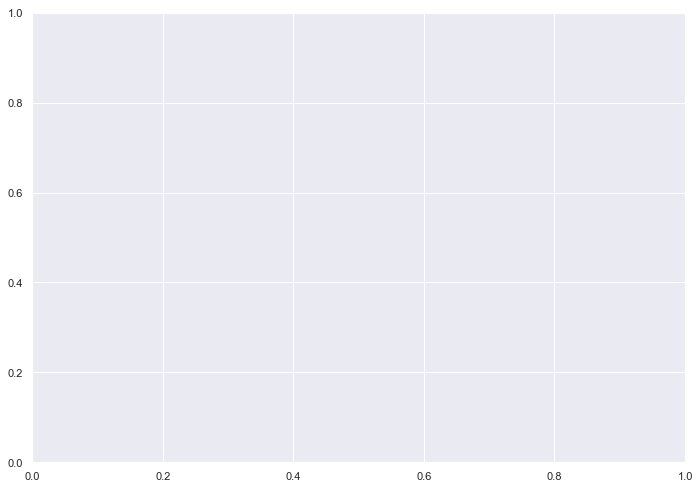

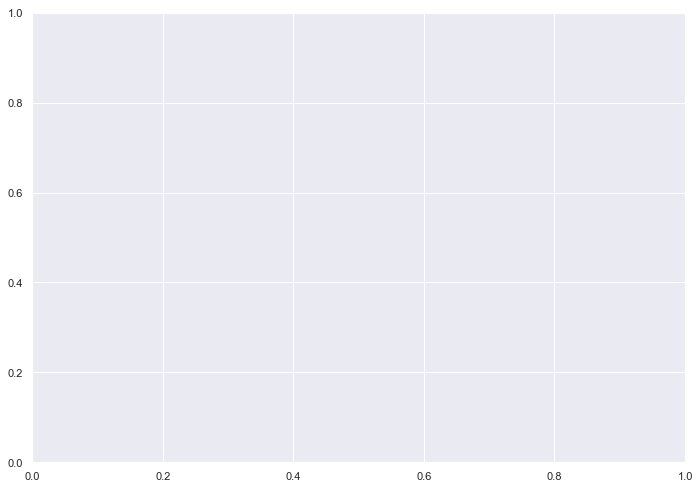

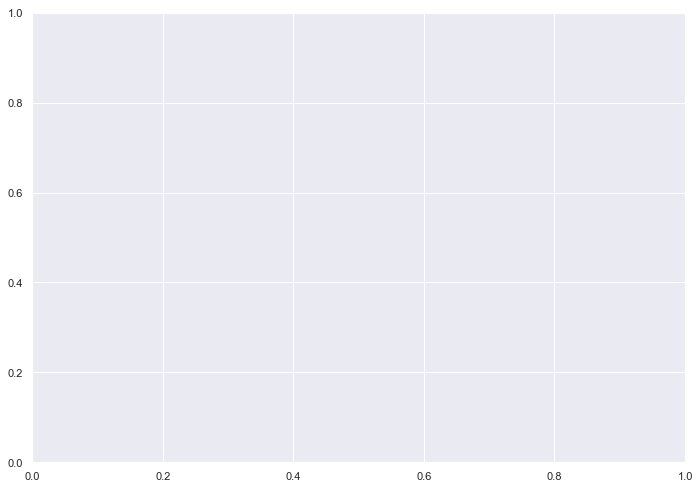

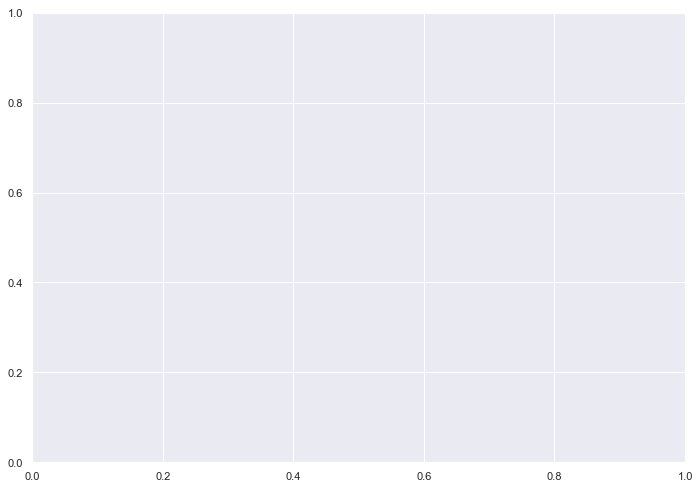

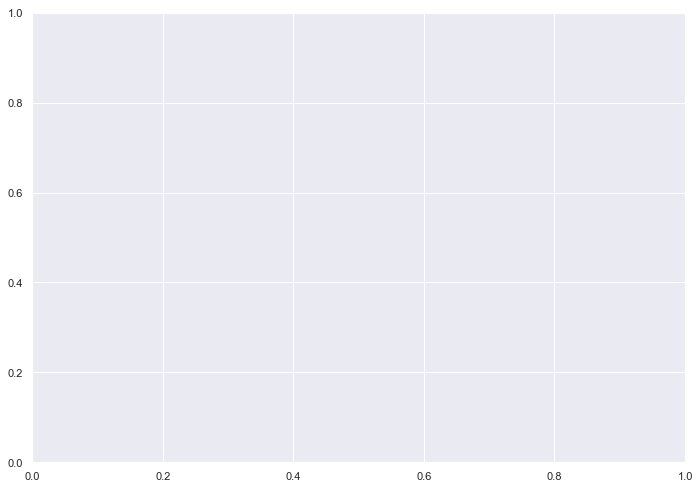

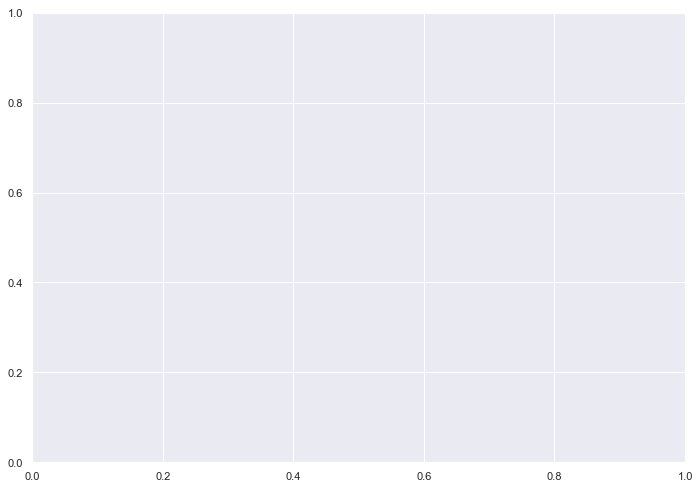

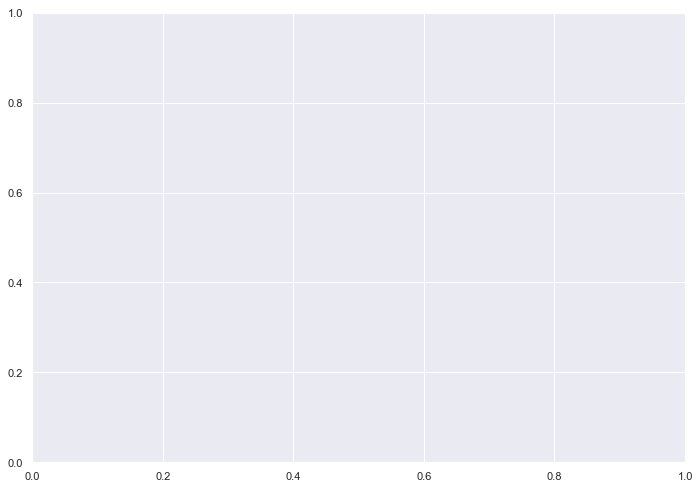

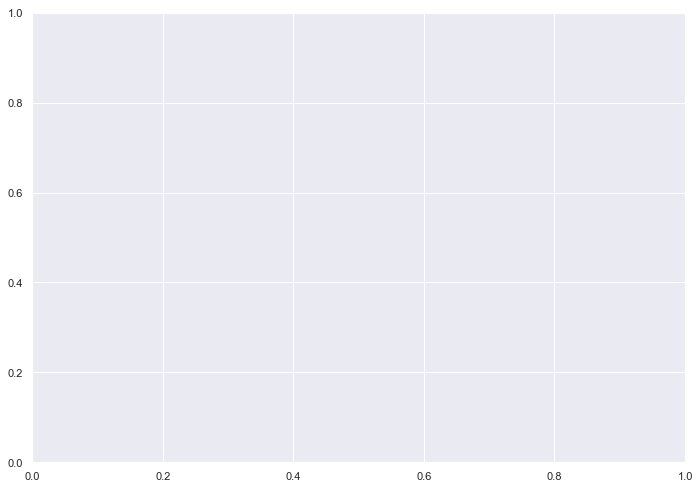

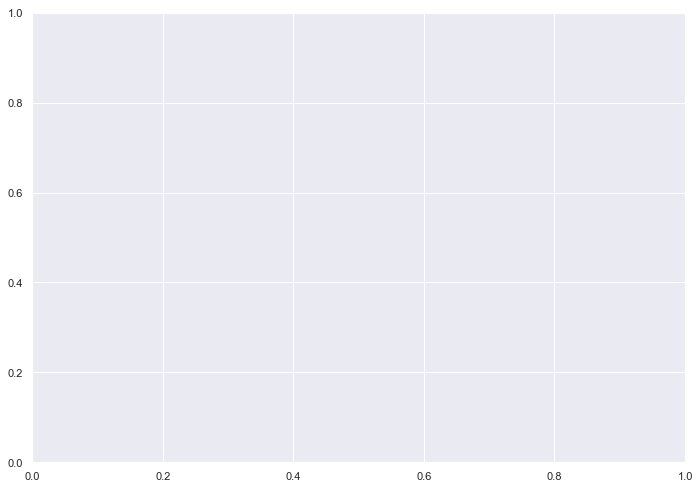

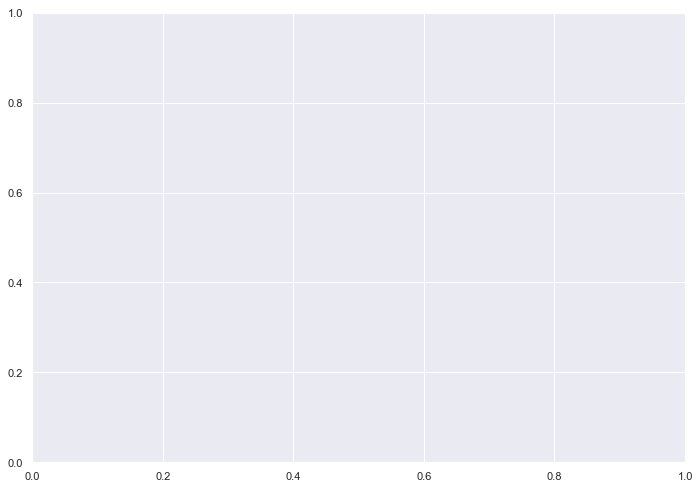

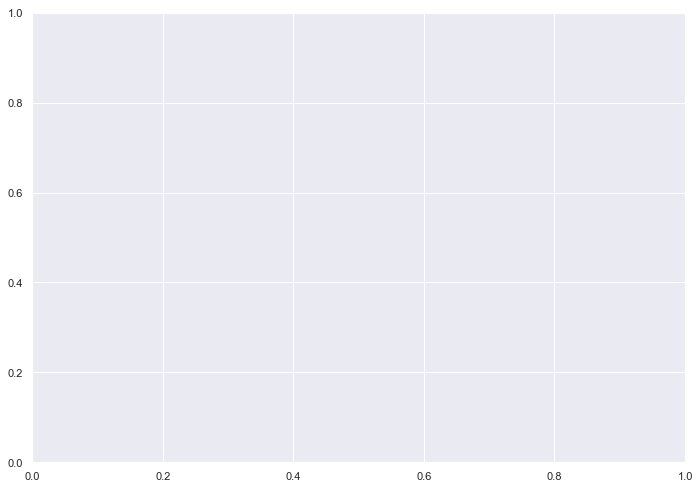

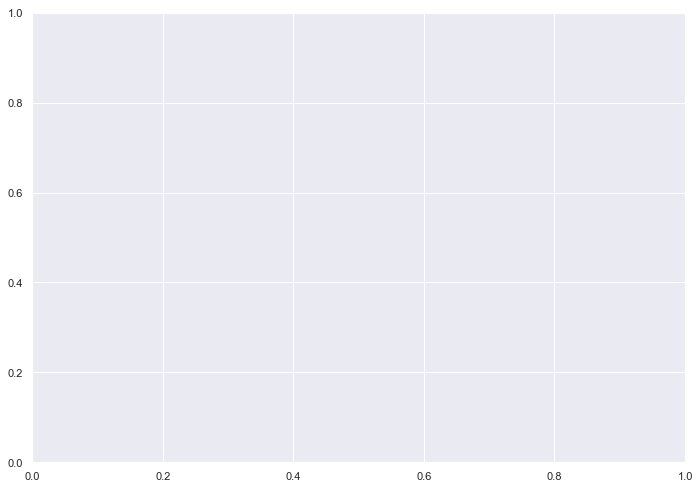

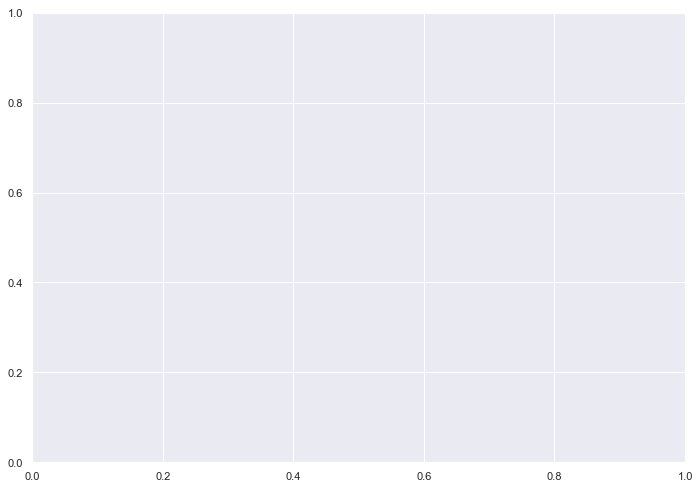

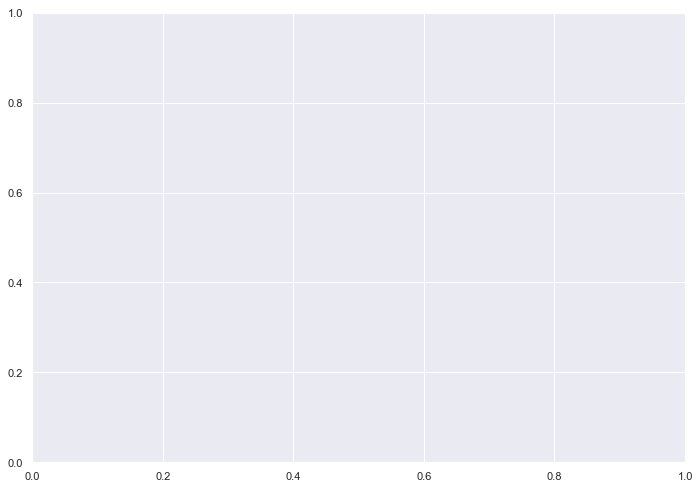

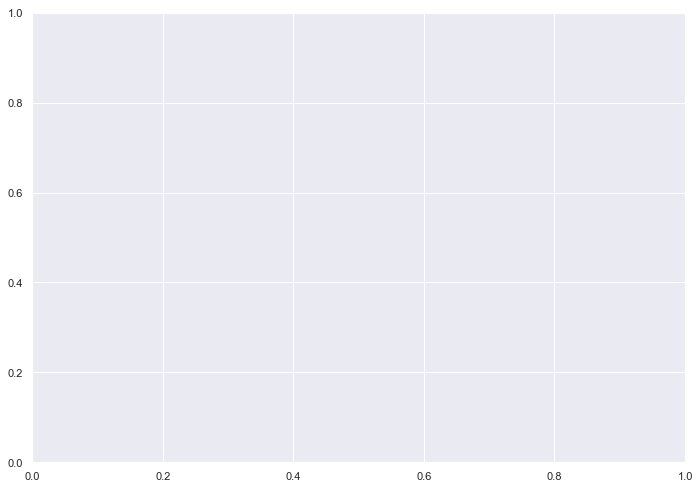

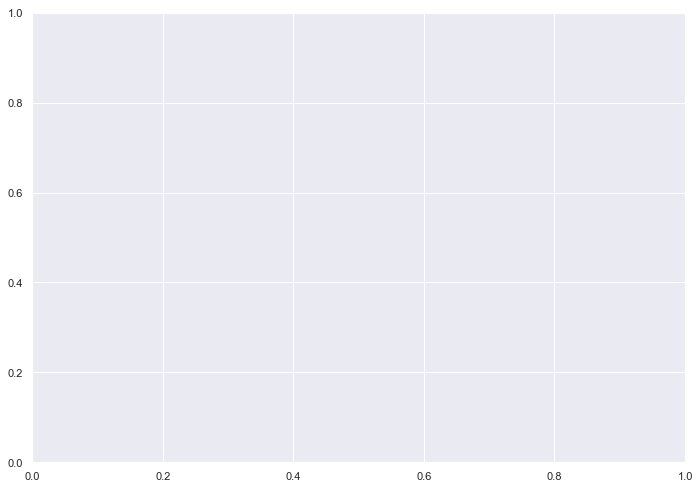

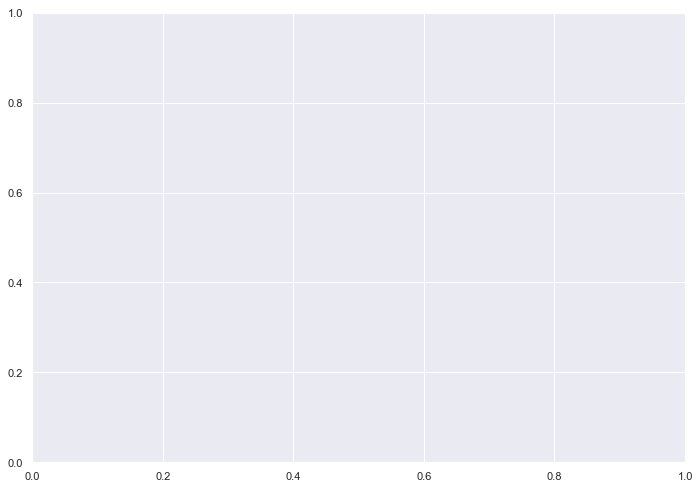

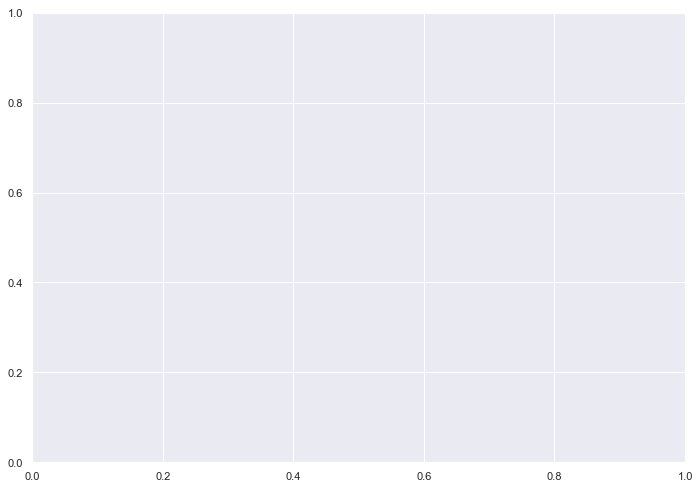

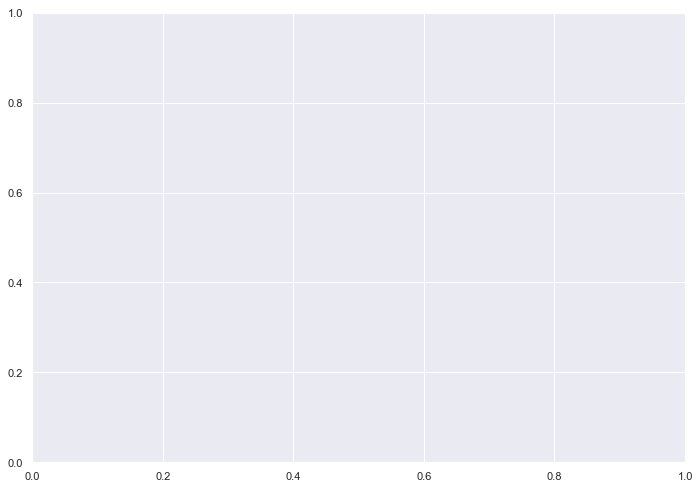

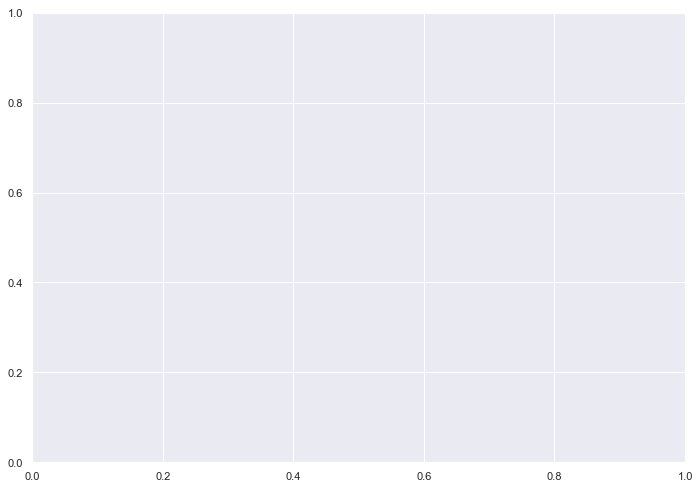

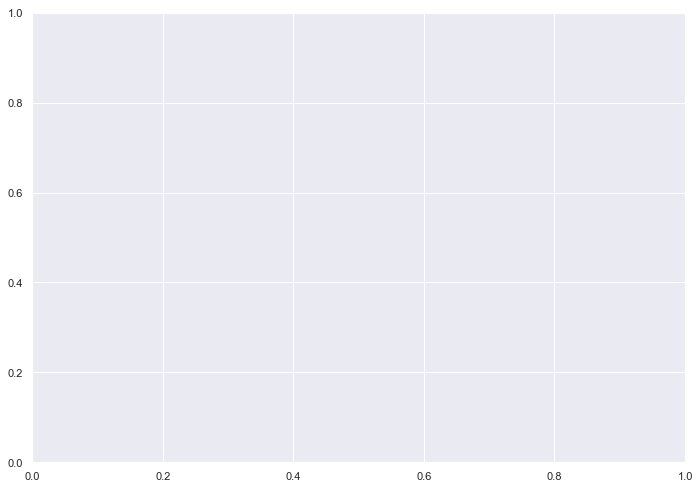

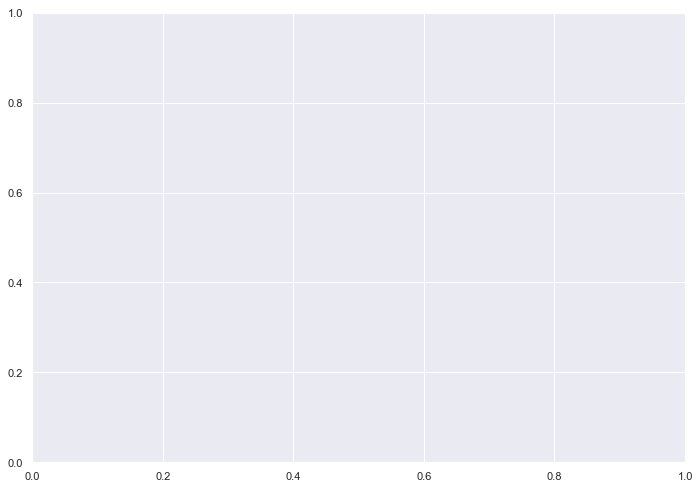

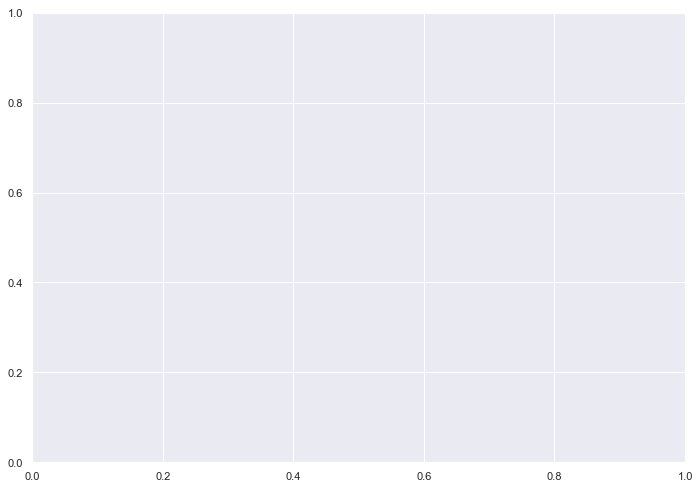

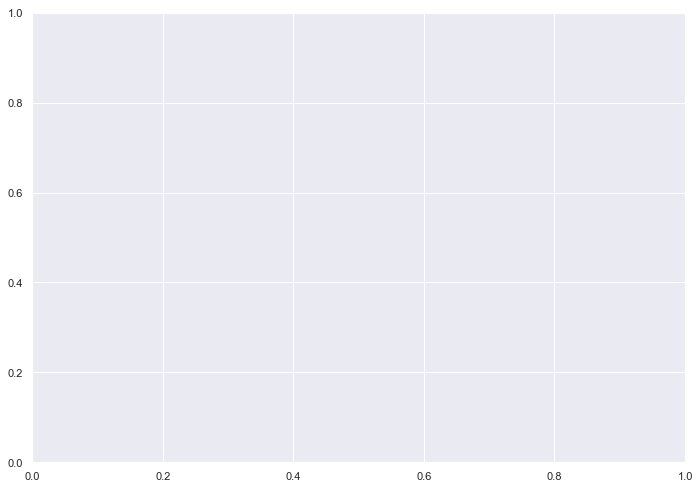

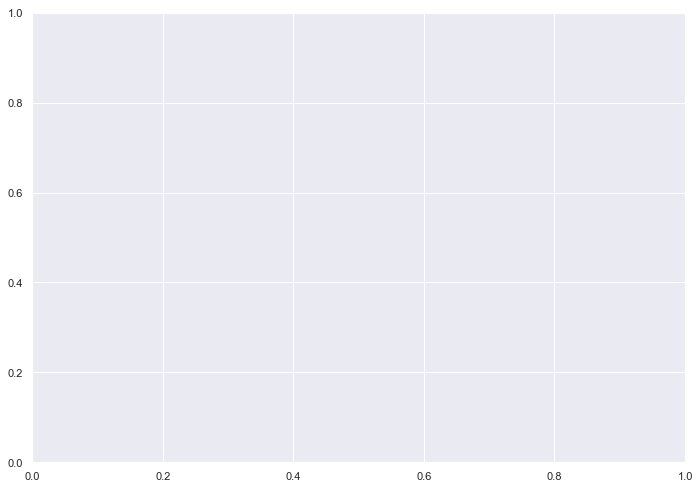

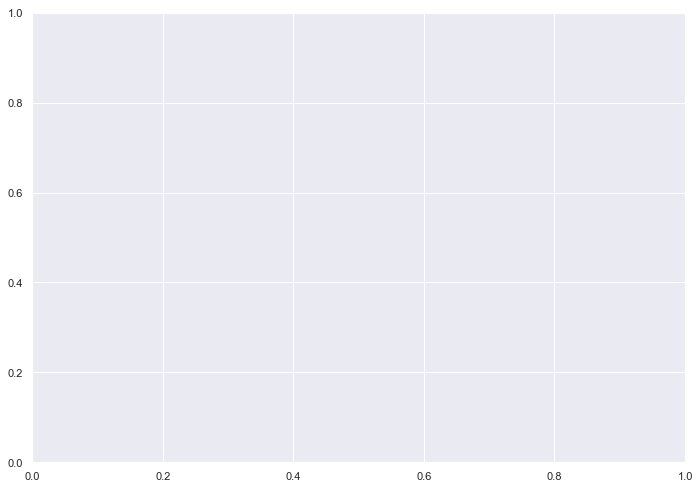

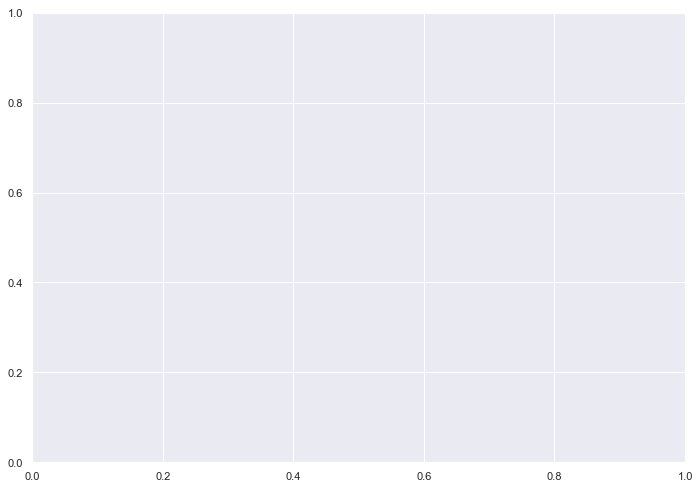

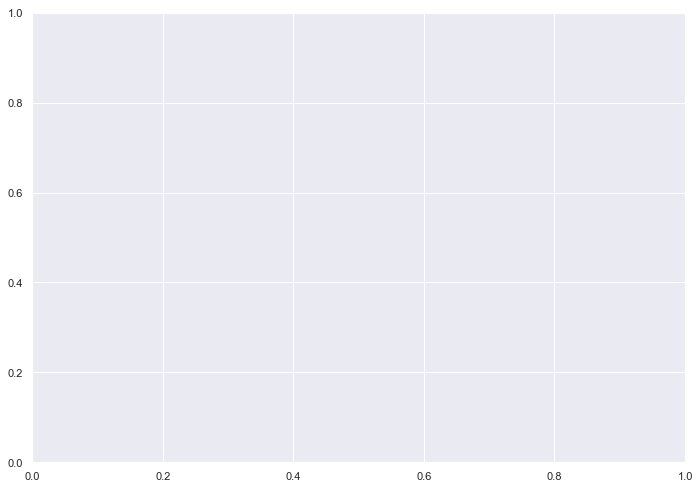

In [115]:
analyze.generate_scatterplots(article_data, "title", tool_order, "scatterplots/z-score/", standardization='z-score')

# Intercoder reliability across tools

In [116]:
analyze.export_for_check_intercoder(article_data,'text', 'kalpha_results_r1', trinairize=True,trinary_cutoff=0.5, beta=1, errors=False, normalization='zscore')

text_recessie
text_boukes
text_LIWC
text_sentistrength
text_pattern
text_polyglot
text_DANEW
text_top4
text_top3
text_top2
text_top1


In [117]:
analyze.export_for_check_intercoder(article_data,'title', 'kalpha_results_r1', trinairize=True,trinary_cutoff=0.5, beta=1, errors=False, normalization='zscore')

title_recessie
title_boukes
title_LIWC
title_sentistrength
title_pattern
title_polyglot
title_DANEW
title_top4
title_top3
title_top2
title_top1


In [118]:
data['title_LIWC'].describe()

count    5806.000000
mean       -0.204487
std         9.007601
min      -100.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       100.000000
Name: title_LIWC, dtype: float64